# Classical MVO Empirical Implementation

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.optimize import minimize
import scipy.stats as stats
import seaborn as sns
import cvxpy as cp

## Dataset Loading and Inspection of comulative returns

In [10]:

stock_returns = pd.read_csv("../Data/final_dataset_stocks.csv", index_col=0, parse_dates=True)
bond_returns = pd.read_csv("../Data/final_dataset_bonds.csv", index_col=0, parse_dates=True)
sp_benchmark = pd.read_csv("../Data/SP_500_benchmark.csv", index_col=0, parse_dates=True)

In [11]:
sp_benchmark

sprtrn
caldt               
2008-01-31 -0.061163
2008-02-29 -0.034761
2008-03-31 -0.005960
2008-04-30  0.047547
2008-05-30  0.010674
...              ...
2022-08-31 -0.042440
2022-09-30 -0.093396
2022-10-31  0.079863
2022-11-30  0.053753
2022-12-30 -0.058971

[180 rows x 1 columns]

In [12]:
bond_returns = bond_returns.drop(columns=["b1ret"])
bond_returns = bond_returns.drop(columns=["b7ret"])


bond_returns.columns.name = None
bond_returns.index.name = None


bond_returns.index = pd.to_datetime(bond_returns.index)

bond_returns = bond_returns.apply(pd.to_numeric)
bond_returns 

b20ret
2008-01-31  0.025689
2008-02-29  0.000404
2008-03-31  0.012042
2008-04-30 -0.018873
2008-05-30 -0.029605
...              ...
2022-08-31 -0.046849
2022-09-30 -0.067945
2022-10-31 -0.041092
2022-11-30  0.071208
2022-12-30 -0.025772

[180 rows x 1 columns]

In [13]:
stock_returns = stock_returns.copy()
bond_returns = bond_returns.copy()

stock_returns = stock_returns.reset_index().rename(columns={'index': 'Date'})
bond_returns = bond_returns.reset_index().rename(columns={'index': 'Date'})


returns = pd.merge(stock_returns, bond_returns, on='Date', how='inner')

returns.set_index('Date', inplace=True)
returns.index.name = None  # Drop the index name

returns[0:15]

A T & T INC  ALPHABET INC  ALTRIA GROUP INC  \
2008-01-31    -0.064244     -0.183924          0.002779   
2008-02-29    -0.095090     -0.165019         -0.034965   
2008-03-31     0.099627     -0.065177          0.005332   
2008-04-30     0.021149      0.303812         -0.099099   
2008-05-30     0.030741      0.020042          0.113000   
2008-06-30    -0.155639     -0.101366         -0.063342   
2008-07-31    -0.073612     -0.100053         -0.010214   
2008-08-29     0.038299     -0.022079          0.033415   
2008-09-30    -0.127227     -0.135488         -0.041369   
2008-10-31    -0.026862     -0.102766         -0.032762   
2008-11-28     0.066866     -0.184773         -0.162064   
2008-12-31    -0.002101      0.050143         -0.043532   
2009-01-30    -0.121754      0.100374          0.098274   
2009-02-27    -0.034525     -0.001595         -0.066506   
2009-03-31     0.060160      0.029794          0.058290   

            AMERICAN INTERNATIONAL GROUP INC  APPLE INC  BANK OF AMERICA CORP  \
2008-01-31                         -0.057118  -0.316640              0.070044   
2008-02-29                         -0.147535  -0.076389             -0.099887   
2008-03-31                         -0.072770   0.147816             -0.029945   
2008-04-30                          0.068208   0.212195             -0.009760   
2008-05-30                         -0.220779   0.085082             -0.094033   
2008-06-30                         -0.259444  -0.112901             -0.279330   
2008-07-31                         -0.015495  -0.050705              0.378299   
2008-08-29                         -0.175048   0.066562             -0.053496   
2008-09-30                         -0.834807  -0.329558              0.144509   
2008-10-31                         -0.426426  -0.053405             -0.309429   
2008-11-28                          0.052356  -0.138675             -0.327679   
2008-12-31                         -0.218905  -0.078990             -0.113846   
2009-01-30                         -0.184713   0.056005             -0.532670   
2009-02-27                         -0.671875  -0.009098             -0.399696   
2009-03-31                          1.380952   0.177024              0.729114   

            BERKSHIRE HATHAWAY INC DEL  CHEVRON CORP NEW  CISCO SYSTEMS INC  \
2008-01-31                   -0.039548         -0.108004          -0.094936   
2008-02-29                    0.029412          0.047928          -0.004490   
2008-03-31                   -0.047143         -0.015001          -0.012300   
2008-04-30                    0.003373          0.126406           0.064342   
2008-05-30                    0.005977          0.037962           0.042122   
2008-06-30                   -0.103231         -0.000202          -0.129491   
2008-07-31                   -0.052174         -0.146979          -0.054600   
2008-08-29                    0.018785          0.028500           0.093679   
2008-09-30                    0.120069         -0.044486          -0.061954   
2008-10-31                   -0.115697         -0.095538          -0.212323   
2008-11-28                   -0.099489          0.067828          -0.069218   
2008-12-31                   -0.071154         -0.063789          -0.014510   
2009-01-30                   -0.073478         -0.046641          -0.081595   
2009-02-27                   -0.121807         -0.129892          -0.026720   
2009-03-31                    0.103053          0.107561           0.150995   

            CITIGROUP INC  ...  EXXON MOBIL CORP  GENERAL ELECTRIC CO  \
2008-01-31      -0.032269  ...         -0.077810            -0.046129   
2008-02-29      -0.158324  ...          0.011111            -0.054016   
2008-03-31      -0.096584  ...         -0.027928             0.116777   
2008-04-30       0.179739  ...          0.100378            -0.116455   
2008-05-30      -0.121092  ...         -0.042011            -0.060551   
2008-06-30      -0.234354  ...         -0.007098            -0.1210

In [14]:
# Names to tickers mapping

column_names = list(returns.columns)
column_names 

name_to_ticker = {
    'A T & T INC': 'T',
    'ALPHABET INC': 'GOOGL',
    'ALTRIA GROUP INC': 'MO',
    'AMERICAN INTERNATIONAL GROUP INC': 'AIG',
    'APPLE INC': 'AAPL',
    'BANK OF AMERICA CORP': 'BAC',
    'BERKSHIRE HATHAWAY INC DEL': 'BRK.B',
    'CHEVRON CORP NEW': 'CVX',
    'CISCO SYSTEMS INC': 'CSCO',
    'CITIGROUP INC': 'C',
    'COCA COLA CO': 'KO',
    'EXXON MOBIL CORP': 'XOM',
    'GENERAL ELECTRIC CO': 'GE',
    'INTEL CORP': 'INTC',
    'INTERNATIONAL BUSINESS MACHS COR': 'IBM',
    'JOHNSON & JOHNSON': 'JNJ',
    'MICROSOFT CORP': 'MSFT',
    'PFIZER INC': 'PFE',
    'PROCTER & GAMBLE CO': 'PG',
    'WALMART INC': 'WMT',
    'b20ret': 'BOND20'
}

# Rename columns using the mapping
returns.rename(columns=name_to_ticker, inplace=True)

In [15]:
returns 

T     GOOGL        MO       AIG      AAPL       BAC  \
2008-01-31 -0.064244 -0.183924  0.002779 -0.057118 -0.316640  0.070044   
2008-02-29 -0.095090 -0.165019 -0.034965 -0.147535 -0.076389 -0.099887   
2008-03-31  0.099627 -0.065177  0.005332 -0.072770  0.147816 -0.029945   
2008-04-30  0.021149  0.303812 -0.099099  0.068208  0.212195 -0.009760   
2008-05-30  0.030741  0.020042  0.113000 -0.220779  0.085082 -0.094033   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.066028 -0.069635  0.028728 -0.000386 -0.031137 -0.005915   
2022-09-30 -0.125428 -0.116152 -0.084220 -0.076329 -0.120977 -0.094912   
2022-10-31  0.206486 -0.011918  0.145864  0.200505  0.109551  0.193377   
2022-11-30  0.057597  0.068564  0.006700  0.107193 -0.033129  0.050222   
2022-12-30 -0.045125 -0.126349  0.001503  0.007130 -0.122273 -0.119155   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2008-01-31 -0.039548 -0.108004 -0.094936 -0.032269  ... -0.077810 -0.046129   
2008-02-29  0.029412  0.047928 -0.004490 -0.158324  ...  0.011111 -0.054016   
2008-03-31 -0.047143 -0.015001 -0.012300 -0.096584  ... -0.027928  0.116777   
2008-04-30  0.003373  0.126406  0.064342  0.179739  ...  0.100378 -0.116455   
2008-05-30  0.005977  0.037962  0.042122 -0.121092  ... -0.042011 -0.060551   
...              ...       ...       ...       ...  ...       ...       ...   
2022-08-31 -0.067284 -0.026255 -0.014327 -0.059538  ... -0.004746 -0.006359   
2022-09-30 -0.035219 -0.091041 -0.105546 -0.146282  ... -0.086620 -0.155910   
2022-10-31  0.094915  0.259135  0.145250  0.100552  ...  0.269156  0.256824   
2022-11-30  0.079160  0.021172  0.094431  0.066725  ...  0.012995  0.104871   
2022-12-30 -0.024088 -0.020839 -0.041834 -0.065689  ... -0.009341 -0.024427   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2008-01-31 -0.208552 -0.009158 -0.053373 -0.084270  0.027717 -0.104195   
2008-02-29 -0.047517  0.066754 -0.012116 -0.162273 -0.032534  0.011617   
2008-03-31  0.060596  0.011242  0.046966  0.043386 -0.060592  0.058779   
2008-04-30  0.050991  0.048289  0.034222  0.004933 -0.039178 -0.037391   
2008-05-30  0.047619  0.076471  0.001640 -0.003156 -0.021382 -0.014914   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.110851 -0.005276 -0.069047 -0.066432 -0.104534 -0.006983   
2022-09-30 -0.192669 -0.075049  0.012520 -0.109267 -0.032501 -0.084747   
2022-10-31  0.103221  0.163959  0.064949 -0.003306  0.063757  0.073927   
2022-11-30  0.070524  0.088654  0.029660  0.102055  0.085500  0.107596   
2022-12-30 -0.121051 -0.053794 -0.007584 -0.060045  0.022142  0.016090   

                 WMT    BOND20  
2008-01-31  0.067536  0.025689  
2008-02-29 -0.022665  0.000404  
2008-03-31  0.067100  0.012042  
2008-04-30  0.100607 -0.018873  
2008-05-30 -0.000043 -0.029605  
...              ...       ...  
2022-08-31  0.008027 -0.046849  
2022-09-30 -0.021501 -0.067945  
2022-10-31  0.097379 -0.041092  
2022-11-30  0.070892  0.071208  
2022-12-30 -0.066067 -0.025772  

[180 rows x 21 columns]

Sp 500 benchmark metrics

In [16]:
# Align benchmark to the asset return dates
sp_benchmark = sp_benchmark.loc[returns.index]

sp500_mean = sp_benchmark["sprtrn"].mean()
sp500_std = sp_benchmark["sprtrn"].std()
sp500_var = sp_benchmark["sprtrn"].var()

benchmark_returns = sp_benchmark["sprtrn"].loc[returns.index]

cumulative_return_sp500_total = (1 + benchmark_returns).prod() - 1
mean_monthly_sp500_total = benchmark_returns.mean()
volatility_sp500 = benchmark_returns.std()
sharpe_sp500 = mean_monthly_sp500_total / volatility_sp500 * np.sqrt(12)
annualized_return_sp500_total = ((1 + mean_monthly_sp500_total) ** 12 - 1) * 100

In [17]:
mean_monthly_sp500_total

0.006474677777777779

Cumulative return of the portfolio vs. benchmark

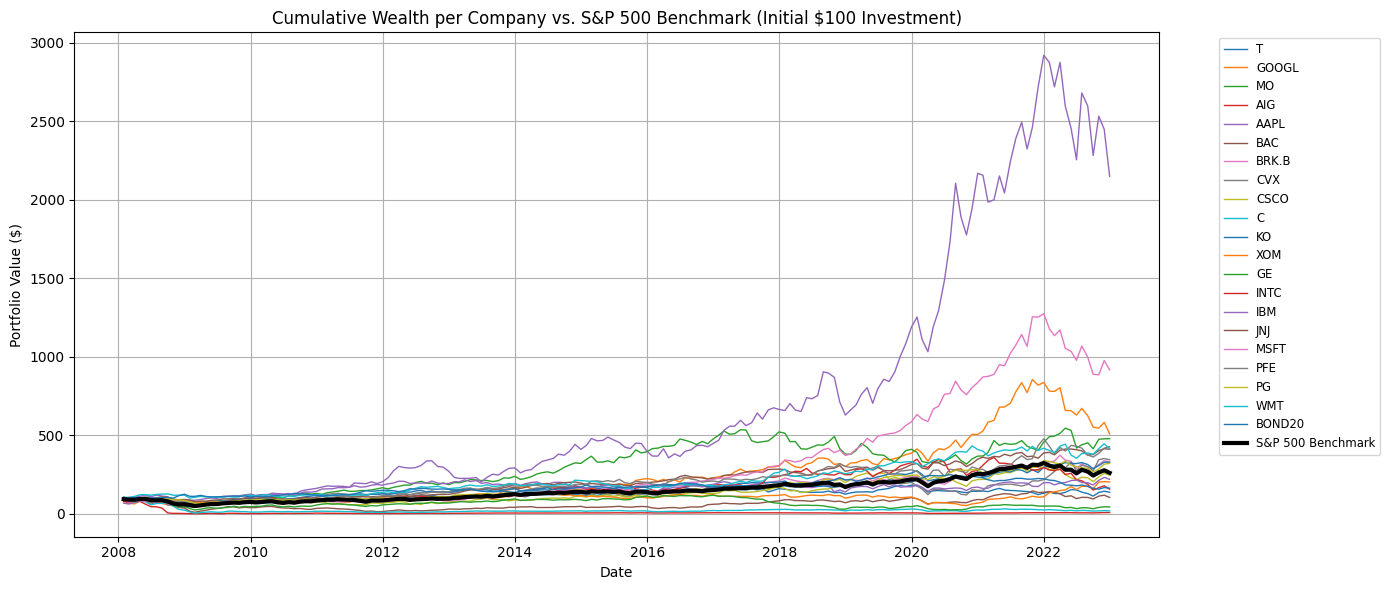

In [18]:
# Compute cumulative wealth ($100 initial investment)
wealth = (1 + returns).cumprod() * 100
benchmark_wealth = (1 + sp_benchmark["sprtrn"]).cumprod() * 100

# Plot
plt.figure(figsize=(14, 6))

# Plot each asset from its inception (first valid return)
for column in wealth.columns:
    series = wealth[column].dropna()
    plt.plot(series.index, series.values, label=column, linewidth=1)

# Plot benchmark with thicker black line
plt.plot(benchmark_wealth.index, benchmark_wealth, 
         label="S&P 500 Benchmark", linewidth=3, color='black')

# Formatting
plt.title("Cumulative Wealth per Company vs. S&P 500 Benchmark (Initial $100 Investment)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


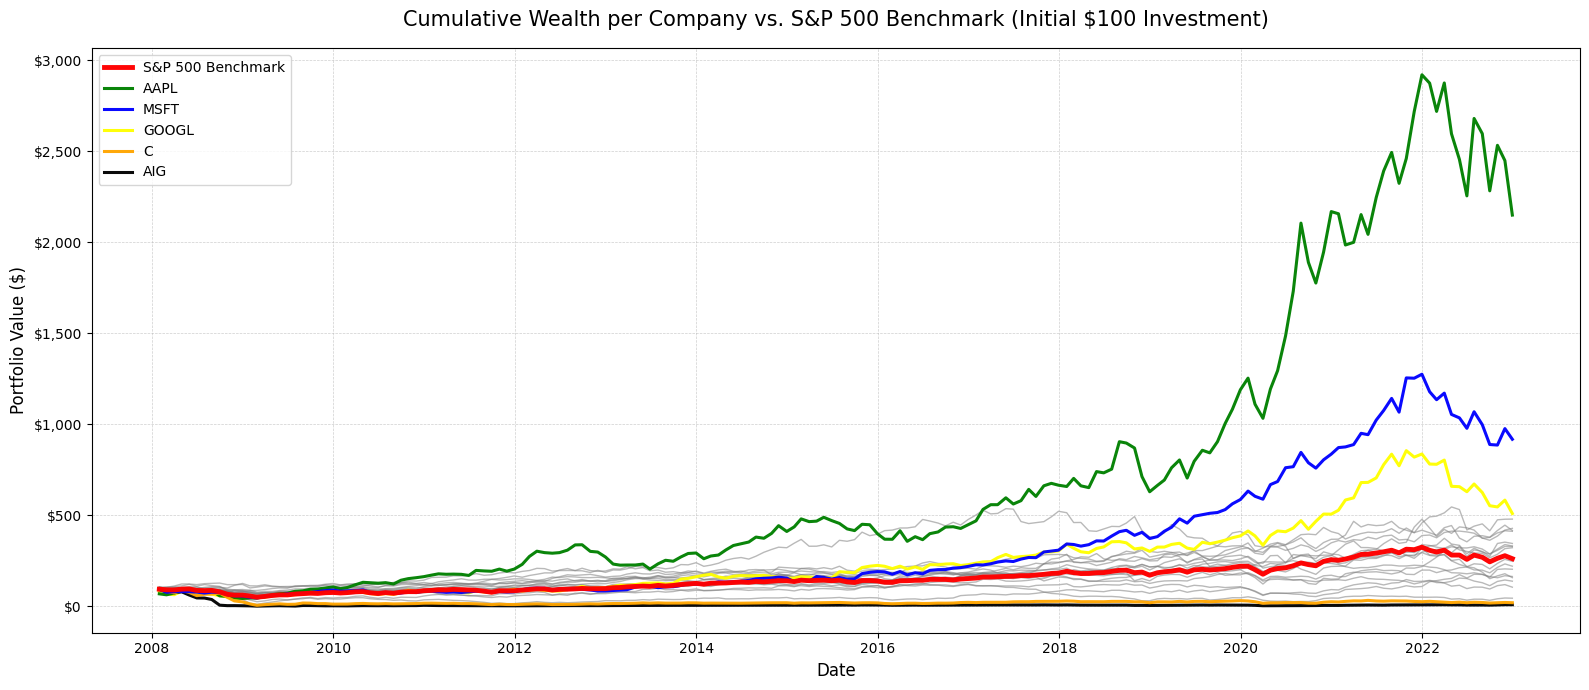

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Compute cumulative wealth ($100 initial investment)
wealth = (1 + returns).cumprod() * 100
benchmark_wealth = (1 + sp_benchmark["sprtrn"]).cumprod() * 100

plt.figure(figsize=(16, 7))
ax = plt.gca()

# Identify top 3 and bottom 2 performers at end of period
final_wealth = wealth.iloc[-1].sort_values(ascending=False)
best_label = final_wealth.index[0]
second_label = final_wealth.index[1]
third_label = final_wealth.index[2]
second_worst_label = final_wealth.index[-2]
worst_label = final_wealth.index[-1]

major_labels = [best_label, second_label, third_label, second_worst_label, worst_label]

# Assign desired colors
label_color_map = {
    best_label: 'green',           # best
    second_label: 'blue',          # second
    third_label: 'yellow',         # third
    second_worst_label: 'orange',  # second worst
    worst_label: 'black'           # worst
}
sp_label = "S&P 500 Benchmark"

# --- Store lines for legend explicitly ---
line_handles = {}

# Plot all assets: highlight top/bottom, rest are muted
for column in wealth.columns:
    series = wealth[column].dropna()
    if column in major_labels:
        color = label_color_map[column]
        line, = ax.plot(series.index, series.values,
                        linewidth=2.2, alpha=0.96, label=column, zorder=2, color=color)
        line_handles[column] = line
    else:
        ax.plot(series.index, series.values,
                linewidth=1, alpha=0.55, color='grey', zorder=1)

# Plot S&P 500 benchmark with thickest line and red color
sp500_line, = ax.plot(
    benchmark_wealth.index, benchmark_wealth,
    linewidth=3.5, color='red', alpha=0.98,
    label=sp_label, zorder=3
)

# Formatting
ax.set_title("Cumulative Wealth per Company vs. S&P 500 Benchmark (Initial $100 Investment)", fontsize=15, pad=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Portfolio Value ($)", fontsize=12)
ax.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.6)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Build custom legend: S&P 500 + top/bottom performers (in chosen order)
legend_handles = [sp500_line] + [line_handles[label] for label in major_labels]
legend_labels = [sp_label] + major_labels
ax.legend(legend_handles, legend_labels, loc='upper left', fontsize='medium', frameon=True)

plt.tight_layout()
plt.show()


In [20]:
# Create cumulative return table for assets
cumulative_returns_assets = (1 + returns).prod() - 1
cumulative_returns_assets_percent = cumulative_returns_assets * 100
cumulative_returns_assets_table = cumulative_returns_assets_percent.round(2).to_frame(name="Cumulative Return (%)")

# Create cumulative return for benchmark
benchmark_return = (1 + sp_benchmark["sprtrn"]).prod() - 1
benchmark_return_percent = benchmark_return * 100
benchmark_return_table = pd.DataFrame({"Cumulative Return (%)": [round(benchmark_return_percent, 2)]},
                                      index=["S&P 500 Benchmark"])

# Combine into one summary table
combined_cumulative_returns = pd.concat([cumulative_returns_assets_table, benchmark_return_table])
combined_cumulative_returns = combined_cumulative_returns.sort_values(by="Cumulative Return (%)", ascending=False)

combined_cumulative_returns

Cumulative Return (%)
AAPL                             2048.99
MSFT                              817.53
GOOGL                             409.59
MO                                378.99
PFE                               328.09
WMT                               316.35
JNJ                               311.91
CVX                               245.14
BRK.B                             231.01
KO                                228.95
PG                                221.80
S&P 500 Benchmark                 161.48
CSCO                              147.15
IBM                               120.29
XOM                               103.51
BOND20                             63.67
INTC                               57.31
T                                  37.98
BAC                                 4.90
GE                                -55.59
C                                 -80.31
AIG                               -91.35

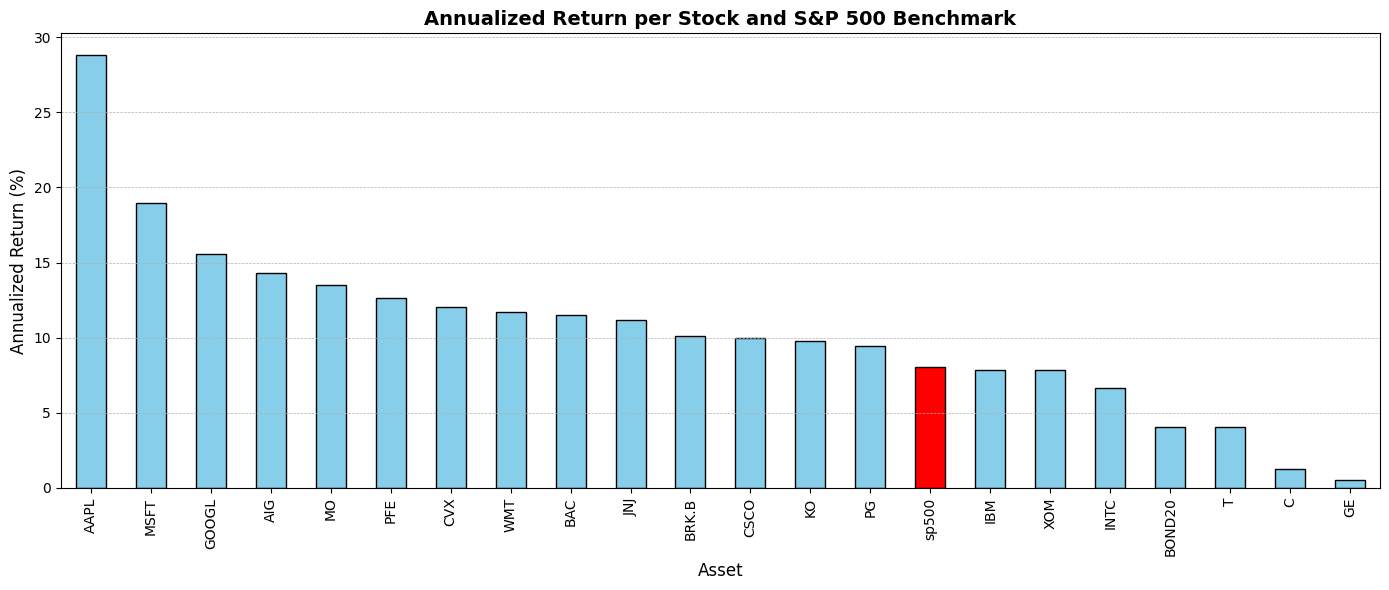

In [21]:
# Compute mean monthly returns for assets
mean_monthly_returns = returns.mean()

# Compute mean monthly return for the benchmark
benchmark_mean_monthly_return = sp_benchmark["sprtrn"].loc[returns.index].mean()

# Compute annualized returns
annualized_returns_assets = ((1 + mean_monthly_returns) ** 12 - 1) * 100
annualized_return_benchmark = ((1 + benchmark_mean_monthly_return) ** 12 - 1) * 100

# Combine into one Series with benchmark labeled 'sp500'
annualized_returns_combined = annualized_returns_assets.copy()
annualized_returns_combined["sp500"] = annualized_return_benchmark

# Sort descending
annualized_returns_combined = annualized_returns_combined.sort_values(ascending=False)

# Define color: red for 'sp500', blue for others
colors = ['red' if stock == 'sp500' else 'skyblue' for stock in annualized_returns_combined.index]

# Plot
plt.figure(figsize=(14, 6))
annualized_returns_combined.plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)
plt.title("Annualized Return per Stock and S&P 500 Benchmark", fontsize=14, weight='bold')
plt.xlabel("Asset", fontsize=12)
plt.ylabel("Annualized Return (%)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Excess Returns computation

In [22]:
rf = pd.read_csv("/Users/andreavento/Documents/Tesi/Dataset/3-month_T_bill.csv") 
rf

observation_date  DGS1MO
0          2001-07-31    3.67
1          2001-08-01    3.65
2          2001-08-02    3.65
3          2001-08-03    3.63
4          2001-08-06    3.62
...               ...     ...
6208       2025-05-16    4.37
6209       2025-05-19    4.37
6210       2025-05-20    4.36
6211       2025-05-21    4.35
6212       2025-05-22    4.37

[6213 rows x 2 columns]

In [23]:
rf.columns = ['Date', 'Yield']
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)
rf = rf.dropna()
rf

Yield
Date             
2001-07-31   3.67
2001-08-01   3.65
2001-08-02   3.65
2001-08-03   3.63
2001-08-06   3.62
...           ...
2025-05-16   4.37
2025-05-19   4.37
2025-05-20   4.36
2025-05-21   4.35
2025-05-22   4.37

[5955 rows x 1 columns]

In [24]:

# 2. Get end-of-month yields
rf_monthly = rf.resample('M').last()

# 3. Shift by one month to align with forward-looking return window
rf_monthly_shifted = rf_monthly.shift(1)

# 4. Convert annualized yield to monthly return (continuous compounding)
rf_monthly_shifted['rf_return'] = np.exp(rf_monthly_shifted['Yield'] / 100 / 12) - 1

# Define the desired date range
start_date = "2008-01-31"
end_date = "2022-12-31"

# Restrict the risk-free return series to that period
rf_final = rf_monthly_shifted.loc[start_date:end_date]

rf_final 

Yield  rf_return
Date                        
2008-01-31   2.76   0.002303
2008-02-29   1.64   0.001368
2008-03-31   2.07   0.001726
2008-04-30   1.22   0.001017
2008-05-31   1.17   0.000975
...           ...        ...
2022-08-31   2.22   0.001852
2022-09-30   2.40   0.002002
2022-10-31   2.79   0.002328
2022-11-30   3.73   0.003113
2022-12-31   4.07   0.003397

[180 rows x 2 columns]

In [25]:
rf_final_aligned = rf_final.reindex(returns.index, method='ffill')
rf_final_aligned

Yield  rf_return
2008-01-31   2.76   0.002303
2008-02-29   1.64   0.001368
2008-03-31   2.07   0.001726
2008-04-30   1.22   0.001017
2008-05-30   1.22   0.001017
...           ...        ...
2022-08-31   2.22   0.001852
2022-09-30   2.40   0.002002
2022-10-31   2.79   0.002328
2022-11-30   3.73   0.003113
2022-12-30   3.73   0.003113

[180 rows x 2 columns]

In [26]:
# Compute excess returns for each asset and the benchmark
excess_returns = returns.sub(rf_final_aligned['rf_return'], axis=0)

# Preview
excess_returns

T     GOOGL        MO       AIG      AAPL       BAC  \
2008-01-31 -0.066547 -0.186227  0.000476 -0.059421 -0.318943  0.067741   
2008-02-29 -0.096458 -0.166387 -0.036333 -0.148903 -0.077757 -0.101255   
2008-03-31  0.097901 -0.066903  0.003606 -0.074496  0.146090 -0.031671   
2008-04-30  0.020132  0.302795 -0.100116  0.067191  0.211178 -0.010777   
2008-05-30  0.029724  0.019025  0.111983 -0.221796  0.084065 -0.095050   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.067880 -0.071487  0.026876 -0.002238 -0.032989 -0.007767   
2022-09-30 -0.127430 -0.118154 -0.086222 -0.078331 -0.122979 -0.096914   
2022-10-31  0.204158 -0.014246  0.143536  0.198177  0.107223  0.191049   
2022-11-30  0.054484  0.065451  0.003587  0.104080 -0.036242  0.047109   
2022-12-30 -0.048238 -0.129462 -0.001610  0.004017 -0.125386 -0.122268   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2008-01-31 -0.041851 -0.110307 -0.097239 -0.034572  ... -0.080113 -0.048432   
2008-02-29  0.028044  0.046560 -0.005858 -0.159692  ...  0.009743 -0.055384   
2008-03-31 -0.048869 -0.016727 -0.014026 -0.098310  ... -0.029654  0.115051   
2008-04-30  0.002356  0.125389  0.063325  0.178722  ...  0.099361 -0.117472   
2008-05-30  0.004960  0.036945  0.041105 -0.122109  ... -0.043028 -0.061568   
...              ...       ...       ...       ...  ...       ...       ...   
2022-08-31 -0.069136 -0.028107 -0.016179 -0.061390  ... -0.006598 -0.008211   
2022-09-30 -0.037221 -0.093043 -0.107548 -0.148284  ... -0.088622 -0.157912   
2022-10-31  0.092587  0.256807  0.142922  0.098224  ...  0.266828  0.254496   
2022-11-30  0.076047  0.018059  0.091318  0.063612  ...  0.009882  0.101758   
2022-12-30 -0.027201 -0.023952 -0.044947 -0.068802  ... -0.012454 -0.027540   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2008-01-31 -0.210855 -0.011461 -0.055676 -0.086573  0.025414 -0.106498   
2008-02-29 -0.048885  0.065386 -0.013484 -0.163641 -0.033902  0.010249   
2008-03-31  0.058870  0.009516  0.045240  0.041660 -0.062318  0.057053   
2008-04-30  0.049974  0.047272  0.033205  0.003916 -0.040195 -0.038408   
2008-05-30  0.046602  0.075454  0.000623 -0.004173 -0.022399 -0.015931   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.112703 -0.007128 -0.070899 -0.068284 -0.106386 -0.008835   
2022-09-30 -0.194671 -0.077051  0.010518 -0.111269 -0.034503 -0.086749   
2022-10-31  0.100893  0.161631  0.062621 -0.005634  0.061429  0.071599   
2022-11-30  0.067411  0.085541  0.026547  0.098942  0.082387  0.104483   
2022-12-30 -0.124164 -0.056907 -0.010697 -0.063158  0.019029  0.012977   

                 WMT    BOND20  
2008-01-31  0.065233  0.023386  
2008-02-29 -0.024033 -0.000964  
2008-03-31  0.065374  0.010316  
2008-04-30  0.099590 -0.019890  
2008-05-30 -0.001060 -0.030622  
...              ...       ...  
2022-08-31  0.006175 -0.048701  
2022-09-30 -0.023503 -0.069947  
2022-10-31  0.095051 -0.043420  
2022-11-30  0.067779  0.068095  
2022-12-30 -0.069180 -0.028885  

[180 rows x 21 columns]

Benchmark metrics adjusted for excess return

In [27]:
benchmark_rf = rf_final_aligned['rf_return']
benchmark_excess_returns = benchmark_returns - benchmark_rf
cumulative_return_sp500 = (1 + benchmark_returns).prod() - 1

# Metrics on excess returns
mean_monthly_sp500 = benchmark_excess_returns.mean()
volatility_sp500 = benchmark_excess_returns.std()
sharpe_sp500 = mean_monthly_sp500 / volatility_sp500 * np.sqrt(12)
annualized_return_sp500 = ((1 + mean_monthly_sp500) ** 12 - 1) * 100

benchmark_metrics = pd.DataFrame({
    "Total Cumulative Return": [cumulative_return_sp500],
    "Mean Monthly Return": [mean_monthly_sp500],
    "Volatility (Monthly Std)": [volatility_sp500],
    "Annualized Sharpe Ratio": [sharpe_sp500],
    "Annualized Return %": [annualized_return_sp500],
    "Average HHI": [np.nan],
    "HHI Std Dev": [np.nan],
    "Avg Rolling Weight Std Dev": [np.nan],
    "Average Turnover": [0],
    "Turnover Std Dev": [0]
}, index=["S&P 500"])

## Excess return computation of previous data (to be used later) 2000-2007. 

In [29]:
historical_df = pd.read_csv('../Data/historical_before2008_returns.csv', index_col=0, parse_dates=True)
historical_df = historical_df[24::].copy()
historical_df = historical_df[returns.columns]
historical_df

T     GOOGL        MO       AIG      AAPL       BAC  \
2002-01-31 -0.037369       NaN  0.092912 -0.066121  0.128767  0.001271   
2002-02-28  0.010414       NaN  0.050888 -0.001861 -0.122168  0.024116   
2002-03-28 -0.010571       NaN  0.011204 -0.024740  0.090783  0.063643   
2002-04-30 -0.163194       NaN  0.033416 -0.041863  0.025349  0.065569   
2002-05-31  0.103992       NaN  0.051810 -0.031105 -0.039967  0.045944   
...              ...       ...       ...       ...       ...       ...   
2007-08-31  0.018131  0.010294  0.044231  0.028358  0.051002  0.068747   
2007-09-28  0.061199  0.100961  0.012534  0.028030  0.108247  0.004538   
2007-10-31 -0.003900  0.246320  0.048900 -0.066962  0.237701 -0.039586   
2007-11-30 -0.085666 -0.019802  0.063485 -0.079056 -0.040695 -0.044532   
2007-12-31  0.087673 -0.002193 -0.015859  0.006365  0.087038 -0.091697   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2002-01-31 -0.025501 -0.064836  0.093319 -0.057845  ... -0.006361 -0.073104   
2002-02-28 -0.011797  0.015990 -0.279293 -0.045359  ...  0.063508  0.041184   
2002-03-28 -0.024560  0.069043  0.186405  0.094365  ...  0.061259 -0.027273   
2002-04-30  0.030034 -0.039437 -0.134672 -0.125606  ... -0.083505 -0.157543   
2002-05-31  0.015843  0.014301  0.077133  0.001386  ... -0.000249 -0.012995   
...              ...       ...       ...       ...  ...       ...       ...   
2007-08-31  0.077814  0.036125  0.104116  0.018252  ...  0.011159  0.002838   
2007-09-28  0.008476  0.066317  0.037904 -0.004480  ...  0.079669  0.072292   
2007-10-31  0.117476 -0.022120 -0.002110 -0.102207  ... -0.006158 -0.005797   
2007-11-30  0.059943 -0.034532 -0.152450 -0.192363  ... -0.026959 -0.069728   
2007-12-31  0.010257  0.063347 -0.033908 -0.115916  ...  0.050808 -0.023766   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2002-01-31  0.114149 -0.108052 -0.026904 -0.038340  0.045671  0.037028   
2002-02-28 -0.184646 -0.089258  0.062076 -0.084288 -0.013919  0.038075   
2002-03-28  0.065149  0.059927  0.066502  0.033768 -0.029785  0.062507   
2002-04-30 -0.059191 -0.194615 -0.016782 -0.133477 -0.085305  0.006105   
2002-05-31 -0.033904 -0.037727 -0.036095 -0.025832 -0.044567 -0.007866   
...              ...       ...       ...       ...       ...       ...   
2007-08-31  0.094941  0.058202  0.028182 -0.005519  0.068907  0.055771   
2007-09-28  0.004272  0.009512  0.063279  0.025409 -0.016506  0.077017   
2007-10-31  0.040217 -0.014261 -0.008067  0.249491  0.007368 -0.006682   
2007-11-30 -0.026301 -0.090768  0.045803 -0.084216 -0.022755  0.064442   
2007-12-31  0.022239  0.027762 -0.015353  0.059524 -0.043350 -0.007838   

                 WMT    BOND20  
2002-01-31  0.042224  0.011488  
2002-02-28  0.033845  0.012538  
2002-03-28 -0.010240 -0.040447  
2002-04-30 -0.088744  0.040135  
2002-05-31 -0.031507  0.001533  
...              ...       ...  
2007-08-31 -0.045702  0.017484  
2007-09-28  0.000458  0.001447  
2007-10-31  0.035739  0.015780  
2007-11-30  0.059500  0.048778  
2007-12-31 -0.003132 -0.006067  

[72 rows x 21 columns]

Google has NAs because it wasn't public yet

Risk free rate for that period

In [33]:
rf_1 = pd.read_csv('../Data/DGS1MO-2.csv')
rf_1

observation_date  DGS1MO
0          2001-07-31    3.67
1          2001-08-01    3.65
2          2001-08-02    3.65
3          2001-08-03    3.63
4          2001-08-06    3.62
...               ...     ...
6211       2025-05-21    4.35
6212       2025-05-22    4.37
6213       2025-05-23    4.36
6214       2025-05-26     NaN
6215       2025-05-27    4.35

[6216 rows x 2 columns]

In [34]:
rf_1.columns = ['Date', 'Yield']
rf_1['Date'] = pd.to_datetime(rf_1['Date'])
rf_1.set_index('Date', inplace=True)
rf_1 = rf_1.dropna()
rf_1

Yield
Date             
2001-07-31   3.67
2001-08-01   3.65
2001-08-02   3.65
2001-08-03   3.63
2001-08-06   3.62
...           ...
2025-05-20   4.36
2025-05-21   4.35
2025-05-22   4.37
2025-05-23   4.36
2025-05-27   4.35

[5957 rows x 1 columns]

In [35]:

# 2. Get end-of-month yields
rf_1_monthly = rf_1.resample('M').last()

# 3. Shift by one month to align with forward-looking return window
rf_1_monthly_shifted = rf_1_monthly.shift(1)

# 4. Convert annualized yield to monthly return (continuous compounding)
rf_1_monthly_shifted['rf_return'] = np.exp(rf_1_monthly_shifted['Yield'] / 100 / 12) - 1

# Define the desired date range
start_date_1 = "2002-01-31"
end_date_1 = "2007-12-31"

# Restrict the risk-free return series to that period
rf_1_final = rf_1_monthly_shifted.loc[start_date_1:end_date_1]

rf_final_1_aligned = rf_1_final.reindex(historical_df.index, method='ffill')
rf_final_1_aligned


Yield  rf_return
2002-01-31   1.68   0.001401
2002-02-28   1.69   0.001409
2002-03-28   1.69   0.001409
2002-04-30   1.76   0.001468
2002-05-31   1.77   0.001476
...           ...        ...
2007-08-31   5.13   0.004284
2007-09-28   5.13   0.004284
2007-10-31   3.43   0.002862
2007-11-30   4.01   0.003347
2007-12-31   3.63   0.003030

[72 rows x 2 columns]

Obtaining excess returns for the historical period

In [36]:
# Compute excess returns for each asset and the benchmark
historical_excess_returns = historical_df.sub(rf_final_1_aligned['rf_return'], axis=0)

# Preview
historical_excess_returns

T     GOOGL        MO       AIG      AAPL       BAC  \
2002-01-31 -0.038770       NaN  0.091511 -0.067522  0.127366 -0.000130   
2002-02-28  0.009005       NaN  0.049479 -0.003270 -0.123577  0.022707   
2002-03-28 -0.011980       NaN  0.009795 -0.026149  0.089374  0.062234   
2002-04-30 -0.164662       NaN  0.031948 -0.043331  0.023881  0.064101   
2002-05-31  0.102516       NaN  0.050334 -0.032581 -0.041443  0.044468   
...              ...       ...       ...       ...       ...       ...   
2007-08-31  0.013847  0.006010  0.039947  0.024074  0.046718  0.064463   
2007-09-28  0.056915  0.096677  0.008250  0.023746  0.103963  0.000254   
2007-10-31 -0.006762  0.243458  0.046038 -0.069824  0.234839 -0.042448   
2007-11-30 -0.089013 -0.023149  0.060138 -0.082403 -0.044042 -0.047879   
2007-12-31  0.084643 -0.005223 -0.018889  0.003335  0.084008 -0.094727   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2002-01-31 -0.026902 -0.066237  0.091918 -0.059246  ... -0.007762 -0.074505   
2002-02-28 -0.013206  0.014581 -0.280702 -0.046768  ...  0.062099  0.039775   
2002-03-28 -0.025969  0.067634  0.184996  0.092956  ...  0.059850 -0.028682   
2002-04-30  0.028566 -0.040905 -0.136140 -0.127074  ... -0.084973 -0.159011   
2002-05-31  0.014367  0.012825  0.075657 -0.000090  ... -0.001725 -0.014471   
...              ...       ...       ...       ...  ...       ...       ...   
2007-08-31  0.073530  0.031841  0.099832  0.013968  ...  0.006875 -0.001446   
2007-09-28  0.004192  0.062033  0.033620 -0.008764  ...  0.075385  0.068008   
2007-10-31  0.114614 -0.024982 -0.004972 -0.105069  ... -0.009020 -0.008659   
2007-11-30  0.056596 -0.037879 -0.155797 -0.195710  ... -0.030306 -0.073075   
2007-12-31  0.007228  0.060317 -0.036938 -0.118946  ...  0.047778 -0.026796   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2002-01-31  0.112748 -0.109453 -0.028305 -0.039741  0.044270  0.035627   
2002-02-28 -0.186055 -0.090667  0.060667 -0.085697 -0.015328  0.036666   
2002-03-28  0.063740  0.058518  0.065093  0.032359 -0.031194  0.061098   
2002-04-30 -0.060659 -0.196083 -0.018250 -0.134945 -0.086773  0.004637   
2002-05-31 -0.035380 -0.039203 -0.037571 -0.027308 -0.046043 -0.009342   
...              ...       ...       ...       ...       ...       ...   
2007-08-31  0.090657  0.053918  0.023898 -0.009803  0.064623  0.051487   
2007-09-28 -0.000012  0.005228  0.058995  0.021125 -0.020790  0.072733   
2007-10-31  0.037355 -0.017123 -0.010929  0.246629  0.004506 -0.009544   
2007-11-30 -0.029648 -0.094115  0.042456 -0.087563 -0.026102  0.061095   
2007-12-31  0.019209  0.024732 -0.018383  0.056494 -0.046380 -0.010868   

                 WMT    BOND20  
2002-01-31  0.040823  0.010087  
2002-02-28  0.032436  0.011129  
2002-03-28 -0.011649 -0.041856  
2002-04-30 -0.090212  0.038667  
2002-05-31 -0.032983  0.000057  
...              ...       ...  
2007-08-31 -0.049986  0.013200  
2007-09-28 -0.003826 -0.002837  
2007-10-31  0.032877  0.012918  
2007-11-30  0.056153  0.045431  
2007-12-31 -0.006162 -0.009097  

[72 rows x 21 columns]

In [37]:

# Calculate the average mean and variance of the average asset in historical_excess_returns
average_mean_historical_pre2008 = historical_excess_returns.mean(axis=1).mean()
average_variance_historical_pre2008 = historical_excess_returns.var(axis=1).mean()
average_mean_historical_pre2008, average_variance_historical_pre2008

# Calculate the sample covariance matrix of the historical excess returns
sample_historical_covariance = historical_excess_returns.cov()
sample_historical_covariance

T     GOOGL        MO       AIG      AAPL       BAC     BRK.B  \
T       0.005508 -0.000286  0.001605  0.002361  0.001410  0.000999  0.000458   
GOOGL  -0.000286  0.014522 -0.000150 -0.000848  0.005028  0.000552  0.000486   
MO      0.001605 -0.000150  0.006527  0.000112  0.002971  0.000883  0.001033   
AIG     0.002361 -0.000848  0.000112  0.004038  0.001215  0.001226  0.000435   
AAPL    0.001410  0.005028  0.002971  0.001215  0.012233  0.000973  0.000303   
BAC     0.000999  0.000552  0.000883  0.001226  0.000973  0.001701  0.000170   
BRK.B   0.000458  0.000486  0.001033  0.000435  0.000303  0.000170  0.001532   
CVX     0.001151 -0.000393  0.001185  0.001099  0.002401  0.000258  0.000014   
CSCO    0.002643  0.001068  0.000963  0.002169  0.002071  0.001129  0.000231   
C       0.002804  0.000664  0.001007  0.002429  0.001403  0.001758  0.000298   
KO      0.000642 -0.000035  0.001135  0.000534  0.000790  0.000420  0.000441   
XOM     0.001554 -0.000390  0.000530  0.001104  0.002099  0.000262 -0.000076   
GE      0.001688  0.000428  0.000321  0.001381  0.000199  0.000515  0.000256   
INTC    0.002705  0.002857  0.001788  0.002172  0.004954  0.001073  0.000575   
IBM     0.003520  0.000201  0.001295  0.002358  0.002380  0.000900  0.000607   
JNJ     0.000478  0.000001  0.000334  0.000454  0.000330  0.000444  0.000358   
MSFT    0.002437  0.002466 -0.000004  0.001545  0.001928  0.000404  0.000416   
PFE     0.001370 -0.001223  0.000825  0.000995  0.000365  0.000712 -0.000055   
PG      0.000212 -0.000744  0.000300  0.000395  0.000102  0.000083  0.000144   
WMT     0.000664  0.000820 -0.000753  0.000949 -0.000058  0.000111  0.000480   
BOND20 -0.000569  0.000243  0.000437 -0.000572 -0.000377 -0.000090  0.000086   

             CVX      CSCO         C  ...       XOM        GE      INTC  \
T       0.001151  0.002643  0.002804  ...  0.001554  0.001688  0.002705   
GOOGL  -0.000393  0.001068  0.000664  ... -0.000390  0.000428  0.002857   
MO      0.001185  0.000963  0.001007  ...  0.000530  0.000321  0.001788   
AIG     0.001099  0.002169  0.002429  ...  0.001104  0.001381  0.002172   
AAPL    0.002401  0.002071  0.001403  ...  0.002099  0.000199  0.004954   
BAC     0.000258  0.001129  0.001758  ...  0.000262  0.000515  0.001073   
BRK.B   0.000014  0.000231  0.000298  ... -0.000076  0.000256  0.000575   
CVX     0.002950  0.000716  0.000678  ...  0.002333  0.000229  0.000300   
CSCO    0.000716  0.009475  0.003084  ...  0.000666  0.002050  0.006457   
C       0.000678  0.003084  0.004580  ...  0.000738  0.001454  0.002874   
KO      0.000983  0.000590  0.000742  ...  0.000694  0.000014  0.000557   
XOM     0.002333  0.000666  0.000738  ...  0.002841  0.000609  0.000618   
GE      0.000229  0.002050  0.001454  ...  0.000609  0.002830  0.001991   
INTC    0.000300  0.006457  0.002874  ...  0.000618  0.001991  0.010702   
IBM     0.001053  0.003995  0.003231  ...  0.001352  0.002200  0.004230   
JNJ     0.000049 -0.000068  0.000845  ...  0.000281  0.000616  0.000967   
MSFT    0.000715  0.002485  0.001733  ...  0.001101  0.001260  0.002112   
PFE     0.000858  0.001432  0.001208  ...  0.001079  0.000208  0.000848   
PG      0.000183  0.000050  0.000285  ...  0.000254  0.000009  0.000022   
WMT    -0.000218  0.000473  0.000847  ... -0.000010  0.000532  0.001008   
BOND20 -0.000244 -0.000677 -0.000515  ... -0.000346 -0.000284 -0.000776   

             IBM       JNJ      MSFT       PFE        PG       WMT    BOND20  
T       0.003520  0.000478  0.002437  0.001370  0.000212  0.000664 -0.000569  
GOOGL   0.000201  0.000001  0.002466 -0.001223 -0.000744  0.000820  0.000243  
MO      0.001295  0.000334 -0.000004  0.000825  0.000300 -0.000753  0.000437  
AIG     0.002358  0.000454  0.001545  0.000995  0.000395  0.000949 -0.000572  
AAPL    0.002380  0.000330  0.001928  0.000365  0.000102 -0.000058 -0.000377  
BAC     0.000900  0.000444  0.000404  0.000712  0.000083  0.000111 -0.000090  
BRK.B   0.000607  0.000358  0.000416 -0.000055  0.

Historical SP500 returns (2002-2007)

In [39]:

sp500_pre = pd.read_csv('../Data/SP_500_benchmark_presample.csv', index_col=0, parse_dates=True)

# Filter for the 2002–2007 period
sp500_pre_filtered = sp500_pre.loc['2002-01-31':'2007-12-31']
sp500_pre_filtered = sp500_pre_filtered.rename(columns={'sprtrn': 'sp500_return'})
sp500_pre_filtered


sp500_return
caldt                   
2002-01-31     -0.015574
2002-02-28     -0.020766
2002-03-28      0.036739
2002-04-30     -0.061418
2002-05-31     -0.009081
...                  ...
2007-08-31      0.012864
2007-09-28      0.035794
2007-10-31      0.014822
2007-11-30     -0.044043
2007-12-31     -0.008628

[72 rows x 1 columns]

In [40]:
excess_sp500_pre = sp500_pre_filtered.sub(rf_final_1_aligned['rf_return'], axis=0)


excess_sp500_pre.columns.name = None
excess_sp500_pre.index.name = None

# Make sure index is datetime
excess_sp500_pre.index = pd.to_datetime(excess_sp500_pre.index)
excess_sp500_pre

sp500_return
2002-01-31     -0.016975
2002-02-28     -0.022175
2002-03-28      0.035330
2002-04-30     -0.062886
2002-05-31     -0.010557
...                  ...
2007-08-31      0.008580
2007-09-28      0.031510
2007-10-31      0.011960
2007-11-30     -0.047390
2007-12-31     -0.011658

[72 rows x 1 columns]

## EDA

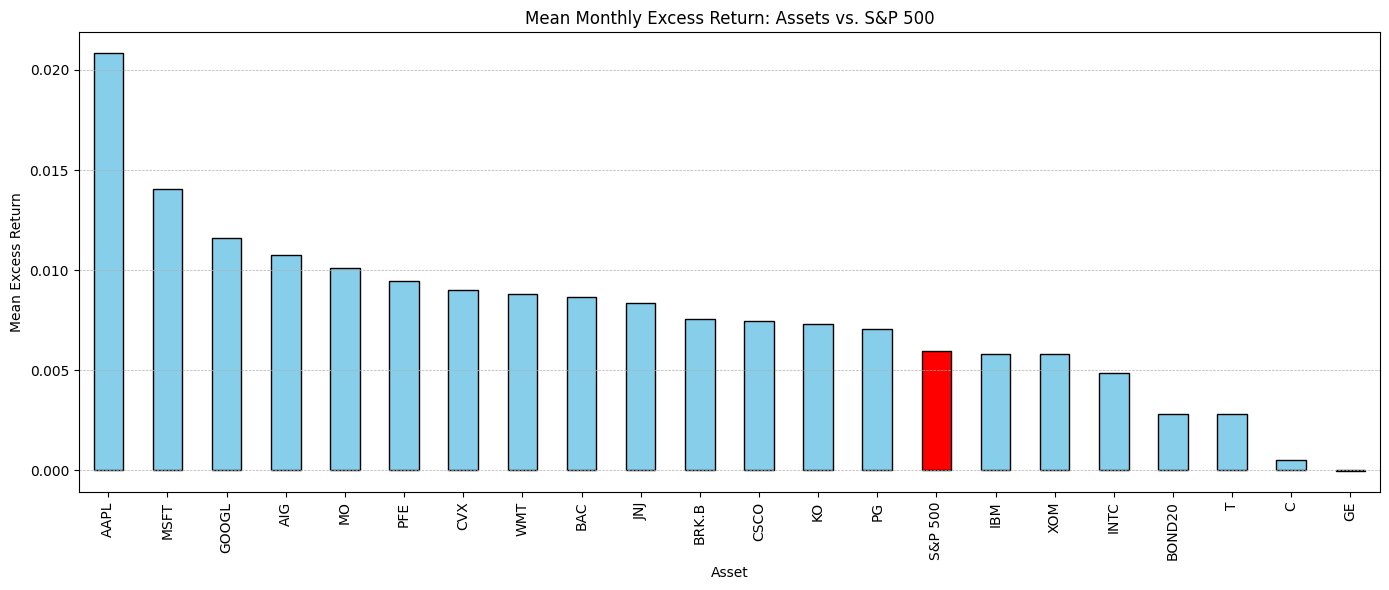

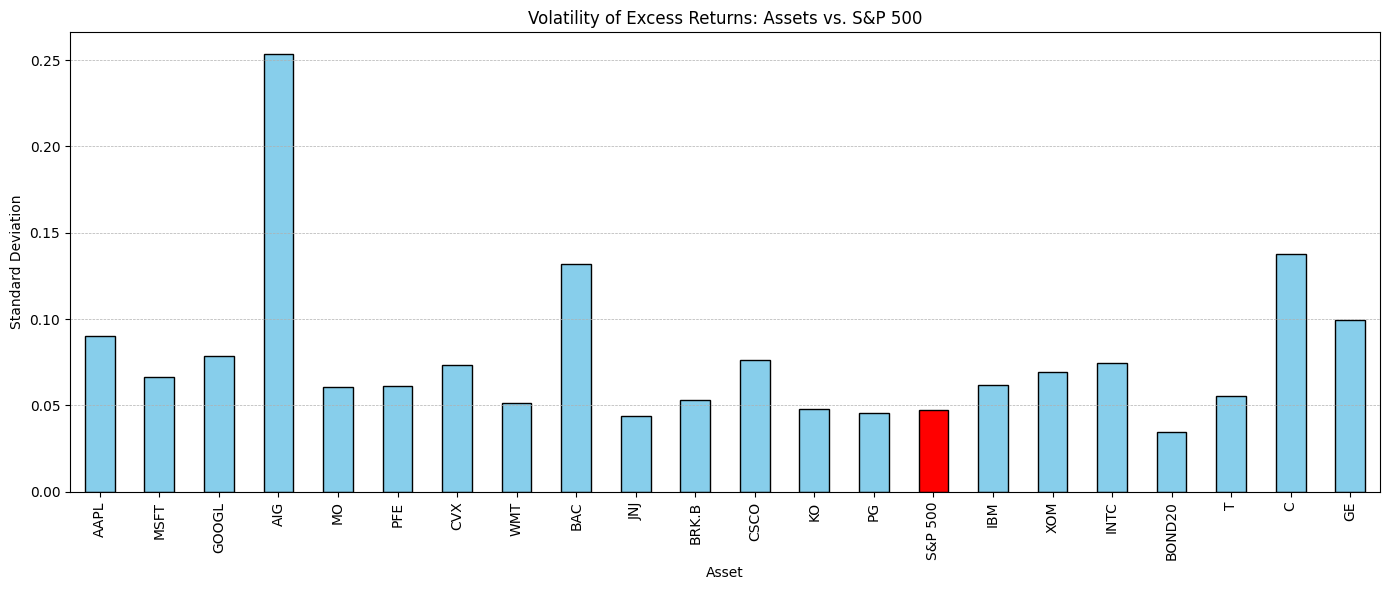

In [41]:
# Step 1: Compute metrics
mean_excess = excess_returns.mean()
volatility_excess = excess_returns.std()

# Append benchmark
mean_excess["S&P 500"] = benchmark_excess_returns.mean()
volatility_excess["S&P 500"] = benchmark_excess_returns.std()

# Step 2: Sort by mean excess return
sorted_mean = mean_excess.sort_values(ascending=False)
sorted_volatility = volatility_excess[sorted_mean.index]  # match order

# Step 3: Define color scheme
colors = ['red' if asset == 'S&P 500' else 'skyblue' for asset in sorted_mean.index]

# Step 4: Plot mean excess returns
plt.figure(figsize=(14, 6))
sorted_mean.plot(kind='bar', color=colors, edgecolor='black')
plt.title("Mean Monthly Excess Return: Assets vs. S&P 500")
plt.ylabel("Mean Excess Return")
plt.xlabel("Asset")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Step 5: Plot volatility of excess returns
plt.figure(figsize=(14, 6))
sorted_volatility.plot(kind='bar', color=colors, edgecolor='black')
plt.title("Volatility of Excess Returns: Assets vs. S&P 500")
plt.ylabel("Standard Deviation")
plt.xlabel("Asset")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

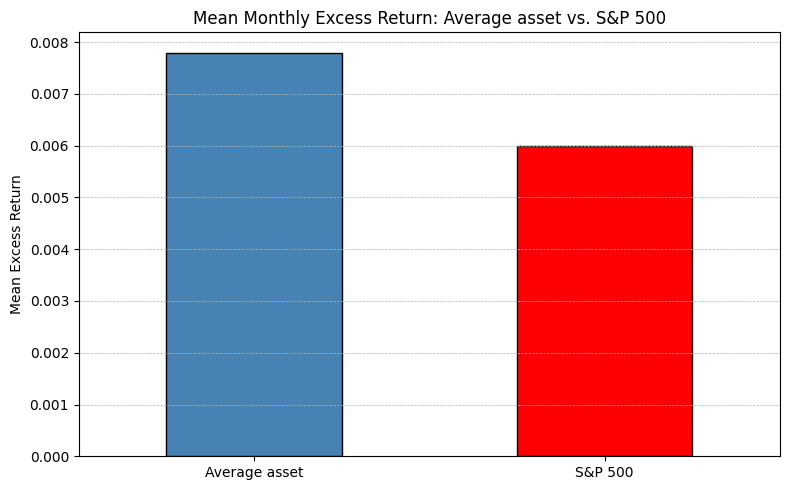

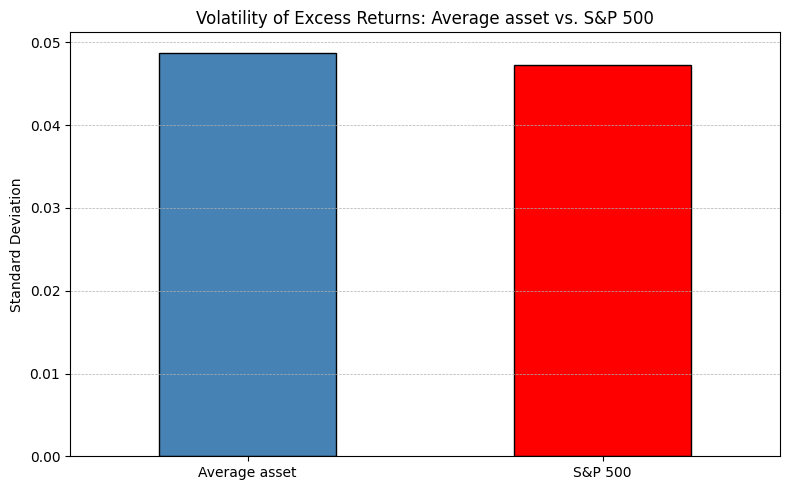

In [42]:

# Step 1: Create equal-weighted portfolio from excess returns
equal_weights = np.repeat(1 / excess_returns.shape[1], excess_returns.shape[1])
portfolio_excess_returns = excess_returns.dot(equal_weights)

# Step 2: Compute mean and std deviation (monthly)
portfolio_mean = portfolio_excess_returns.mean()
portfolio_std = portfolio_excess_returns.std()

benchmark_mean = benchmark_excess_returns.mean()
benchmark_std = benchmark_excess_returns.std()

# Step 3: Create summary DataFrame
comparison_df = pd.DataFrame({
    'Mean Monthly Excess Return': [portfolio_mean, benchmark_mean],
    'Standard Deviation': [portfolio_std, benchmark_std]
}, index=['Average asset', 'S&P 500'])

# Step 4: Plot - Mean Monthly Excess Return
plt.figure(figsize=(8, 5))
comparison_df['Mean Monthly Excess Return'].plot(kind='bar', color=['steelblue', 'red'], edgecolor='black')
plt.title("Mean Monthly Excess Return: Average asset vs. S&P 500")
plt.ylabel("Mean Excess Return")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Step 5: Plot - Standard Deviation
plt.figure(figsize=(8, 5))
comparison_df['Standard Deviation'].plot(kind='bar', color=['steelblue', 'red'], edgecolor='black')
plt.title("Volatility of Excess Returns: Average asset vs. S&P 500")
plt.ylabel("Standard Deviation")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Markowitz pain points

Classical MVO treats the estimated means and covariances of asset returns as if they were the true parameters. This creates a false sense of certainty in portfolio optimization. In reality, these inputs are noisy estimates from finite samples, especially for expected returns, which exhibit high variability over time. The optimizer treats these point estimates as exact, leading to portfolios that are optimal only under a narrow and often unrealistic view of the world. This failure to account for estimation risk results in portfolio recommendations that are highly vulnerable to input noise.

### Normality Assumption

MVO assumes returns are normally distributed, ignoring fat tails, skewness, and extreme events common in real markets. This underestimates tail risks and can mislead risk assessments

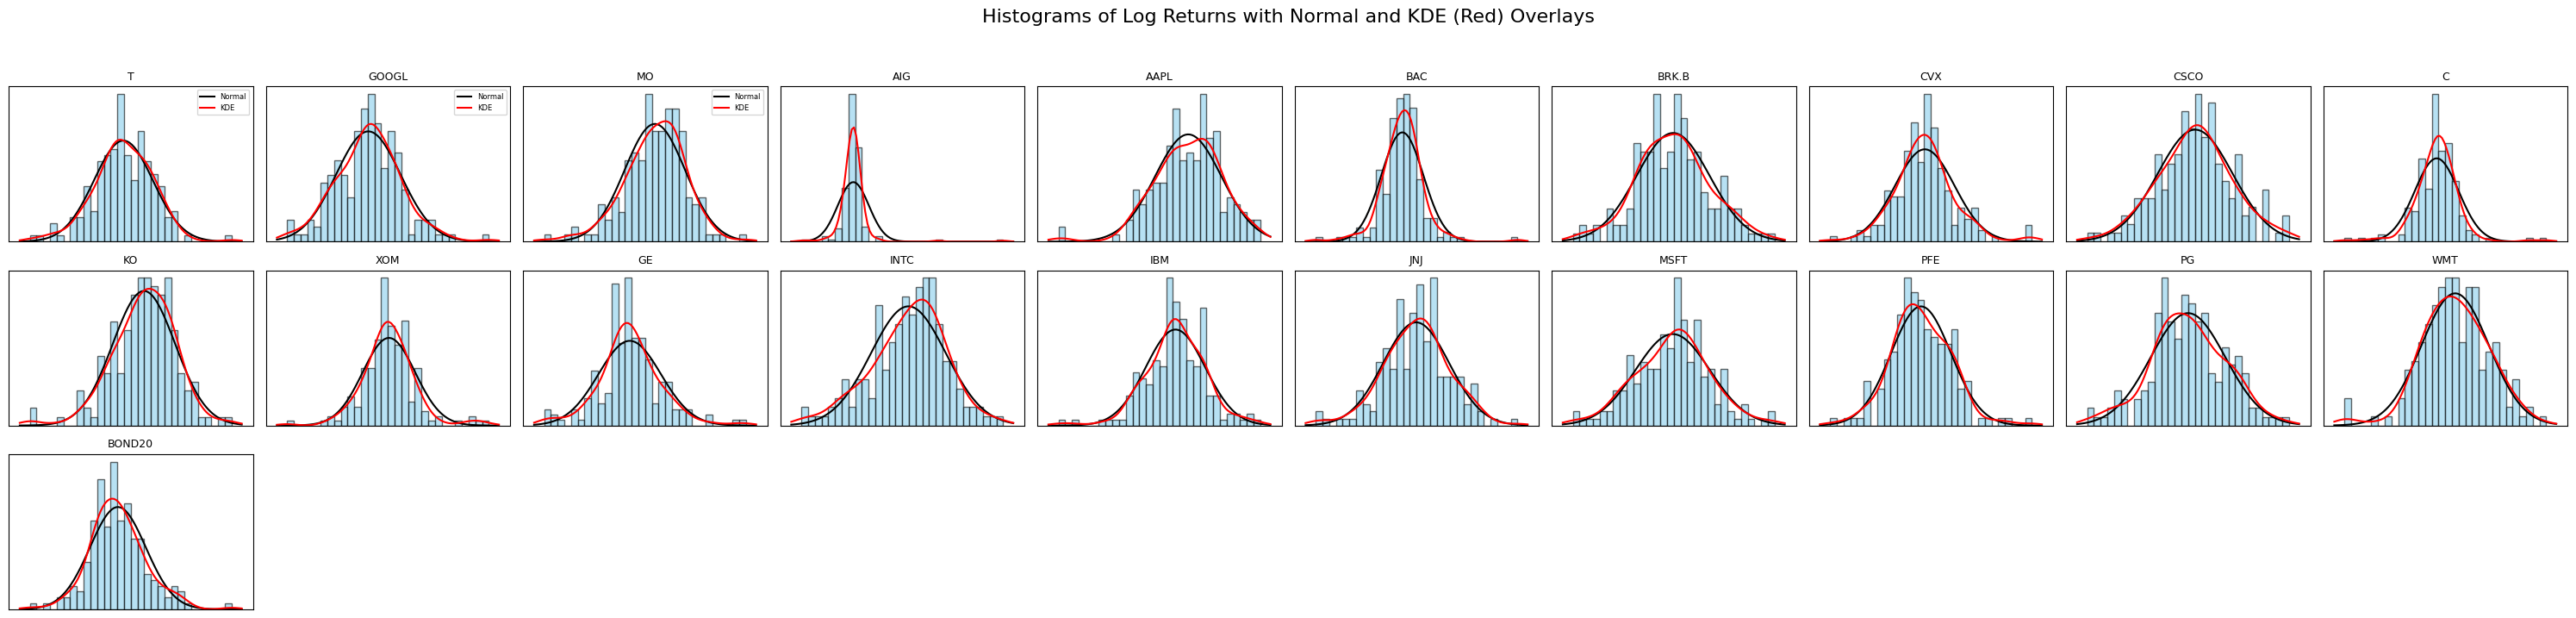

In [43]:
# Compute log returns
returns_1 = returns.copy()

# Plot histograms
# Grid size setup
num_assets = returns_1.shape[1]
ncols = 10
nrows = int(np.ceil(num_assets / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 2.5))
axes = axes.flatten()

for i, col in enumerate(returns_1.columns):
    data = returns_1[col].dropna()
    ax = axes[i]
    
    # Histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # Normal distribution overlay
    mu, std = data.mean(), data.std()
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=1.5, label='Normal')
    
    # KDE overlay (best empirical fit in red)
    kde = stats.gaussian_kde(data)
    ax.plot(x, kde(x), 'r-', linewidth=1.5, label='KDE')

    ax.set_title(col, fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Optional: show legend on first few plots
    if i < 3:
        ax.legend(fontsize=6)

# Turn off unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histograms of Log Returns with Normal and KDE (Red) Overlays", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


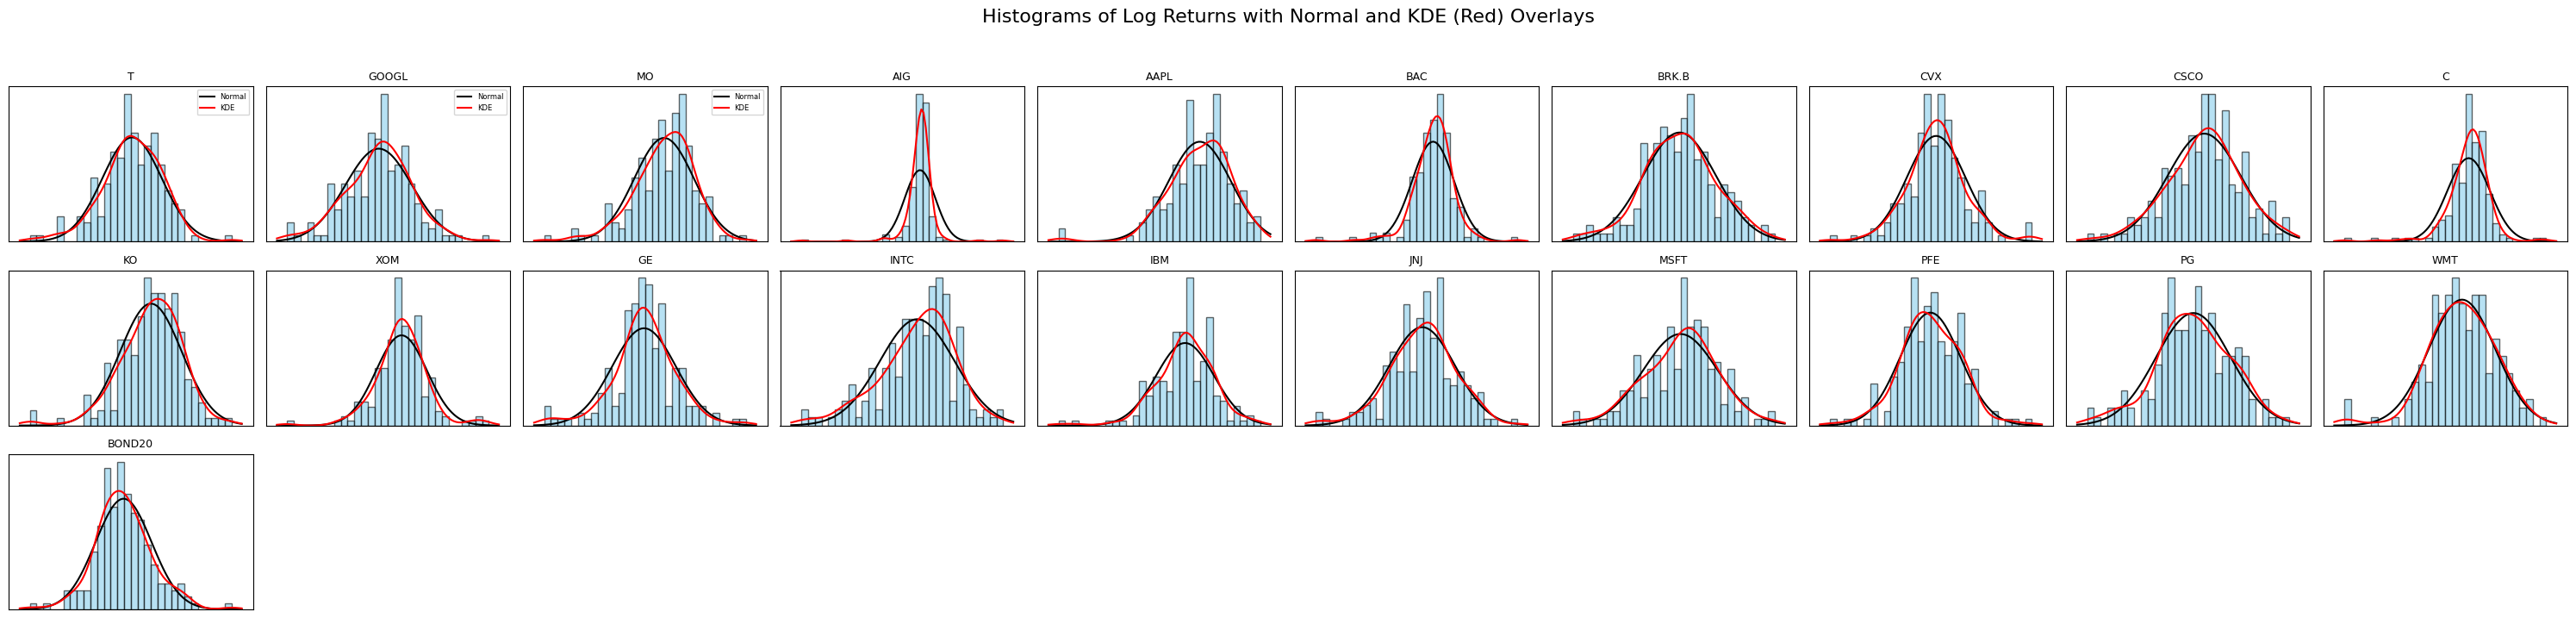

In [44]:
# Compute log returns
log_returns = np.log(1 + returns)

# Plot histograms
# Grid size setup
num_assets = log_returns.shape[1]
ncols = 10
nrows = int(np.ceil(num_assets / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 2.5))
axes = axes.flatten()

for i, col in enumerate(log_returns.columns):
    data = log_returns[col].dropna()
    ax = axes[i]
    
    # Histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    # Normal distribution overlay
    mu, std = data.mean(), data.std()
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=1.5, label='Normal')
    
    # KDE overlay (best empirical fit in red)
    kde = stats.gaussian_kde(data)
    ax.plot(x, kde(x), 'r-', linewidth=1.5, label='KDE')

    ax.set_title(col, fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Optional: show legend on first few plots
    if i < 3:
        ax.legend(fontsize=6)

# Turn off unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Histograms of Log Returns with Normal and KDE (Red) Overlays", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Image for the thesis

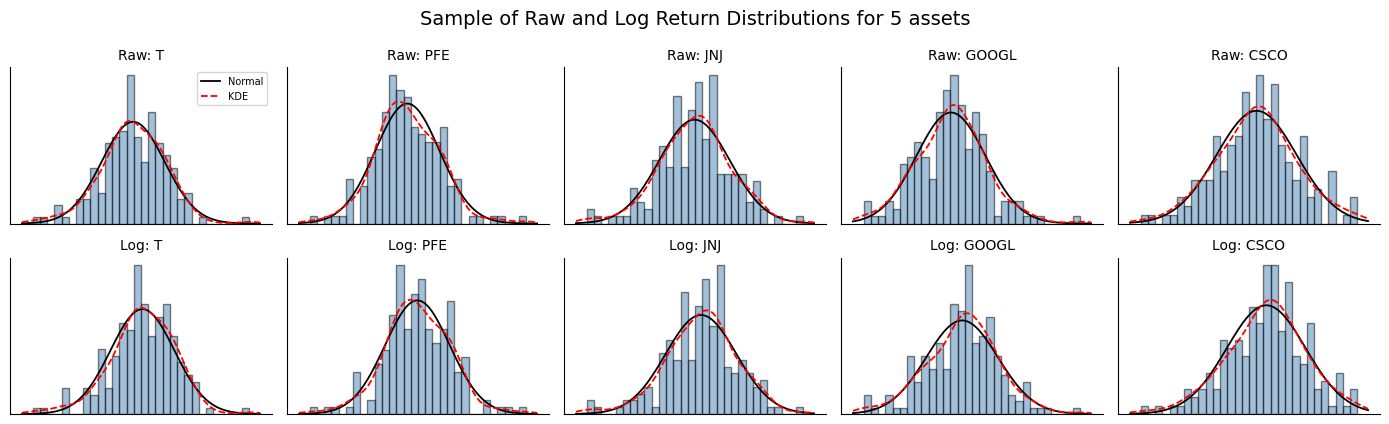

In [45]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Ensure reproducibility
np.random.seed(42)
sampled_cols = np.random.choice(returns.columns, size=5, replace=False)

# Set up the figure
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
axes = axes.flatten()

for i, col in enumerate(sampled_cols):
    # Raw returns
    data_raw = returns[col].dropna()
    ax_raw = axes[i]
    ax_raw.hist(data_raw, bins=30, density=True, alpha=0.5, color='steelblue', edgecolor='black')
    
    mu, std = data_raw.mean(), data_raw.std()
    x = np.linspace(*ax_raw.get_xlim(), 100)
    ax_raw.plot(x, stats.norm.pdf(x, mu, std), 'k-', linewidth=1.3, label='Normal')
    ax_raw.plot(x, stats.gaussian_kde(data_raw)(x), 'r--', linewidth=1.3, label='KDE')
    
    ax_raw.set_title(f"Raw: {col}", fontsize=10)
    ax_raw.set_xticks([])
    ax_raw.set_yticks([])
    ax_raw.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

    if i == 0:
        ax_raw.legend(fontsize=7, loc='upper right')

    # Log returns
    data_log = log_returns[col].dropna()
    ax_log = axes[i + 5]
    ax_log.hist(data_log, bins=30, density=True, alpha=0.5, color='steelblue', edgecolor='black')
    
    mu, std = data_log.mean(), data_log.std()
    x = np.linspace(*ax_log.get_xlim(), 100)
    ax_log.plot(x, stats.norm.pdf(x, mu, std), 'k-', linewidth=1.3)
    ax_log.plot(x, stats.gaussian_kde(data_log)(x), 'r--', linewidth=1.3)
    
    ax_log.set_title(f"Log: {col}", fontsize=10)
    ax_log.set_xticks([])
    ax_log.set_yticks([])
    ax_log.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

fig.suptitle("Sample of Raw and Log Return Distributions for 5 assets", fontsize=14, y=0.86)
plt.tight_layout(rect=[0, 0.02, 1, 0.88])
plt.show()

Let's investigate the Normality assumtion so that we can decide wether to use absolute returns or log returns

In [46]:
# Names to tickers mapping

column_names = list(returns.columns)
column_names 

name_to_ticker = {
    'A T & T INC': 'T',
    'ALPHABET INC': 'GOOGL',
    'ALTRIA GROUP INC': 'MO',
    'AMERICAN INTERNATIONAL GROUP INC': 'AIG',
    'APPLE INC': 'AAPL',
    'BANK OF AMERICA CORP': 'BAC',
    'BERKSHIRE HATHAWAY INC DEL': 'BRK.B',
    'CHEVRON CORP NEW': 'CVX',
    'CISCO SYSTEMS INC': 'CSCO',
    'CITIGROUP INC': 'C',
    'COCA COLA CO': 'KO',
    'EXXON MOBIL CORP': 'XOM',
    'GENERAL ELECTRIC CO': 'GE',
    'INTEL CORP': 'INTC',
    'INTERNATIONAL BUSINESS MACHS COR': 'IBM',
    'JOHNSON & JOHNSON': 'JNJ',
    'MICROSOFT CORP': 'MSFT',
    'PFIZER INC': 'PFE',
    'PROCTER & GAMBLE CO': 'PG',
    'WALMART INC': 'WMT',
    'b20ret': 'BOND20'
}

# Rename columns using the mapping
returns.rename(columns=name_to_ticker, inplace=True)

In [47]:
from scipy.stats import shapiro, jarque_bera, anderson

def run_normality_tests(df, label=''):
    results = []
    
    for col in df.columns:
        data = df[col].dropna()
        
        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = shapiro(data)
        
        # Jarque-Bera Test
        jb_stat, jb_p = jarque_bera(data)
        
        # Anderson-Darling Test
        ad_result = anderson(data, dist='norm')
        ad_stat = ad_result.statistic
        ad_crit_val = ad_result.critical_values[2]  # 5% level
        
        results.append({
            'Asset': col,
            'Shapiro_p': shapiro_p,
            'JarqueBera_p': jb_p,
            'AD_stat': ad_stat,
            'AD_5%_crit': ad_crit_val,
            'AD_pass': ad_stat < ad_crit_val
        })
    
    # Compile into DataFrame
    test_results = pd.DataFrame(results)
    test_results['Shapiro_pass'] = test_results['Shapiro_p'] > 0.05
    test_results['JB_pass'] = test_results['JarqueBera_p'] > 0.05
    test_results['All_Passed'] = test_results['Shapiro_pass'] & test_results['JB_pass'] & test_results['AD_pass']
    test_results['All_Failed'] = ~test_results['Shapiro_pass'] & ~test_results['JB_pass'] & ~test_results['AD_pass']
    
    # Summary
    summary = {
        'Total Assets': len(test_results),
        'Shapiro Passed': test_results['Shapiro_pass'].sum(),
        'Jarque-Bera Passed': test_results['JB_pass'].sum(),
        'Anderson-Darling Passed': test_results['AD_pass'].sum(),
        'Passed All Tests': test_results['All_Passed'].sum(),
        'Failed All Tests': test_results['All_Failed'].sum(),
        'Partial Agreement': len(test_results) - test_results['All_Passed'].sum() - test_results['All_Failed'].sum()
    }
    
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=[f'{label} Count'])
    
    return test_results, summary_df


In [48]:
# Log returns
log_returns = np.log(1 + returns)

# Run for raw returns
raw_results, raw_summary = run_normality_tests(returns, label='Raw Returns')

# Run for log returns
log_results, log_summary = run_normality_tests(log_returns, label='Log Returns')

# Combine summary
combined_summary = pd.concat([raw_summary, log_summary], axis=1)

# Display
combined_summary


Raw Returns Count  Log Returns Count
Total Assets                            21                 21
Shapiro Passed                           8                  7
Jarque-Bera Passed                       7                  6
Anderson-Darling Passed                 11                  9
Passed All Tests                         6                  6
Failed All Tests                         9                 12
Partial Agreement                        6                  3

While the assumption of normally distributed asset returns underpins much of the Bayesian framework employed in this thesis—particularly the use of conjugate Normal-Inverse-Wishart priors—it is important to acknowledge that empirical return distributions often deviate from normality. Formal normality tests (Shapiro–Wilk, Jarque–Bera, Anderson–Darling) applied to both simple and log-transformed monthly returns reveal that a substantial subset of assets exhibit significant skewness and excess kurtosis. Despite these departures, the normality assumption is retained in the initial modeling stages to maintain analytical tractability and comparability with classical approaches. In later sections, this simplifying assumption will be explicitly challenged by introducing models with heavy-tailed priors that better accommodate the empirical characteristics of asset returns.

### Sensitivity to the Mean estimate

In [49]:
mu_hat_trial = excess_returns.mean()
mu_hat_trial

T         0.002832
GOOGL     0.011620
MO        0.010114
AIG       0.010735
AAPL      0.020837
BAC       0.008651
BRK.B     0.007567
CVX       0.009021
CSCO      0.007460
C         0.000539
KO        0.007296
XOM       0.005814
GE       -0.000028
INTC      0.004877
IBM       0.005838
JNJ       0.008369
MSFT      0.014073
PFE       0.009477
PG        0.007067
WMT       0.008786
BOND20    0.002841
dtype: float64

To investigate the sensitivity of classical mean-variance optimization (MVO) to expected return estimates, we implemented the tangency portfolio formulation, which maximizes the Sharpe ratio under the assumption of a zero risk-free rate. Specifically, we computed the optimal portfolio weights that maximise Sharpe ratio. 
Following the approach of Best and Grauer (1991) and Chopra and Ziemba (1993), we introduce Gaussian noise to the vector of expected returns to simulate realistic estimation error. The perturbations are drawn from a normal distribution with a mean of 0.001 and a standard deviation of 0.0005, corresponding to 10–50 basis points, which is consistent with the magnitude of forecast errors documented in empirical studies. This perturbation range is sufficient to reveal the optimizer's fragility while remaining within plausible bounds of analyst forecast uncertainty.

In [50]:
# --- SENSITIVITY TO EXPECTED RETURNS ---

# Mean and covariance
mu_hat = excess_returns.mean().values
Sigma_hat = excess_returns.cov().values
assets = excess_returns.columns

# MVO function
def compute_mvo_weights(mu, Sigma):
    inv_Sigma = inv(Sigma)
    weights = inv_Sigma @ mu
    weights /= np.sum(weights)
    return weights


def compute_long_only_mvo_weights(mu, Sigma, risk_limit=0.03):
    n = len(mu)
    w = cp.Variable(n)
    risk = cp.quad_form(w, Sigma)
    ret = mu @ w
    constraints = [cp.sum(w) == 1, w >= 0, risk <= risk_limit**2]
    problem = cp.Problem(cp.Maximize(ret), constraints)
    problem.solve()
    return w.value

# Baseline weights
baseline_weights = compute_mvo_weights(mu_hat, Sigma_hat)
baseline_weights_longonly = compute_long_only_mvo_weights(mu_hat, Sigma_hat)


np.random.seed(123)  # for reproducibility
epsilon_mu = np.random.normal(loc=0, scale=0.001, size=mu_hat.shape)  # Gaussian noise
mu_noisy = mu_hat + epsilon_mu  # perturbed mean


# Compute perturbed MVO weights
weights_noisy = compute_mvo_weights(mu_noisy, Sigma_hat)
weights_noisy_longonly = compute_long_only_mvo_weights(mu_noisy, Sigma_hat)


# Compare baseline and noisy-mean weights
df_compare_noise = pd.DataFrame({
    'Baseline': baseline_weights,
    'Perturbed (Gaussian noise μ+N(0, 0.001))': weights_noisy
}, index=assets)





percentual_change = np.abs((weights_noisy - baseline_weights) / np.where(baseline_weights != 0, baseline_weights, np.nan))
avg_percentual_change = np.nanmean(percentual_change) * 100  # in percentage

print(f"Average absolute percentual change in weights: {avg_percentual_change:.2f}%")



Average absolute percentual change in weights: 44.07%


In [51]:
print(baseline_weights_longonly)

[7.75494750e-08 3.10847404e-07 1.24637160e-01 2.61380253e-08
 1.36657645e-01 4.87698501e-08 8.06048357e-03 1.73131373e-02
 6.78247834e-08 1.96615436e-08 4.97686111e-07 8.59825599e-07
 2.70531892e-08 4.88680756e-08 3.83193987e-07 7.62389882e-02
 1.34048653e-01 5.85461568e-02 8.45133528e-07 1.00807499e-01
 3.43687065e-01]


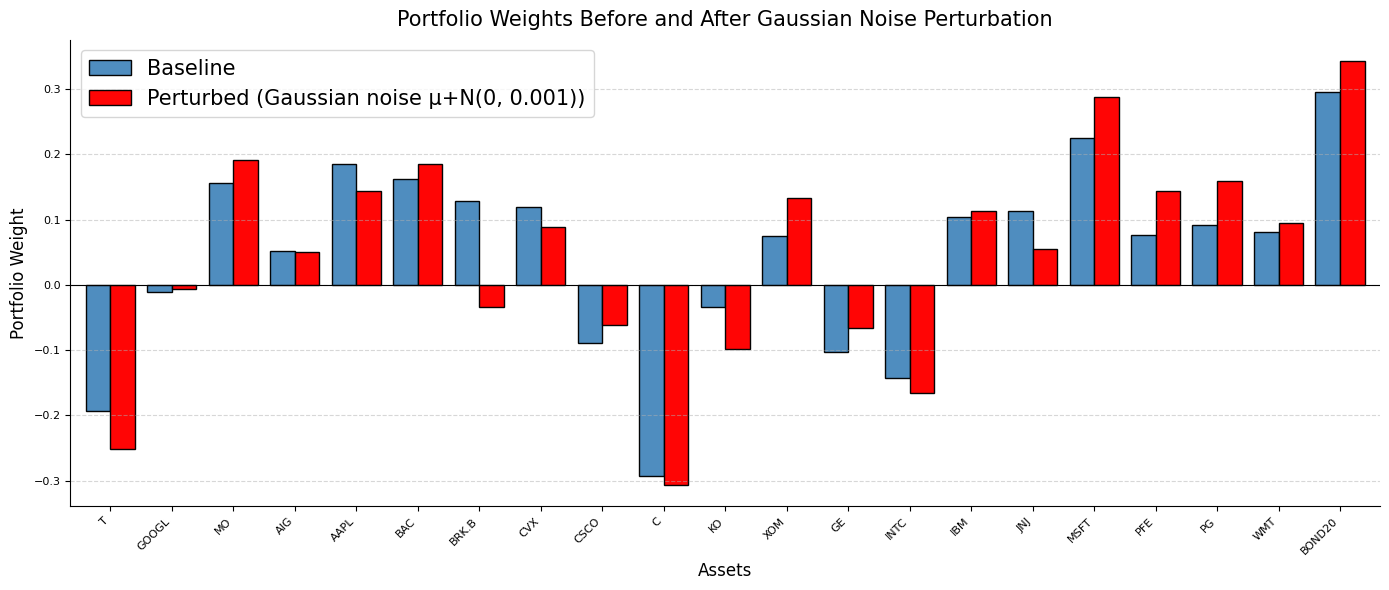

In [52]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-muted')

# Define custom colors for the two series
colors = ['#4B8BBE', 'red']

ax = df_compare_noise.plot(
    kind='bar', 
    figsize=(14, 6), 
    width=0.8, 
    alpha=0.98, 
    edgecolor='k',
    color=colors
)

# Set smaller font sizes everywhere
ax.set_title("Portfolio Weights Before and After Gaussian Noise Perturbation", fontsize=15, pad=10)
ax.set_ylabel("Portfolio Weight", fontsize=12)
ax.set_xlabel("Assets", fontsize=12)
ax.axhline(0, color='black', linewidth=0.8)
ax.legend(fontsize=15, loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [53]:
ax.text(0.99, 0.99, f"Avg. % Change: {avg_percentual_change:.2f}%", 
        ha='right', va='top', fontsize=12, color='dimgray', 
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

Text(0.99, 0.99, 'Avg. % Change: 44.07%')

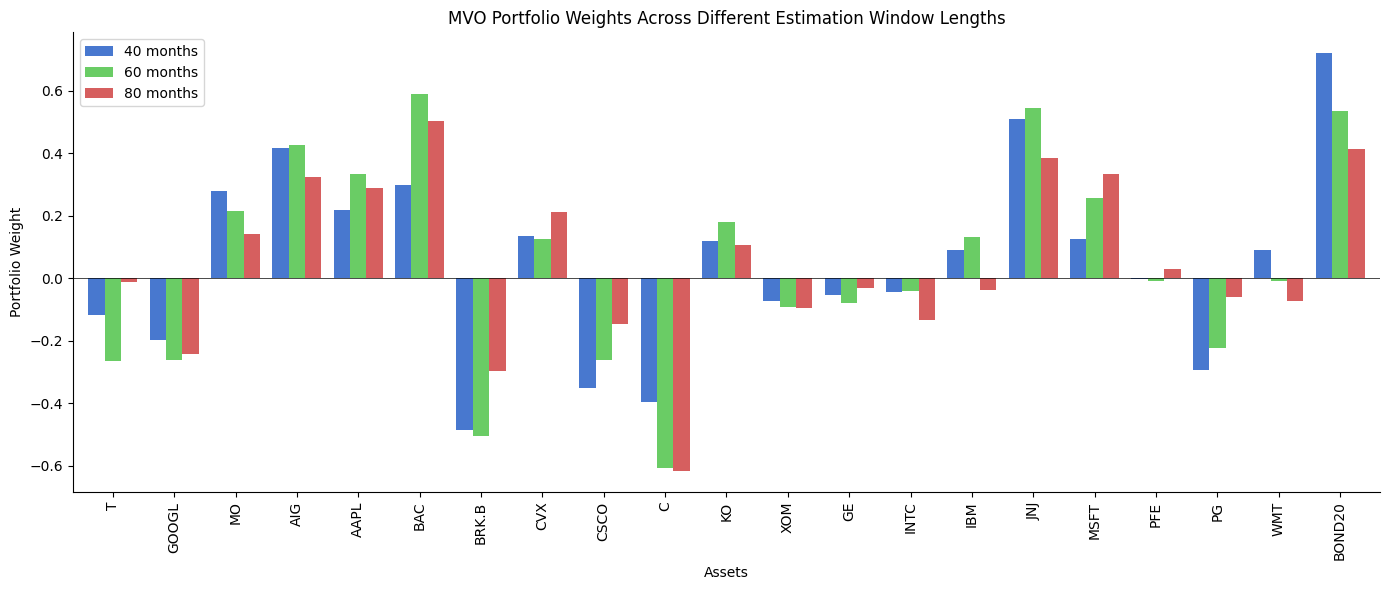

In [54]:
# Define estimation windows
window_sizes = [40,60,80]
weights_by_window = {}

# Compute weights for each window size
for window in window_sizes:
    recent_returns = excess_returns.iloc[-window:]  # last 'window' months
    mu_win = excess_returns.mean().values
    Sigma_win = recent_returns.cov().values
    weights_by_window[f"{window} months"] = compute_mvo_weights(mu_win, Sigma_win)

# Combine into DataFrame
df_window_compare = pd.DataFrame(weights_by_window, index=assets)

# Plot
df_window_compare.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("MVO Portfolio Weights Across Different Estimation Window Lengths")
plt.ylabel("Portfolio Weight")
plt.xlabel("Assets")
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

These results highlight that classical MVO is not robust to sampling variation. Because it treats estimated inputs as if they are the true parameters, it reacts too aggressively to small shifts in estimated means and covariances — even when those shifts arise purely from a different sample of historical data. This makes the resulting portfolios fragile, hard to trust, and likely to perform poorly out-of-sample.

### Efficient Frontier visualisation and weights computation under different estimation windows

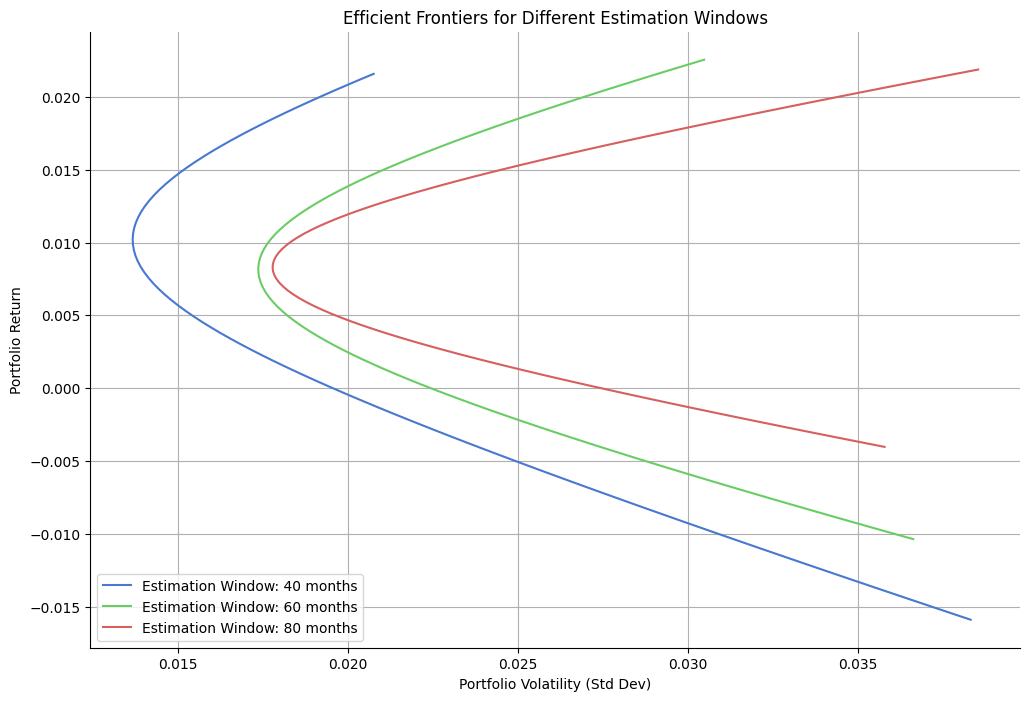

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


# Function to compute efficient frontier
def compute_efficient_frontier(data, bayesian=False):
    mu = data.mean().values
    S = data.cov().values
    T, N = data.shape
    
    if bayesian:
        # Apply correct predictive scaling
        if T <= N + 2:
            raise ValueError("Sample size T must be greater than N + 2 for Bayesian predictive covariance.")
        scale_factor = (1 + 1 / T) * ((T - 1) / (T - N - 2))
        Sigma = scale_factor * S
    else:
        Sigma = S

    target_returns = np.linspace(mu.min(), mu.max(), 100)
    portfolio_vols = []
    
    for target_return in target_returns:
        w = cp.Variable(N)
        portfolio_return = mu @ w
        portfolio_variance = cp.quad_form(w, Sigma)
        prob = cp.Problem(cp.Minimize(portfolio_variance),
                          [cp.sum(w) == 1,
                           portfolio_return == target_return])
        prob.solve()

        if w.value is not None:
            portfolio_vols.append(np.sqrt(portfolio_variance.value))
        else:
            portfolio_vols.append(np.nan)

    return target_returns, portfolio_vols

# Estimation windows
windows = [40,60,80]
frontiers = {}

for w in windows:
    target_returns, vols = compute_efficient_frontier(returns.iloc[:w])
    frontiers[w] = (target_returns, vols)

# Plotting
plt.figure(figsize=(12, 8))
for w in windows:
    plt.plot(frontiers[w][1], frontiers[w][0], label=f'Estimation Window: {w} months')

plt.xlabel('Portfolio Volatility (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontiers for Different Estimation Windows')
plt.grid(True)
plt.legend()
plt.show()

gmv_portfolio 0.006150530303030303 0.021883047405825924
tangency_portfolio 0.014791528787878786 0.033858975131619146


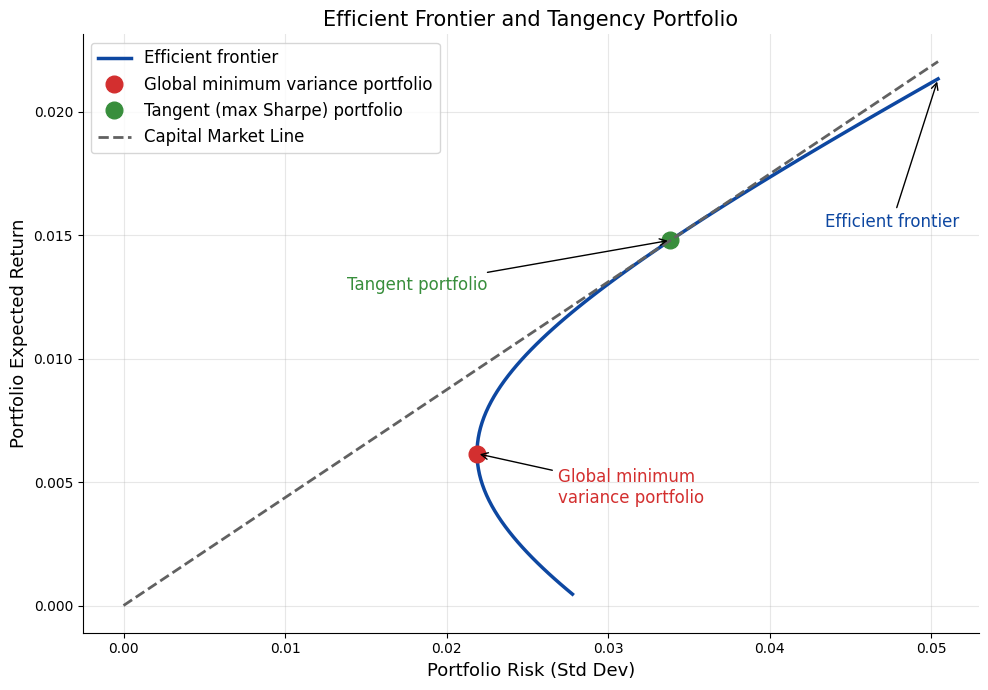

In [56]:
def compute_efficient_frontier_general(data, bayesian=False):
    mu = data.mean().values
    S = data.cov().values
    T, N = data.shape
    
    if bayesian:
        if T <= N + 2:
            raise ValueError("Sample size T must be greater than N + 2 for Bayesian predictive covariance.")
        scale_factor = (1 + 1 / T) * ((T - 1) / (T - N - 2))
        Sigma = scale_factor * S
    else:
        Sigma = S

    target_returns = np.linspace(mu.min(), mu.max(), 100)
    portfolio_vols = []
    weights = []

    for target_return in target_returns:
        w = cp.Variable(N)
        portfolio_return = mu @ w
        portfolio_variance = cp.quad_form(w, Sigma)
        prob = cp.Problem(cp.Minimize(portfolio_variance),
                          [cp.sum(w) == 1, portfolio_return == target_return])
        prob.solve()
        if w.value is not None:
            portfolio_vols.append(np.sqrt(portfolio_variance.value))
            weights.append(w.value)
        else:
            portfolio_vols.append(np.nan)
            weights.append([np.nan]*N)
    return np.array(target_returns), np.array(portfolio_vols), np.array(weights)

# Compute the frontier (returns is your excess returns DataFrame)
target_returns, portfolio_vols, weights = compute_efficient_frontier_general(returns.iloc[:180])

# Find GMV (global minimum variance) portfolio
gmv_idx = np.nanargmin(portfolio_vols)
gmv_ret = target_returns[gmv_idx]
gmv_vol = portfolio_vols[gmv_idx]
print('gmv_portfolio', gmv_ret, gmv_vol)

# Find Tangency (max Sharpe) portfolio
rf = 0.0  # risk-free rate for excess returns
sharpe = (target_returns - rf) / portfolio_vols
tangency_idx = np.nanargmax(sharpe)
tangency_ret = target_returns[tangency_idx]
tangency_vol = portfolio_vols[tangency_idx]
print('tangency_portfolio', tangency_ret, tangency_vol)

# Capital Market Line
cml_x = np.linspace(0, portfolio_vols.max(), 100)
cml_y = rf + (tangency_ret - rf) / tangency_vol * cml_x

# Plotting
plt.figure(figsize=(10, 7))
plt.plot(portfolio_vols, target_returns, color='#0d47a1', linewidth=2.5, label='Efficient frontier')
plt.plot(gmv_vol, gmv_ret, 'o', markersize=12, color='#d32f2f', label='Global minimum variance portfolio')
plt.plot(tangency_vol, tangency_ret, 'o', markersize=12, color='#388e3c', label='Tangent (max Sharpe) portfolio')
plt.plot(cml_x, cml_y, linestyle='--', color='#616161', linewidth=2, label='Capital Market Line')

# Custom annotation positions and colors
plt.annotate(
    'Efficient frontier',
    xy=(portfolio_vols[-1], target_returns[-1]),
    xytext=(portfolio_vols[-1]-0.007, target_returns[-1]-0.006),  # Move to the left and up
    arrowprops=dict(facecolor="#1952a7", arrowstyle='->'),
    fontsize=12, color='#0d47a1'
)
plt.annotate(
    'Global minimum\nvariance portfolio',
    xy=(gmv_vol, gmv_ret),
    xytext=(gmv_vol+0.005, gmv_ret-0.002),  # Move to the right and down
    arrowprops=dict(facecolor='#d32f2f', arrowstyle='->'),
    fontsize=12, color='#d32f2f'
)
plt.annotate(
    'Tangent portfolio',
    xy=(tangency_vol, tangency_ret),
    xytext=(tangency_vol-0.02, tangency_ret-0.002),  # Move right and up
    arrowprops=dict(facecolor='#388e3c', arrowstyle='->'),
    fontsize=12, color='#388e3c'
)

plt.xlabel('Portfolio Risk (Std Dev)', fontsize=13)
plt.ylabel('Portfolio Expected Return', fontsize=13)
plt.title('Efficient Frontier and Tangency Portfolio', fontsize=15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Rolling Window Backtesting strategy optimised

In [57]:
def solve_portfolio(mu, Sigma, risk_limit, constraints_fn, ridge=False, lambda_ridge=0.1):
    n = len(mu)
    w = cp.Variable(n)
    risk = cp.quad_form(w, Sigma)
    ret = np.array(mu) @ w
    constraints = constraints_fn(w, risk, risk_limit)

    # Objective: include ridge penalty if requested
    if ridge:
        ridge_penalty = lambda_ridge * cp.sum_squares(w)
        objective = cp.Maximize(ret - ridge_penalty)
    else:
        objective = cp.Maximize(ret)

    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value if w.value is not None else None

In [58]:
# three constraint cases
def unconstrained(w, risk, risk_limit):
    return [cp.sum(w) == 1, risk <= risk_limit**2]

def unconstrained_ridge(w, risk, risk_limit):
    return [cp.sum(w) == 1, risk <= risk_limit**2]

def long_only(w, risk, risk_limit):
    return [cp.sum(w) == 1, w >= 0, risk <= risk_limit**2]

def capped_0_5(w, risk, risk_limit):
    return [cp.sum(w) == 1, w >= 0, w <= 0.5, risk <= risk_limit**2]

def capped_0_3(w, risk, risk_limit):
    return [cp.sum(w) == 1, w >= 0, w <= 0.3, risk <= risk_limit**2]

In [59]:
from statsmodels.tsa.stattools import adfuller

def run_rolling_strategy(excess_returns, estimation_window, holding_period, risk_limit, constraint_fn):
    weights_over_time = []
    portfolio_returns = []
    portfolio_return_dates = []
    rebalance_dates = []
    T = len(excess_returns)
    asset_names_all = set()

    for start in range(0, T - estimation_window - holding_period + 1, holding_period):
        est_data = excess_returns.iloc[start:start + estimation_window].dropna(axis=1)
        

        '''
        # ----- ADF Stationarity Check -----
        stationary_assets = []
        total_assets = est_data.shape[1]

        for col in est_data.columns:
            try:
                p_value = adfuller(est_data[col])[1]
                if p_value < 0.05:
                    stationary_assets.append(col)
            except Exception as e:
                continue  # skip problematic series
        
        percent_stationary = 100 * len(stationary_assets) / total_assets if total_assets > 0 else 0
        print(f"Rebalance date: {excess_returns.index[start + estimation_window]} | "
              f"Stationary assets: {len(stationary_assets)}/{total_assets} "
              f"({percent_stationary:.1f}%)")

        est_data = est_data[stationary_assets]
        if est_data.shape[1] == 0:
            continue
        '''

        hold_data = excess_returns.iloc[start + estimation_window:start + estimation_window + holding_period]
        hold_data = hold_data[est_data.columns]
        hold_dates = hold_data.index

        mu_hat = est_data.mean().values
        Sigma_hat = est_data.cov().values
        asset_names = est_data.columns
        asset_names_all.update(asset_names)

        if constraint_fn.__name__ == "unconstrained_ridge":
            weights = solve_portfolio(mu_hat, Sigma_hat, risk_limit, constraint_fn, ridge=True)
        else:
            weights = solve_portfolio(mu_hat, Sigma_hat, risk_limit, constraint_fn)

        if weights is not None:
            port_rets = hold_data @ weights
            portfolio_returns.extend(port_rets)
            portfolio_return_dates.extend(hold_dates)
            weights_over_time.append(pd.Series(weights, index=asset_names))
            rebalance_dates.append(hold_dates[0])

    weights_df = pd.DataFrame(weights_over_time, index=rebalance_dates).reindex(columns=sorted(asset_names_all)).fillna(0)
    returns_series = pd.Series(portfolio_returns, name="Rolling Portfolio excess_returns", index=portfolio_return_dates)
    return weights_df, returns_series


In [60]:
def summarize_performance(weights_df, returns_series):
    # === Rolling Metrics ===
    rolling_hhi = weights_df.apply(lambda w: np.sum(w**2), axis=1)
    rolling_weight_std = weights_df.std(axis=1)

    # === Turnover ===
    turnover_series = weights_df.diff().abs().sum(axis=1).iloc[1:]  # exclude first NaN
    avg_turnover = turnover_series.mean()
    turnover_std = turnover_series.std()

    # === Returns & Sharpe ===
    cumulative_returns = (1 + returns_series).cumprod()
    total_cumulative_return = cumulative_returns.iloc[-1] - 1
    mean_return = returns_series.mean()
    annualized_return = ((1 + mean_return) ** 12 - 1)*100
    volatility = returns_series.std()
    sharpe_ratio = mean_return / volatility * np.sqrt(12)

    # === Summary Table ===
    summary = pd.DataFrame({
        "Total Cumulative Return": [total_cumulative_return],
        "Mean Monthly Return": [mean_return],
        "Volatility (Monthly Std)": [volatility],
        "Annualized Sharpe Ratio": [sharpe_ratio],
        "Annualized Return %": [annualized_return],
        "Average HHI": [rolling_hhi.mean()],
        "HHI Std Dev": [rolling_hhi.std()],
        "Avg Rolling Weight Std Dev": [rolling_weight_std.mean()],
        "Average Turnover": [avg_turnover],
        "Turnover Std Dev": [turnover_std]
    })

    # === Allocation Diagnostics ===
    high_weight_counts = (weights_df > 0.9).sum()
    weight_std = weights_df.std()
    avg_weight = weights_df.mean()

    allocation_diagnostics = pd.DataFrame({
        "Average Weight": avg_weight,
        "High Weight Count (>90%)": high_weight_counts,
        "Weight Std Dev": weight_std
    })

    return summary, allocation_diagnostics, cumulative_returns, turnover_series


## Strategies: 

Running strategy: Unconstrained


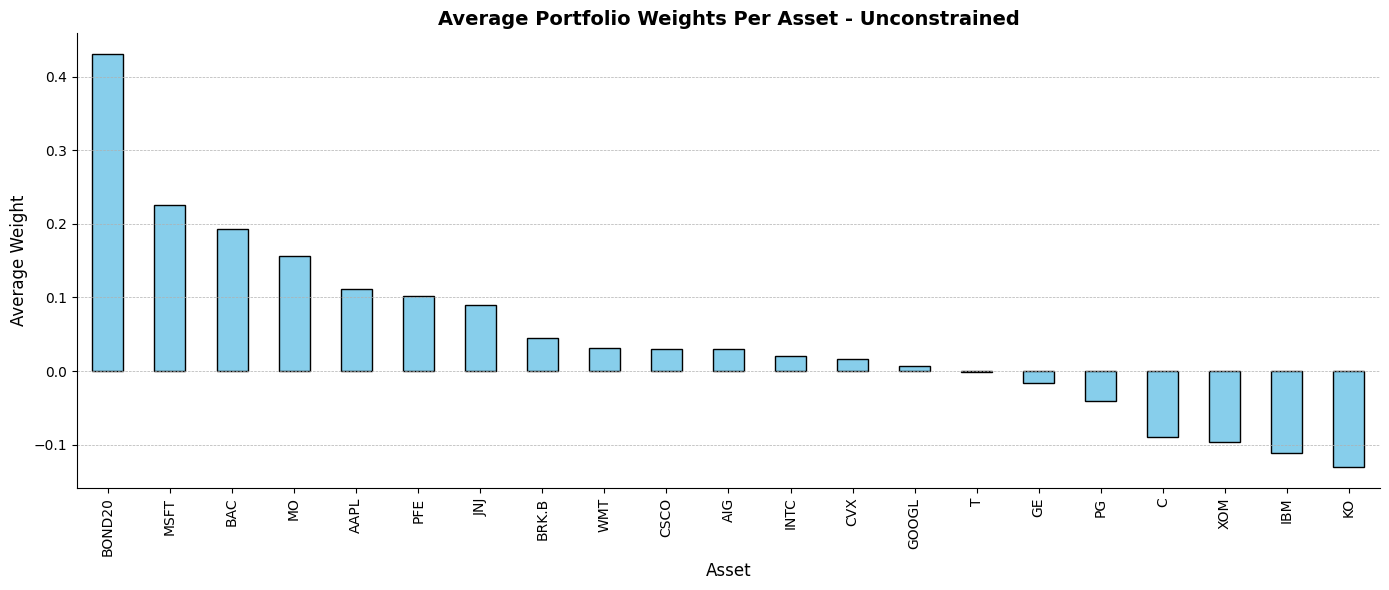

Running strategy: Unconstrained Ridge


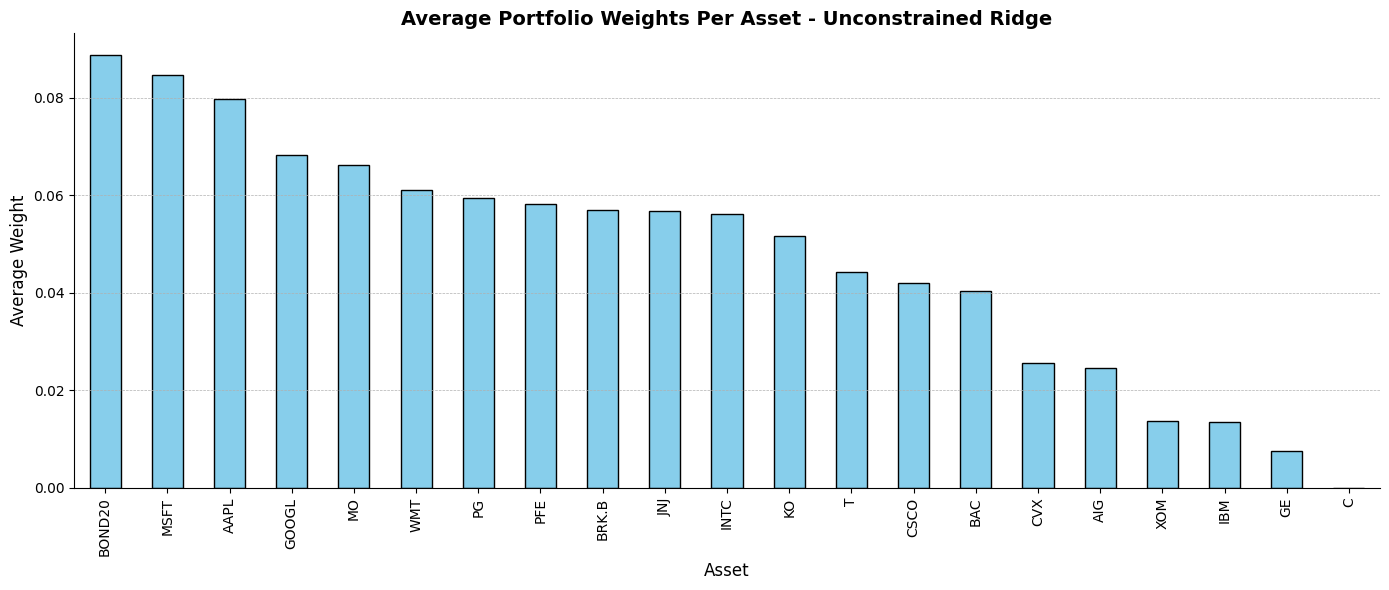

Running strategy: Long Only


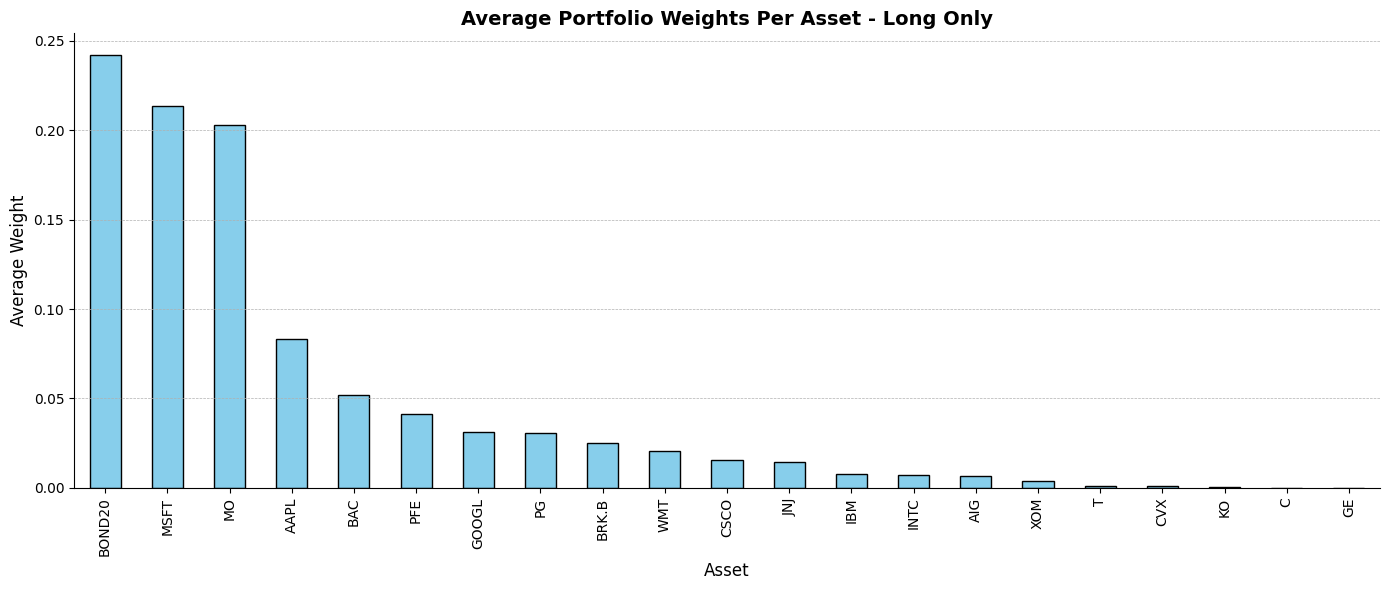

In [61]:
strategies = {
    "Unconstrained": unconstrained,
    "Unconstrained Ridge": unconstrained_ridge,
    "Long Only": long_only,
#    "Cap 0.5": capped_0_5,
#    "Cap 0.3": capped_0_3
}

results_class = {}
for name, constraint_fn in strategies.items():

    print(f"Running strategy: {name}")
    weights_df, returns_series = run_rolling_strategy(excess_returns, 60, 2, 0.03, constraint_fn)
    # Convert excess returns to total by adding risk-free return
    rf_aligned = rf_final_aligned.reindex(returns_series.index, method='ffill')['rf_return']
    returns_total = returns_series + rf_aligned  # total returns

    # Recalculate cumulative returns
    cum_total = (1 + returns_total).cumprod() * 100  # rebased to $100

    # Store updated cumulative total returns instead of excess cumulative returns
    summary, diag, _, turnover = summarize_performance(weights_df, returns_series)
    results_class[name] = (summary, diag, cum_total, weights_df)

    '''
    # Plot Weight Evolution During Period (e.g., Month 25–35)
    if len(weights_df) >= 35:
        import seaborn as sns
        sns.set_theme(style="whitegrid")
        mid_idx = len(weights_df) // 2
        subset = weights_df.iloc[max(mid_idx - 10, 0): mid_idx + 10].copy()

        if isinstance(subset.index[0], pd.Timestamp):
            subset.index = subset.index.date

        fig, ax = plt.subplots(figsize=(14, 7))
        colors = plt.cm.tab20.colors

        subset.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=colors,
            edgecolor='black',
            linewidth=0.3
        )

        ax.set_title(f'Top Asset Weights During (Month 25–30) - {name}', fontsize=16, weight='bold')
        ax.set_xlabel('Rebalance Date', fontsize=12)
        ax.set_ylabel('Portfolio Weight', fontsize=12)

        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title='Assets',
            fontsize=10,
            title_fontsize=11,
            frameon=False
        )

        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelsize=10)

        plt.tight_layout()
        plt.show()
    '''

    # === Plot: Average Weight Per Asset ===
    avg_weight = diag["Average Weight"].sort_values(ascending=False)

    plt.figure(figsize=(14, 6))
    avg_weight.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Average Portfolio Weights Per Asset - {name}", fontsize=14, weight='bold')
    plt.xlabel("Asset", fontsize=12)
    plt.ylabel("Average Weight", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()




In [62]:
start_date = '2013-01-31'  # or '2013-01' if PeriodIndex

sliced = sp_benchmark.copy()
sliced = sliced[sliced.index >= start_date]
benchmark_subset = (1 + sliced["sprtrn"]).cumprod() * 100


In [63]:
first_real_date = cum_total.index[0]

# Create a synthetic date at the beginning of the month
synthetic_start_date = pd.to_datetime(first_real_date) - pd.offsets.MonthBegin(1)
synthetic_start_date = synthetic_start_date.normalize()  # ensures time is 00:00:00

# Insert the synthetic value at this new date
cum_total_aligned = pd.concat([
    pd.Series([100], index=[synthetic_start_date]),
    cum_total
]).sort_index()

benchmark_aligned = pd.concat([
    pd.Series([100], index=[synthetic_start_date]),
    benchmark_subset
]).sort_index()


In [64]:
benchmark_aligned.values

array([100.        , 105.0428    , 106.20467841, 110.02677238,
       112.01671658, 114.34251967, 112.62749622, 118.19827743,
       114.49890775, 117.90513575, 123.16323319, 126.61783872,
       129.60133485, 124.98973055, 130.37891276, 131.28269939,
       132.09678341, 134.87477876, 137.44522229, 135.37254834,
       140.47000165, 138.29075004, 141.49923374, 144.97077594,
       144.36349336, 139.88230616, 147.56086559, 144.99389677,
       146.22938977, 147.7634823 , 144.65867601, 147.51452759,
       138.28292094, 134.62630566, 145.79800038, 145.87162837,
       143.31449873, 136.04343763, 135.48185032, 144.42243311,
       144.81222925, 147.03205592, 147.16526696, 152.40582211,
       152.22003942, 152.03219989, 149.07882237, 154.17344205,
       156.97955287, 159.78697519, 165.7307311 , 165.66626184,
       167.17233383, 169.10752076, 169.92160437, 173.20941749,
       173.30398983, 176.64927675, 180.5687709 , 185.63968369,
       187.46489306, 197.99648329, 190.28511426, 185.16

In [65]:
cum_total_aligned.values

array([100.        ,  97.78277921,  97.65271751,  99.09550197,
       101.83302233,  99.35733197,  95.48981046,  97.36272784,
        96.10323724,  97.14514127, 102.62617738, 103.98736323,
       104.98425875,  98.74866563, 102.03400406, 104.31513538,
       108.18104562, 110.66412561, 111.91622335, 111.02994044,
       117.98304422, 120.63688873, 126.09021644, 133.35027013,
       131.39375461, 137.82296529, 144.01890987, 137.74868586,
       136.84662054, 139.8509932 , 135.04448817, 142.51373879,
       133.9590105 , 134.58525829, 146.55336674, 144.15919821,
       142.24736171, 143.63026918, 142.15736531, 147.08607321,
       144.0135621 , 147.40597884, 154.22479002, 157.40326946,
       156.09222833, 152.99100621, 157.07845517, 160.04713245,
       167.40787325, 172.5250088 , 180.78765711, 175.53831393,
       176.96735493, 182.38184295, 183.42850216, 175.87410169,
       175.04135282, 176.97137547, 187.51694509, 192.4619947 ,
       198.25442675, 209.29711072, 198.73028646, 194.37

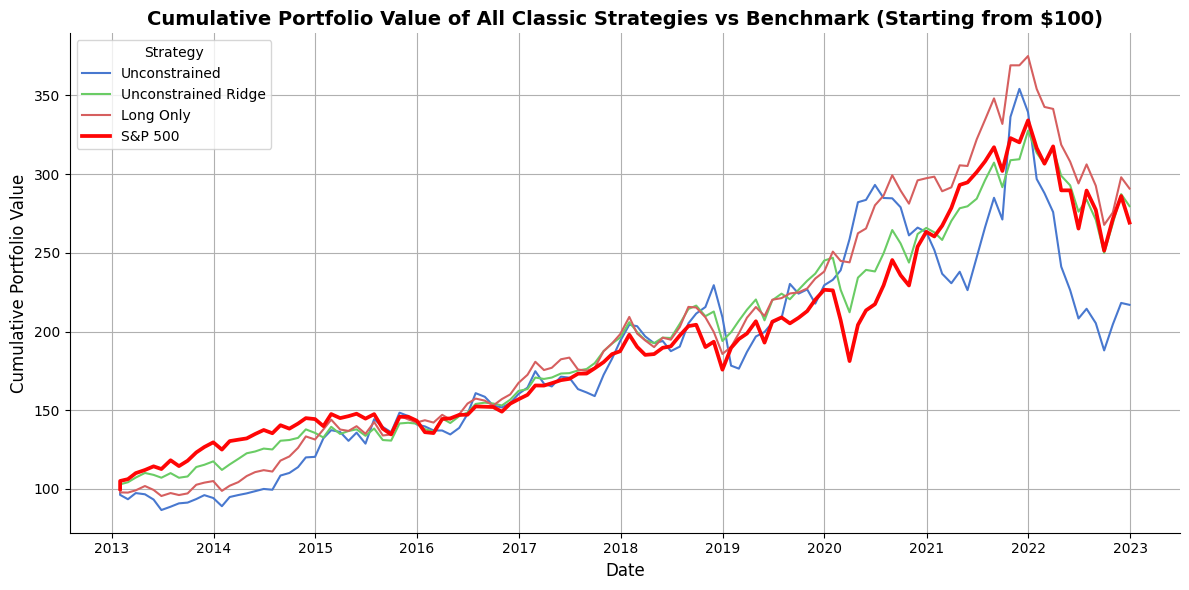

In [66]:
plt.figure(figsize=(12, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')  # This ensures the axes background is also white

for name, (_, _, cum_total, _) in results_class.items():
    aligned = pd.concat([pd.Series([100], index=[cum_total.index[0]]), cum_total]).sort_index()
    plt.plot(aligned.index, aligned.values, label=name)

aligned_bench = pd.concat([pd.Series([100], index=[benchmark_subset.index[0]]), benchmark_subset]).sort_index()
plt.plot(
    aligned_bench.index, aligned_bench.values,
    linewidth=2.7, color='red', alpha=0.98,
    label="S&P 500", zorder=3
)

plt.title("Cumulative Portfolio Value of All Classic Strategies vs Benchmark (Starting from $100)", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Portfolio Value", fontsize=12)
plt.grid(True)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()

# Strategies comparison

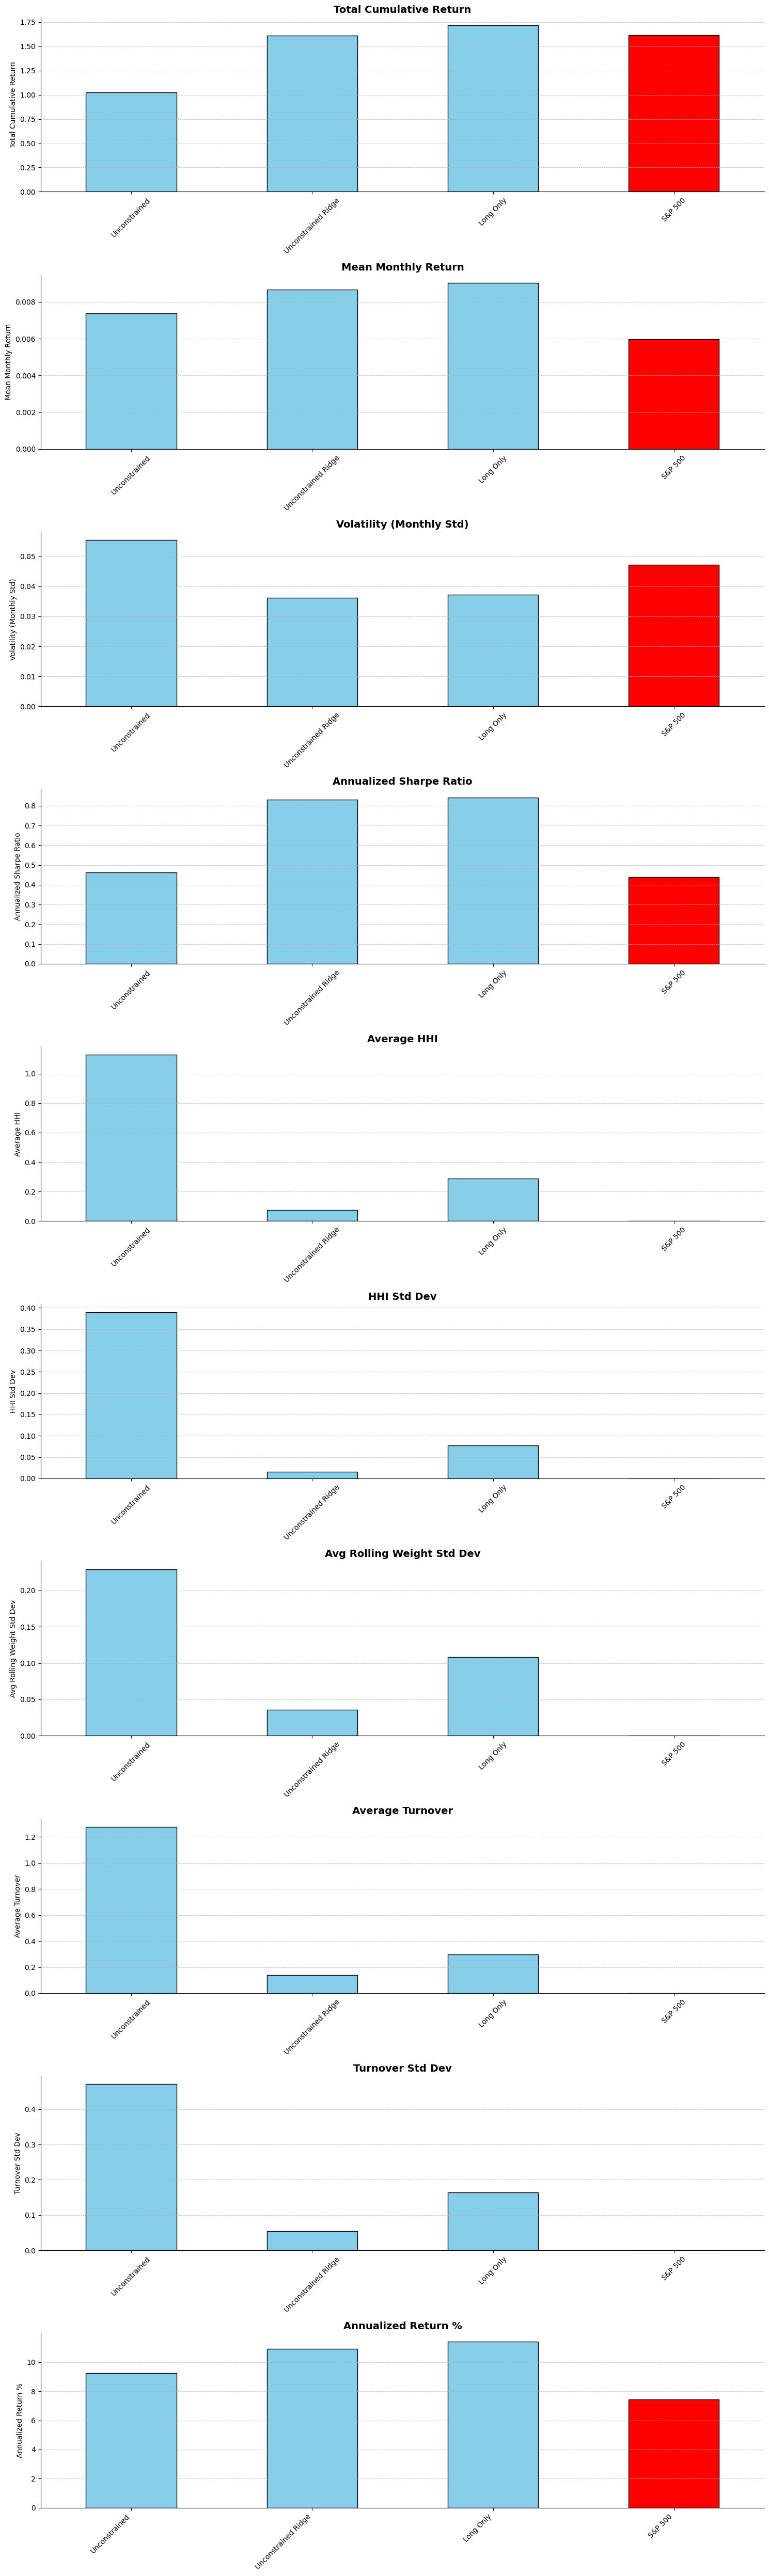

In [67]:

summary_data = {name: result[0].iloc[0] for name, result in results_class.items()}
summary_combined = pd.DataFrame(summary_data).T

metrics_to_plot = [
    "Total Cumulative Return",
    "Mean Monthly Return",
    "Volatility (Monthly Std)",
    "Annualized Sharpe Ratio",
    "Average HHI",
    "HHI Std Dev",
    "Avg Rolling Weight Std Dev",
    "Average Turnover",
    "Turnover Std Dev",
    "Annualized Return %"
]

summary_combined_with_benchmark = pd.concat([summary_combined, benchmark_metrics])

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 5 * len(metrics_to_plot))) # Adjusted figure size

for i, metric in enumerate(metrics_to_plot):
    values = summary_combined_with_benchmark[metric]
    colors = ['red' if idx == 'S&P 500' else 'skyblue' for idx in values.index]

    bars = values.plot(kind='bar', ax=axes[i], edgecolor='black', color=colors)
    axes[i].set_title(metric, fontsize=14, weight='bold')
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', linewidth=0.5)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('') # Remove redundant x-axis label

# Align the x-axis labels to the right
plt.setp(axes[i].get_xticklabels(), ha="right")

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

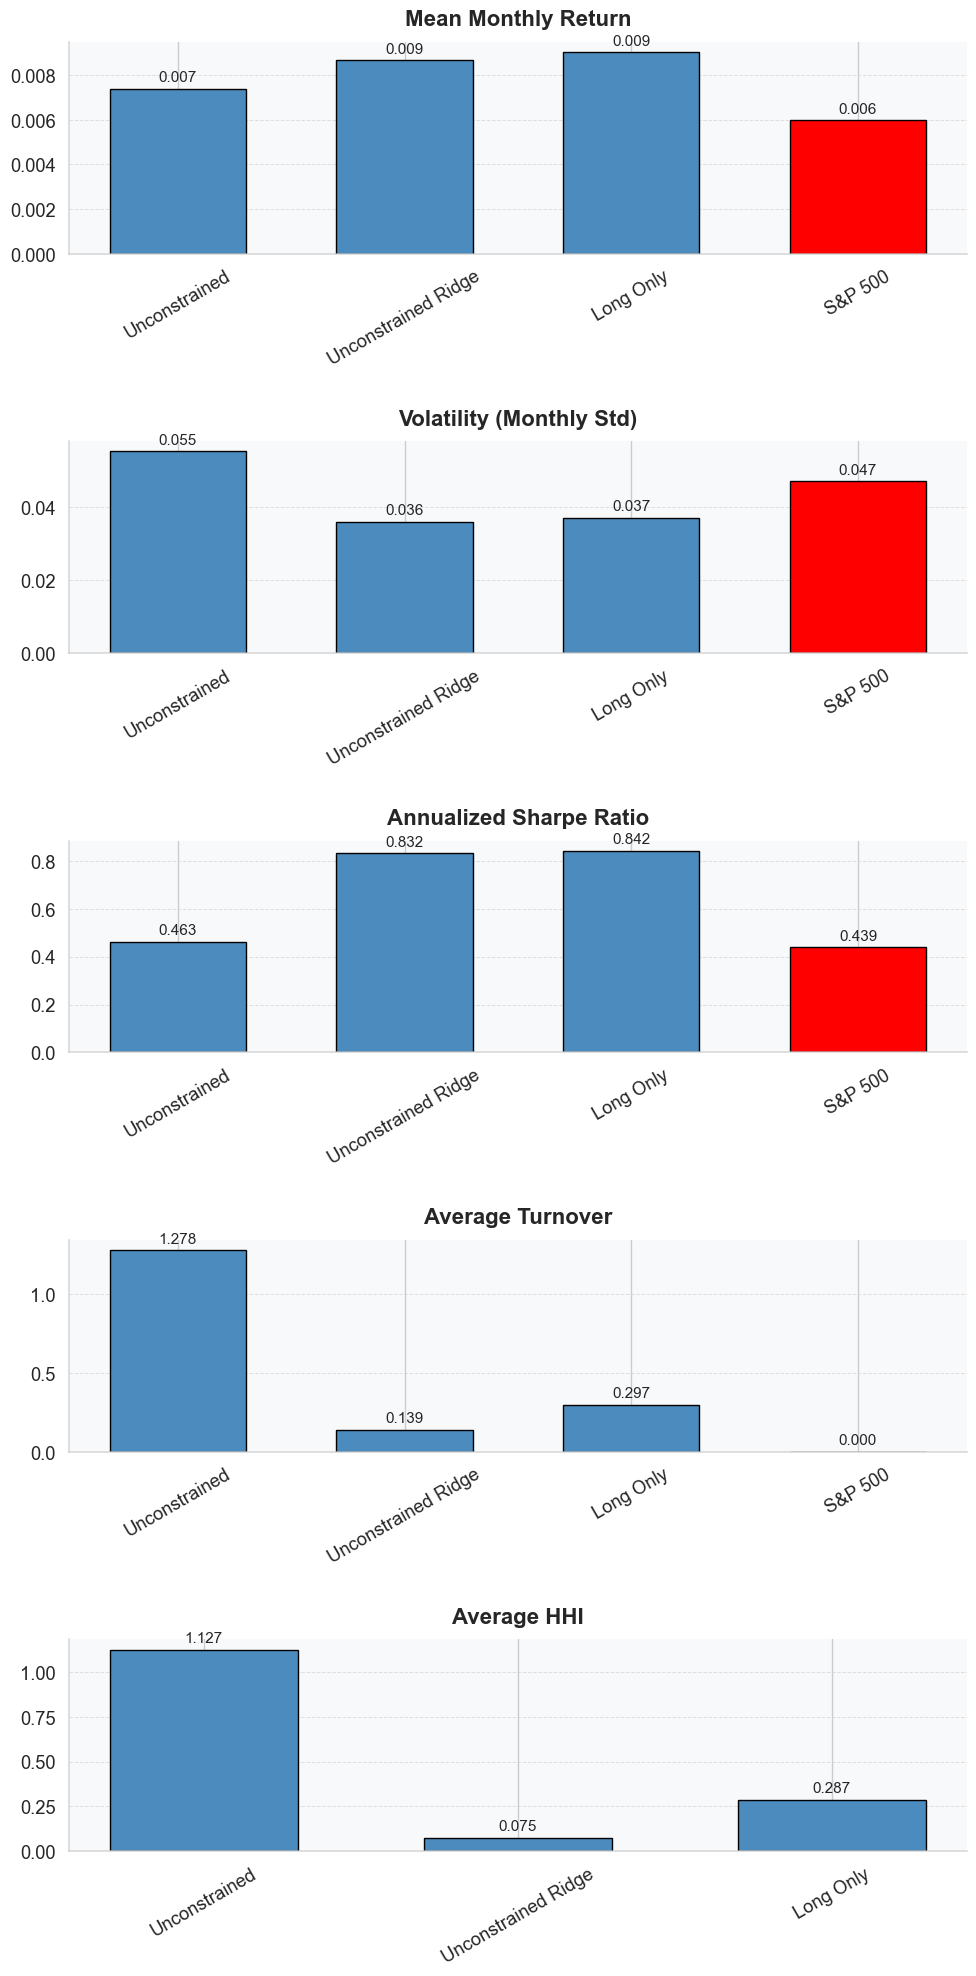

In [68]:

# Only include metrics discussed in the thesis
metrics_to_plot = [
    "Mean Monthly Return",
    "Volatility (Monthly Std)",
    "Annualized Sharpe Ratio",
    "Average Turnover",
    "Average HHI"
]

summary_combined_with_benchmark = pd.concat([summary_combined, benchmark_metrics])

# Set style for prettier plots
sns.set(style="whitegrid", font_scale=1.2, rc={"axes.facecolor": "#F8F9FB"})

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 4 * len(metrics_to_plot)))

for i, metric in enumerate(metrics_to_plot):
    values = summary_combined_with_benchmark[metric]
    colors = ['#4B8BBE' if idx != 'S&P 500' else 'red' for idx in values.index]
    
    bars = axes[i].bar(values.index, values, edgecolor='black', color=colors, width=0.6)
    
    axes[i].set_title(metric, fontsize=16, weight='bold', pad=12)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_alpha(0.7)
    axes[i].spines['bottom'].set_alpha(0.7)
    
    # Add value labels on top of bars for clarity
    for bar in bars:
        height = bar.get_height()
        axes[i].annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=11, fontweight='medium')

plt.tight_layout(h_pad=2)
plt.show()

The comparison across portfolio strategies reveals clear patterns in performance and stability. The total cumulative return and annualized return indicate that constrained strategies—particularly those imposing long-only or capped weight limits—achieve higher overall gains than the unconstrained portfolio. The mean monthly return supports this, showing consistently higher average performance for constrained portfolios. In contrast, the unconstrained portfolio, while designed to maximize expected return subject to a risk constraint, underperforms in both return and risk-adjusted terms. Its volatility remains the highest among all strategies, suggesting poor out-of-sample risk control. This is directly reflected in the **Shar

# Bayesian Framework

## Diffuse prior: Jeffreys's prior

The greater risk per- ceived by the investor in the Bayesian setting is reflected by a shift of the frontier to the right in the two Bayesian scenarios compared to the certainty-equivalence case. The shift to the right is expected because in the Bayesian setting, for each required return, the percieved risk is greater as we have both portfolio risk and estimation risk. 

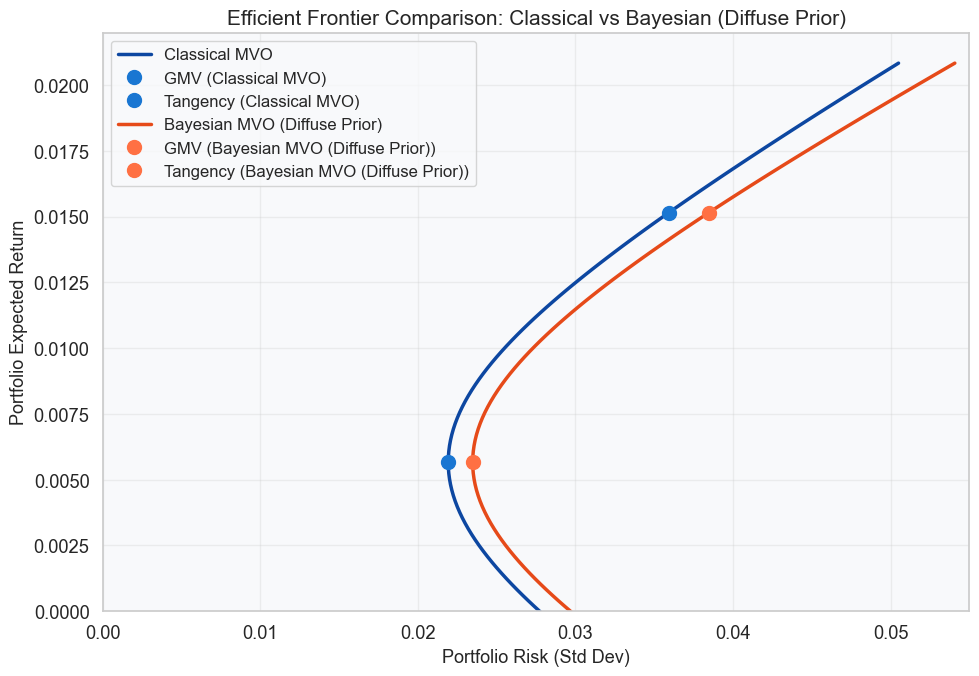

In [69]:
# Classical Efficient Frontier
target_returns_classic, vols_classic, weights_classic = compute_efficient_frontier_general(excess_returns, bayesian=False)

# Bayesian Efficient Frontier
target_returns_bayes, vols_bayes, weights_bayes = compute_efficient_frontier_general(excess_returns, bayesian=True)



def plot_efficient_frontier(target_returns, portfolio_vols, weights, label, color, dot_color):
    gmv_idx = np.nanargmin(portfolio_vols)
    gmv_ret = target_returns[gmv_idx]
    gmv_vol = portfolio_vols[gmv_idx]
    
    rf = 0.0  # risk-free rate for excess returns
    sharpe = (target_returns - rf) / portfolio_vols
    tangency_idx = np.nanargmax(sharpe)
    tangency_ret = target_returns[tangency_idx]
    tangency_vol = portfolio_vols[tangency_idx]

    plt.plot(portfolio_vols, target_returns, color=color, linewidth=2.5, label=label)
    plt.plot(gmv_vol, gmv_ret, 'o', markersize=10, color=dot_color, label=f'GMV ({label})')
    plt.plot(tangency_vol, tangency_ret, 'o', markersize=10, color=dot_color, label=f'Tangency ({label})')

# Classical = blue, Bayesian = red (adjust to your thesis palette as needed)
plt.figure(figsize=(10, 7))
plot_efficient_frontier(target_returns_classic, vols_classic, weights_classic, "Classical MVO", '#0d47a1', '#1976d2')
plot_efficient_frontier(target_returns_bayes, vols_bayes, weights_bayes, "Bayesian MVO (Diffuse Prior)", '#e64a19', '#ff7043')

plt.xlabel('Portfolio Risk (Std Dev)', fontsize=13)
plt.ylabel('Portfolio Expected Return', fontsize=13)
plt.title('Efficient Frontier Comparison: Classical vs Bayesian (Diffuse Prior)', fontsize=15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Set the same axis range (optional, but makes results visually comparable)
plt.xlim(0, 0.055)  # or min/max of your interest
plt.ylim(0, 0.022)  # or min/max of your interest

plt.show()


## Informative Bayesian

In [70]:



def informative_bayes_predictive(excess_returns, eta=None, tau=None, nu=None, Omega=None,
                                  historical_mean = average_mean_historical_pre2008, historical_var=average_variance_historical_pre2008, use_historical=False):
    """
    Predictive posterior for asset returns with conjugate Bayesian prior.

    If use_sp500 is True and eta or Omega are not provided, they are set using S&P500 stats.
    
    Parameters:
    - excess_returns: (T x N) matrix of asset excess_returns
    - eta: prior mean vector (η), shape (N,)
    - tau: scalar confidence in eta (default = 0)
    - nu: degrees of freedom for inverse-Wishart prior (default = N + 2)
    - Omega: prior scale matrix for covariance (Ω), shape (N x N)
    - sp500_mean: scalar mean return of S&P500
    - sp500_var: scalar variance of S&P500
    - use_sp500: if True, use sp500_mean and sp500_var as default prior hyperparameters

    Returns:
    - mu_pred: predictive mean vector (length N)
    - Sigma_pred: predictive covariance matrix (N x N)
    """
    T, N = excess_returns.shape

    mu_hat = excess_returns.mean(axis=0)
    Sigma_hat = np.cov(excess_returns, rowvar=False)

    # ===== Prior Mean Vector =====
    if eta is None:
        if use_historical:
            if historical_mean is None:
                raise ValueError("sp500_mean must be provided when use_sp500 is True and eta is None")
            eta = np.full(N, historical_mean)
        else:
            eta = np.zeros(N)

    # ===== Prior Confidence =====
    if tau is None:
        tau = 15  # default: no confidence in prior, i.e., sample dominates

    # ===== Prior Degrees of Freedom =====
    if nu is None:
        nu = N + 2  # minimal proper prior

    # ===== Prior Covariance =====
    if Omega is None:
        if use_historical:
            if historical_var is None:
                raise ValueError("sp500_var must be provided when use_sp500 is True and Omega is None")
            Omega = historical_var * 1e-6 * np.eye(N)
        else:
            Omega = sample_historical_covariance * (nu - N - 1)   # non-informative flat prior

    # ===== Predictive Mean =====
    mu_pred = (tau / (T + tau)) * eta + (T / (T + tau)) * mu_hat

    # ===== Predictive Covariance =====
    diff = (np.asarray(eta) - np.asarray(mu_hat)).reshape(-1, 1)
    shrinkage_term = (tau * T) / (T + tau) * (diff @ diff.T)

    Sigma_pred = ((T + 1) / ((T+tau) * (nu + T - N - 1))) * (Omega + (T - 1) * Sigma_hat + shrinkage_term)

    return mu_pred, Sigma_pred


In [71]:
def compute_efficient_frontier_from_moments(mu, Sigma):
    """
    Computes the efficient frontier given mean returns and a covariance matrix.

    Parameters:
    - mu: (N,) array of expected returns
    - Sigma: (N x N) covariance matrix of returns

    Returns:
    - target_returns: array of target returns
    - portfolio_vols: array of portfolio standard deviations
    """
    mu = np.asarray(mu)             
    Sigma = np.asarray(Sigma)   
    N = len(mu)
    target_returns = np.linspace(mu.min(), mu.max(), 100)
    portfolio_vols = []

    for target_return in target_returns:
        w = cp.Variable(N)
        port_ret = mu @ w
        port_var = cp.quad_form(w, Sigma)

        prob = cp.Problem(cp.Minimize(port_var),
                          [cp.sum(w) == 1,
                           port_ret == target_return])
        prob.solve()

        if w.value is not None:
            portfolio_vols.append(np.sqrt(port_var.value))
        else:
            portfolio_vols.append(np.nan)

    return target_returns, portfolio_vols

Comparison of variation of weights across different estimation windows

Efficient frontier for conjugate Bayesian MVO

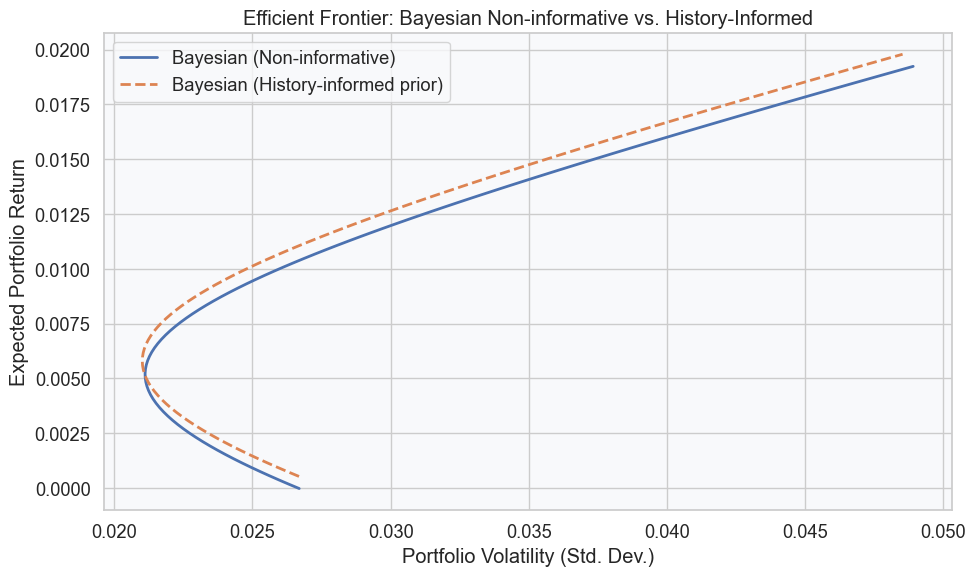

In [72]:


# Step 1: Compute non-informative Bayesian predictive moments
mu_noninf, Sigma_noninf = informative_bayes_predictive(
    excess_returns=excess_returns,
    use_historical=False
)

# Step 2: Compute SP500-based informative Bayesian predictive moments
mu_hist, Sigma_hist = informative_bayes_predictive(
    excess_returns=excess_returns,
    use_historical=True,
    tau=15  # can tune for stronger prior confidence
)

# Step 3: Compute efficient frontiers from both
ret_noninf, vol_noninf = compute_efficient_frontier_from_moments(mu_noninf, Sigma_noninf)
ret_hist, vol_hist = compute_efficient_frontier_from_moments(mu_hist, Sigma_hist)

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.plot(vol_noninf, ret_noninf, label="Bayesian (Non-informative)", linewidth=2)
plt.plot(vol_hist, ret_hist, label="Bayesian (History-informed prior)", linewidth=2, linestyle='--')
plt.xlabel("Portfolio Volatility (Std. Dev.)")
plt.ylabel("Expected Portfolio Return")
plt.title("Efficient Frontier: Bayesian Non-informative vs. History-Informed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


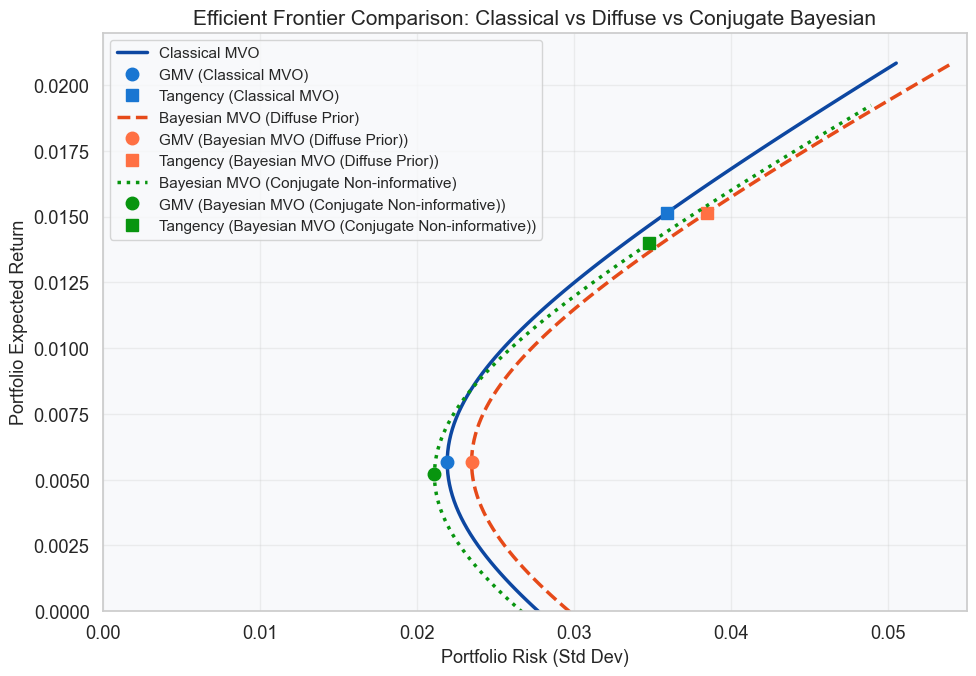

In [73]:

# Classical Efficient Frontier
target_returns_classic, vols_classic, weights_classic = compute_efficient_frontier_general(excess_returns, bayesian=False)

# Diffuse Bayesian Efficient Frontier
target_returns_bayes, vols_bayes, weights_bayes = compute_efficient_frontier_general(excess_returns, bayesian=True)

# Conjugate Bayesian (non-informative prior)
mu_conj, Sigma_conj = informative_bayes_predictive(
    excess_returns,
    use_historical=False,
    tau=15,
    nu=None,
    Omega=None
)
target_returns_conj, vols_conj = compute_efficient_frontier_from_moments(mu_conj, Sigma_conj)

# === Step 2: Plotting Function ===

def plot_frontier(tr, vol, label, line_style, line_color, dot_color):
    gmv_idx = np.nanargmin(vol)
    gmv_ret = tr[gmv_idx]
    gmv_vol = vol[gmv_idx]

    sharpe = tr / vol
    tangency_idx = np.nanargmax(sharpe)
    tangency_ret = tr[tangency_idx]
    tangency_vol = vol[tangency_idx]

    plt.plot(vol, tr, linestyle=line_style, color=line_color, linewidth=2.5, label=label)
    plt.plot(gmv_vol, gmv_ret, 'o', color=dot_color, markersize=9, label=f"GMV ({label})")
    plt.plot(tangency_vol, tangency_ret, 's', color=dot_color, markersize=9, label=f"Tangency ({label})")

# === Step 3: Final Plot ===

plt.figure(figsize=(10, 7))

plot_frontier(target_returns_classic, vols_classic, "Classical MVO", '-', '#0d47a1', '#1976d2')
plot_frontier(target_returns_bayes, vols_bayes, "Bayesian MVO (Diffuse Prior)", '--', '#e64a19', '#ff7043')
plot_frontier(target_returns_conj, vols_conj, "Bayesian MVO (Conjugate Non-informative)", ':', "#08950F", "#08950F")

plt.xlabel("Portfolio Risk (Std Dev)", fontsize=13)
plt.ylabel("Portfolio Expected Return", fontsize=13)
plt.title("Efficient Frontier Comparison: Classical vs Diffuse vs Conjugate Bayesian", fontsize=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.055)
plt.ylim(0, 0.022)
plt.tight_layout()
plt.show()

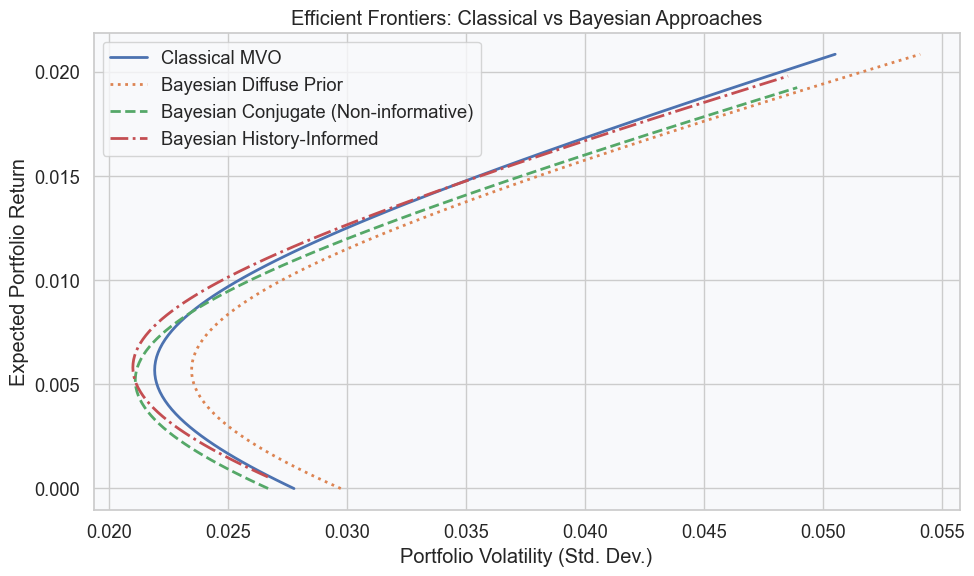

In [74]:
plt.figure(figsize=(10, 6))

# Plot each efficient frontier
plt.plot(vols_classic, target_returns_classic, label="Classical MVO", linewidth=2)
plt.plot(vols_bayes, target_returns_bayes, label="Bayesian Diffuse Prior", linestyle=':', linewidth=2)
plt.plot(vol_noninf, ret_noninf, label="Bayesian Conjugate (Non-informative)", linestyle='--', linewidth=2)
plt.plot(vol_hist, ret_hist, label="Bayesian History-Informed", linestyle='-.', linewidth=2)

# Labels and title
plt.xlabel("Portfolio Volatility (Std. Dev.)")
plt.ylabel("Expected Portfolio Return")
plt.title("Efficient Frontiers: Classical vs Bayesian Approaches")

# Legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Bayesian Rolling window strategy

In [75]:
def bayesian_diffuse_prior(est_data):
    T, N = est_data.shape
    mu_hat = est_data.mean().values
    S = est_data.cov().values
    scale_factor = (1 + 1 / T) * ((T - 1) / (T - N - 2))
    Sigma = scale_factor * S
    return mu_hat, Sigma

def bayesian_conjugate_prior(est_data):
    return informative_bayes_predictive(est_data)

def bayesian_hist_prior(est_data):
    return informative_bayes_predictive(est_data,
                                        eta=None,
                                        tau=10,
                                        nu=None,
                                        Omega=None,
                                        use_historical=True)

In [76]:
def run_bayesian_strategy(excess_returns, estimation_window, holding_period, risk_limit, constraint_fn, posterior_fn, ridge = False, **posterior_kwargs):
    weights_over_time = []
    portfolio_returns = []
    portfolio_return_dates = []
    rebalance_dates = []
    T = len(excess_returns)
    asset_names_all = set()

    for start in range(0, T - estimation_window - holding_period + 1, holding_period):
        est_data = excess_returns.iloc[start:start + estimation_window].dropna(axis=1)
        if est_data.shape[1] == 0:
            continue
        hold_data = excess_returns.iloc[start + estimation_window:start + estimation_window + holding_period]
        hold_data = hold_data[est_data.columns]
        hold_dates = hold_data.index

        mu_post, Sigma_post = posterior_fn(est_data, **posterior_kwargs)
        asset_names = est_data.columns
        asset_names_all.update(asset_names)

        weights = solve_portfolio(mu_post, Sigma_post, risk_limit, constraint_fn, ridge = ridge)
        if weights is None:
            print(f"[start={start}] Optimization failed for assets: {est_data.columns.tolist()}")
            continue
        if weights is not None:
            port_rets = hold_data @ weights
            portfolio_returns.extend(port_rets)
            portfolio_return_dates.extend(hold_dates)
            weights_over_time.append(pd.Series(weights, index=asset_names))
            rebalance_dates.append(hold_dates[0])

    weights_df = pd.DataFrame(weights_over_time, index=rebalance_dates).reindex(columns=sorted(asset_names_all)).fillna(0)
    returns_series = pd.Series(portfolio_returns, name="Bayesian Portfolio excess_returns", index=portfolio_return_dates)
    return weights_df, returns_series





Running strategy: Bayesian Diffuse


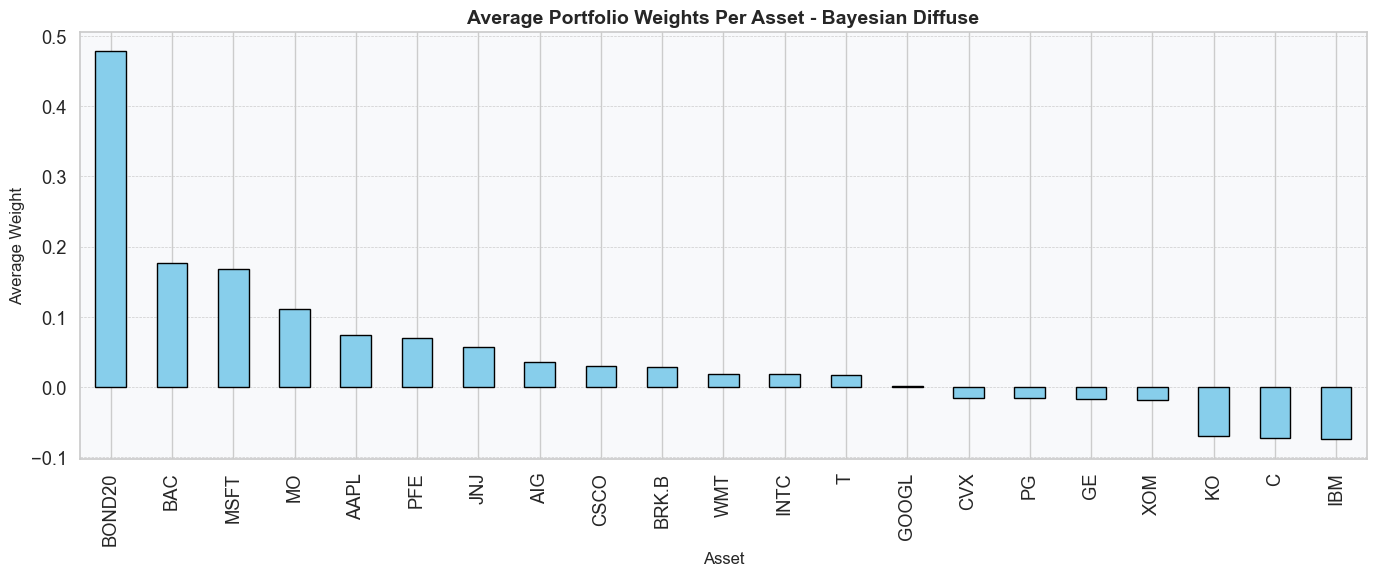




Running strategy: Bayesian Non-informative Conjugate Prior


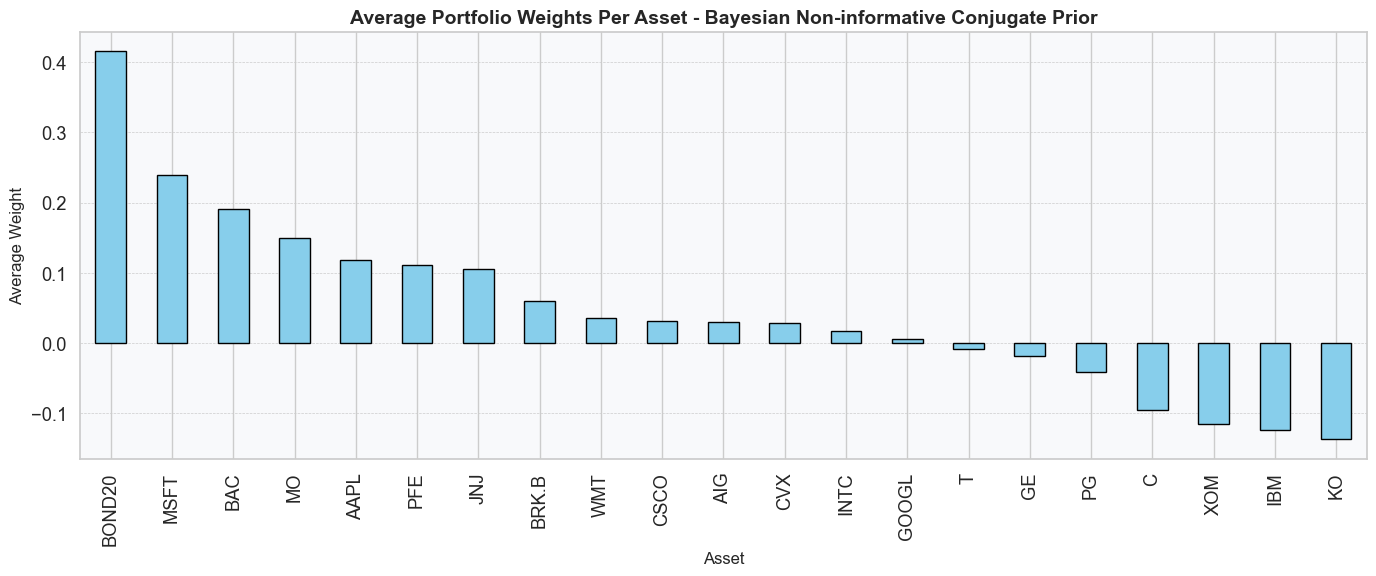

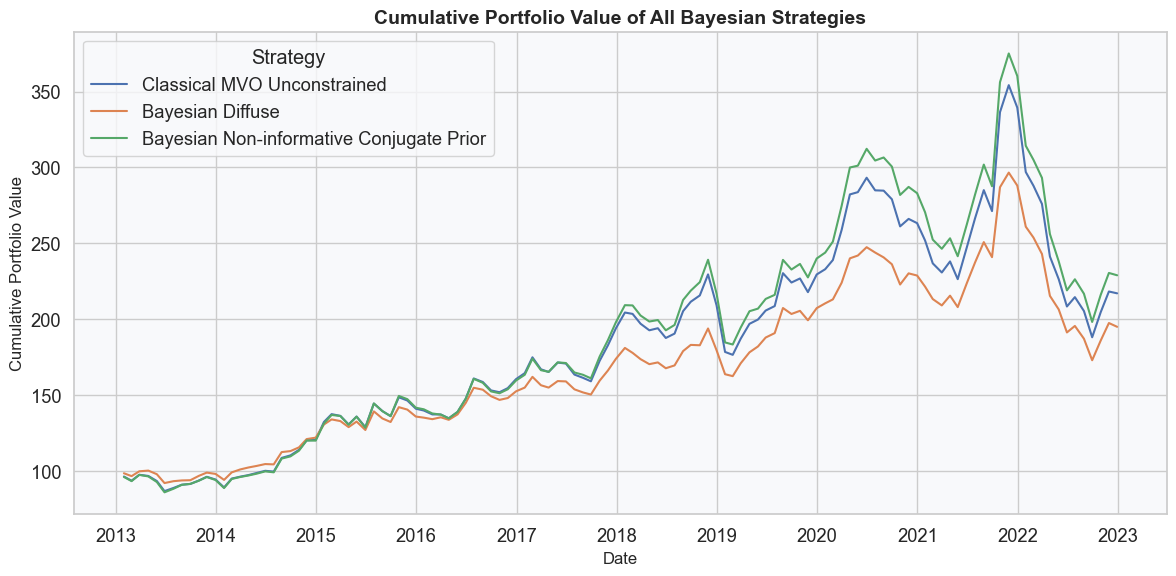

In [77]:
strategies = {
    "Bayesian Diffuse": (bayesian_diffuse_prior, {}),
#    "Bayesian Historical Conjugate Prior": (bayesian_hist_prior, {}),
    "Bayesian Non-informative Conjugate Prior": (bayesian_conjugate_prior, {})
}

results_bayes = {}
for name, (posterior_fn, kwargs) in strategies.items():
    print(f"\n\n\nRunning strategy: {name}")
    
    weights_df, returns_series = run_bayesian_strategy(
        excess_returns, estimation_window=60, holding_period=2,
        risk_limit=0.03, constraint_fn=unconstrained,  # <- fixed or replace if testing constraints
        posterior_fn=posterior_fn, **kwargs
    )

    # Convert excess returns to total by adding risk-free return
    rf_aligned = rf_final_aligned.reindex(returns_series.index, method='ffill')['rf_return']
    returns_total = returns_series + rf_aligned  # total returns

    # Recalculate cumulative returns
    cum_total = (1 + returns_total).cumprod() * 100  # rebased to $100

    # Store updated cumulative total returns instead of excess cumulative returns
    summary, diag, _, turnover = summarize_performance(weights_df, returns_series)
    results_bayes[name] = (summary, diag, cum_total, weights_df)

    '''
    # === Plot: Weight Evolution During Period ===
    if len(weights_df) >= 35:
        import seaborn as sns
        sns.set_theme(style="whitegrid")
        mid_idx = len(weights_df) // 2
        subset = weights_df.iloc[max(mid_idx - 10, 0): mid_idx + 10].copy()

        if isinstance(subset.index[0], pd.Timestamp):
            subset.index = subset.index.date

        fig, ax = plt.subplots(figsize=(14, 7))
        colors = plt.cm.tab20.colors

        subset.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=colors,
            edgecolor='black',
            linewidth=0.3
        )

        ax.set_title(f'Top Asset Weights During Crash (Month 25–30) - {name}', fontsize=16, weight='bold')
        ax.set_xlabel('Rebalance Date', fontsize=12)
        ax.set_ylabel('Portfolio Weight', fontsize=12)

        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title='Assets',
            fontsize=10,
            title_fontsize=11,
            frameon=False
        )

        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelsize=10)

        plt.tight_layout()
        plt.show()
    '''

    # === Plot: Average Weight Per Asset ===
    avg_weight = diag["Average Weight"].sort_values(ascending=False)
    plt.figure(figsize=(14, 6))
    avg_weight.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Average Portfolio Weights Per Asset - {name}", fontsize=14, weight='bold')
    plt.xlabel("Asset", fontsize=12)
    plt.ylabel("Average Weight", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



all_results = {
    "Classical MVO Unconstrained": results_class["Unconstrained"],
    **results_bayes
}

# === Unified Cumulative Return Plot ===
plt.figure(figsize=(12, 6))
for name, (_, _, cum_total, _) in all_results.items():
    plt.plot(cum_total.index, cum_total.values, label = name)

plt.title("Cumulative Portfolio Value of All Bayesian Strategies", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Portfolio Value", fontsize=12)
plt.grid(True)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()





Running strategy: Bayesian Diffuse_ridge


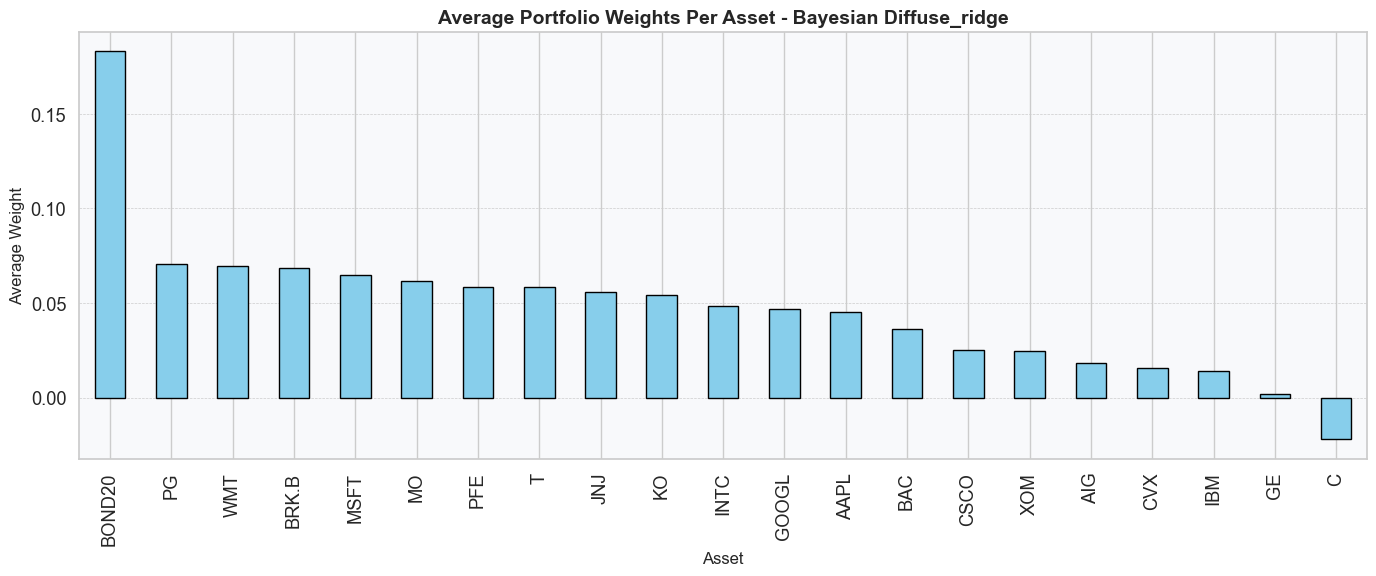




Running strategy: Bayesian Non-informative Conjugate Prior_ridge


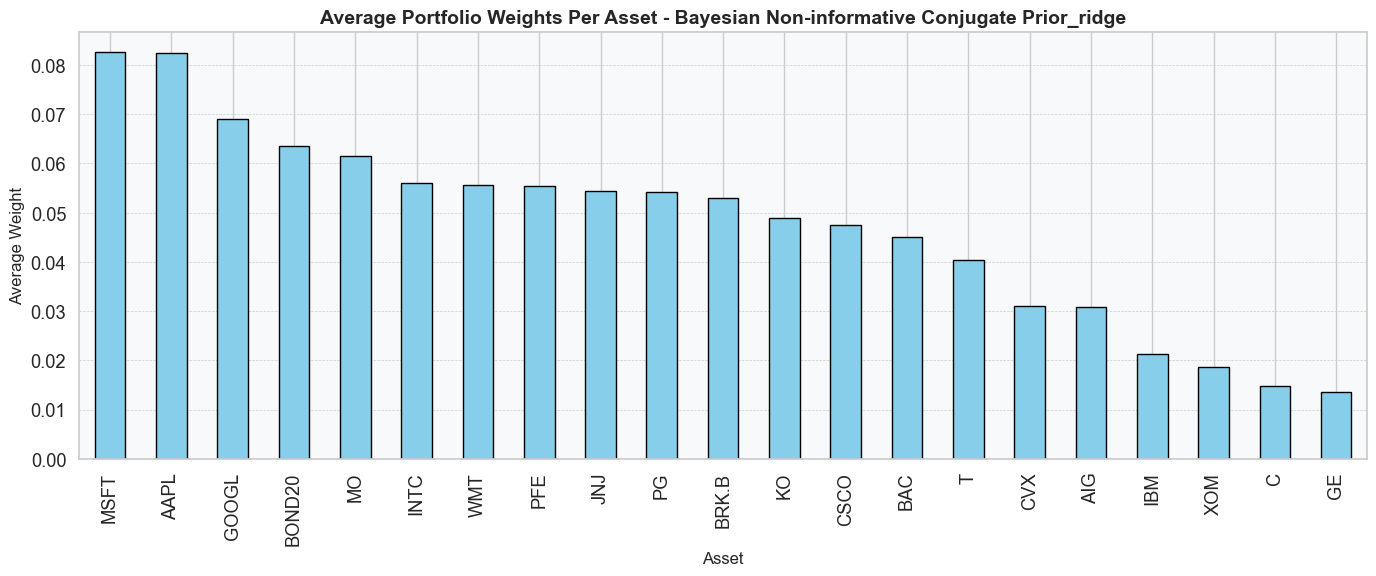

dict_keys(['Classical MVO Unconstrained Ridge', 'Bayesian Diffuse_ridge', 'Bayesian Non-informative Conjugate Prior_ridge'])


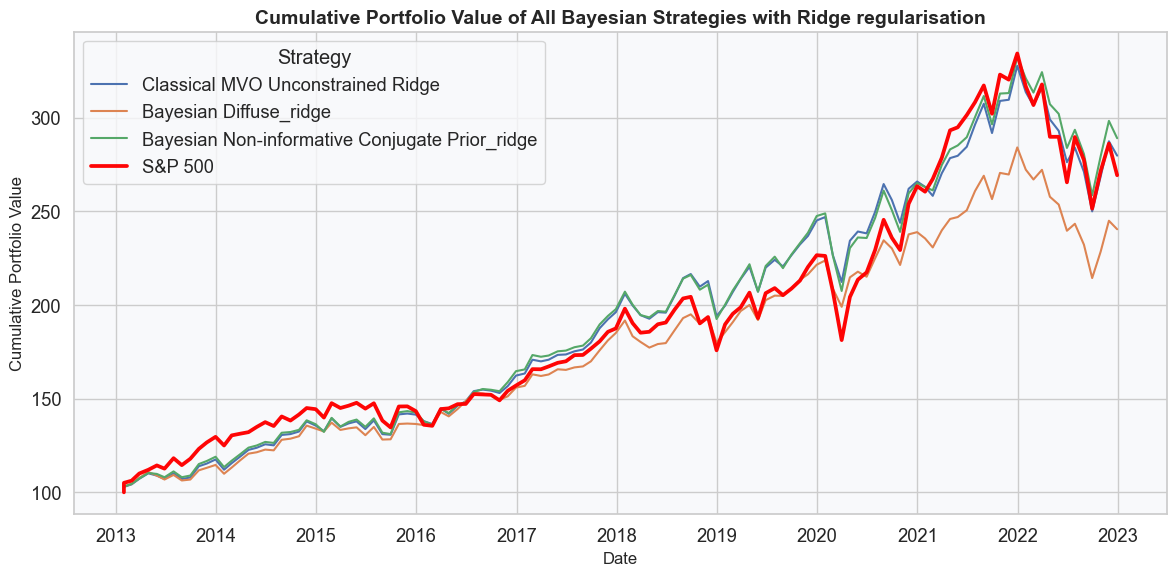

In [78]:
strategies = {
    "Bayesian Diffuse_ridge": (bayesian_diffuse_prior, {}),
#    "Bayesian Historical Conjugate Prior": (bayesian_hist_prior, {}),
    "Bayesian Non-informative Conjugate Prior_ridge": (bayesian_conjugate_prior, {})
}

results_bayes_ridge = {}
for name, (posterior_fn, kwargs) in strategies.items():
    print(f"\n\n\nRunning strategy: {name}")
    
    weights_df, returns_series = run_bayesian_strategy(
        excess_returns, estimation_window=60, holding_period=2,
        risk_limit=0.03, constraint_fn=unconstrained_ridge,  # <- fixed or replace if testing constraints
        posterior_fn=posterior_fn, ridge = True ,**kwargs
    )

    # Convert excess returns to total by adding risk-free return
    rf_aligned = rf_final_aligned.reindex(returns_series.index, method='ffill')['rf_return']
    returns_total = returns_series + rf_aligned  # total returns

    # Recalculate cumulative returns
    cum_total = (1 + returns_total).cumprod() * 100  # rebased to $100

    # Store updated cumulative total returns instead of excess cumulative returns
    summary, diag, _, turnover = summarize_performance(weights_df, returns_series)
    results_bayes_ridge[name] = (summary, diag, cum_total, weights_df)

    '''
    # === Plot: Weight Evolution During Period ===
    if len(weights_df) >= 35:
        import seaborn as sns
        sns.set_theme(style="whitegrid")
        mid_idx = len(weights_df) // 2
        subset = weights_df.iloc[max(mid_idx - 10, 0): mid_idx + 10].copy()

        if isinstance(subset.index[0], pd.Timestamp):
            subset.index = subset.index.date

        fig, ax = plt.subplots(figsize=(14, 7))
        colors = plt.cm.tab20.colors

        subset.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=colors,
            edgecolor='black',
            linewidth=0.3
        )

        ax.set_title(f'Top Asset Weights During Crash (Month 25–30) - {name}', fontsize=16, weight='bold')
        ax.set_xlabel('Rebalance Date', fontsize=12)
        ax.set_ylabel('Portfolio Weight', fontsize=12)

        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title='Assets',
            fontsize=10,
            title_fontsize=11,
            frameon=False
        )

        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelsize=10)

        plt.tight_layout()
        plt.show()
    '''

    # === Plot: Average Weight Per Asset ===
    avg_weight = diag["Average Weight"].sort_values(ascending=False)
    plt.figure(figsize=(14, 6))
    avg_weight.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Average Portfolio Weights Per Asset - {name}", fontsize=14, weight='bold')
    plt.xlabel("Asset", fontsize=12)
    plt.ylabel("Average Weight", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


all_results = {
    "Classical MVO Unconstrained Ridge": results_class["Unconstrained Ridge"],
    **results_bayes_ridge
}

print(all_results.keys())

# === Unified Cumulative Return Plot ===
plt.figure(figsize=(12, 6))
for name, (_, _, cum_total, _) in all_results.items():
    plt.plot(cum_total.index, cum_total.values, label = name)

aligned_bench = pd.concat([pd.Series([100], index=[benchmark_subset.index[0]]), benchmark_subset]).sort_index()
plt.plot(
    aligned_bench.index, aligned_bench.values,
    linewidth=2.7, color='red', alpha=0.98,
    label="S&P 500", zorder=3
)

plt.title("Cumulative Portfolio Value of All Bayesian Strategies with Ridge regularisation", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Portfolio Value", fontsize=12)
plt.grid(True)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()


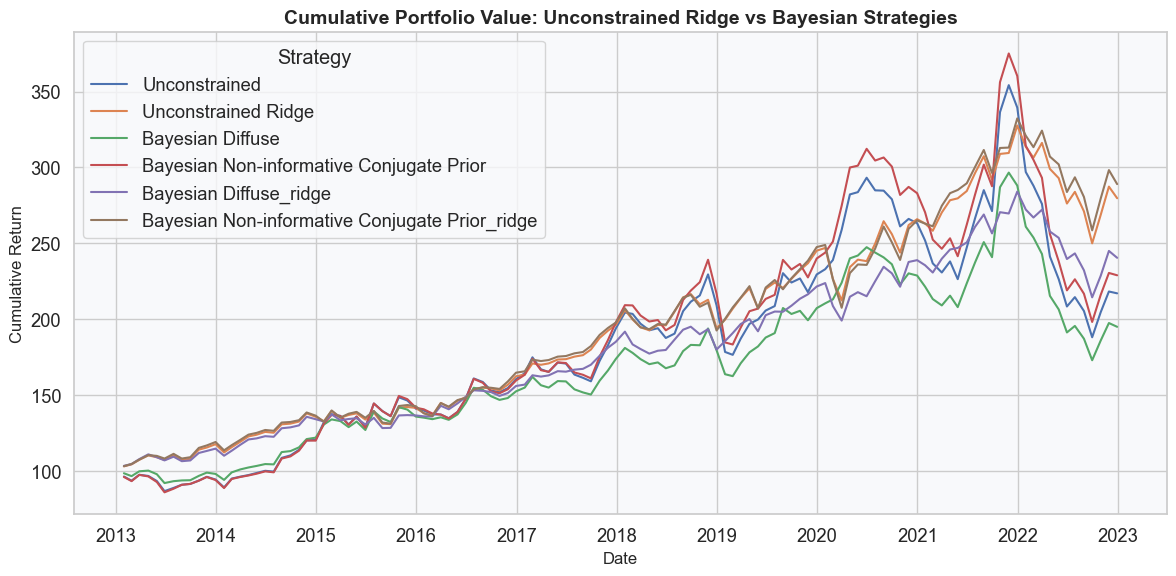

In [79]:
all_results = {
    "Unconstrained": results_class["Unconstrained"],
    "Unconstrained Ridge": results_class["Unconstrained Ridge"],
    **results_bayes,
    **results_bayes_ridge
}

# Unified Cumulative Return Plot
plt.figure(figsize=(12, 6))
for name, (_, _, cum_total, _) in all_results.items():
    plt.plot(cum_total.index, cum_total.values, label=name)

plt.title("Cumulative Portfolio Value: Unconstrained Ridge vs Bayesian Strategies", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(title="Strategy")
plt.grid(True)
plt.tight_layout()
plt.show()

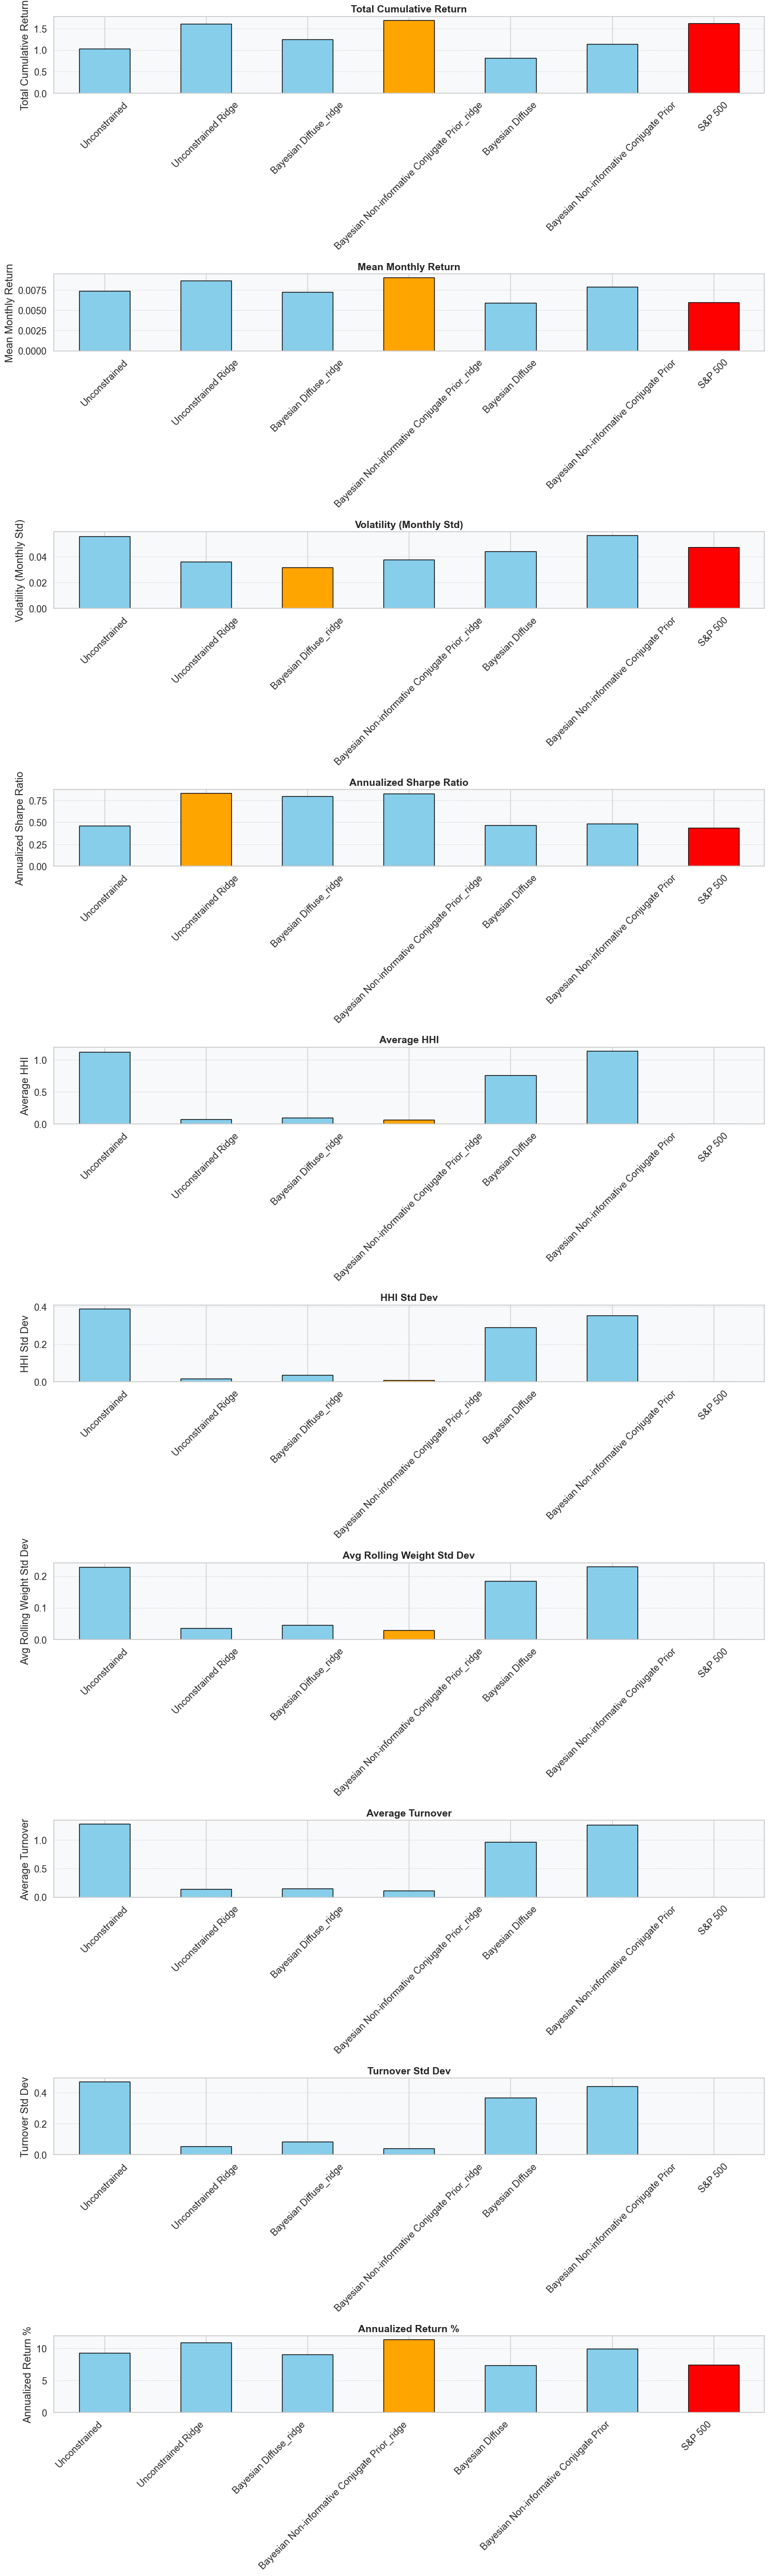

In [80]:
# === Extract "Unconstrained" from classical results ===
unconstrained_summary = {"Unconstrained": results_class["Unconstrained"][0].iloc[0]}
unconstrained_ridge_summary = {"Unconstrained Ridge": results_class["Unconstrained Ridge"][0].iloc[0]}

# === Collect Bayesian summaries ===
summary_baye_ridge = {name: result[0].iloc[0] for name, result in results_bayes_ridge.items()}

# === Collect Bayesian summaries ===
summary_bayes = {name: result[0].iloc[0] for name, result in results_bayes.items()}

# === Combine ===
summary_combined = pd.DataFrame({**unconstrained_summary, **unconstrained_ridge_summary,  **summary_baye_ridge, **summary_bayes, "S&P 500": benchmark_metrics.iloc[0]}).T


# === Metrics to plot ===
metrics_to_plot = [
    "Total Cumulative Return",
    "Mean Monthly Return",
    "Volatility (Monthly Std)",
    "Annualized Sharpe Ratio",
    "Average HHI",
    "HHI Std Dev",
    "Avg Rolling Weight Std Dev",
    "Average Turnover",
    "Turnover Std Dev",
    "Annualized Return %"
]

# === Plotting ===
# Define which metrics should be maximized (the rest will be minimized)
maximize_metrics = {
    "Total Cumulative Return",
    "Mean Monthly Return",
    "Annualized Sharpe Ratio",
    "Annualized Return %"
}

fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 5 * len(metrics_to_plot))) # Adjusted figure size

for i, metric in enumerate(metrics_to_plot):
    values = summary_combined[metric]
    best_idx = values.idxmax() if metric in maximize_metrics else values.idxmin()
    colors = ['red' if idx == 'S&P 500' else 'orange' if idx == best_idx else 'skyblue' for idx in values.index]

    bars = values.plot(kind='bar', ax=axes[i], edgecolor='black', color=colors)
    axes[i].set_title(metric, fontsize=14, weight='bold')
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', linewidth=0.5)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('') # Remove redundant x-axis label

# Align the x-axis labels to the right
plt.setp(axes[i].get_xticklabels(), ha="right")

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

In [81]:
# === Extract classical strategy summaries ===
unconstrained_summary = {"Unconstrained": results_class["Unconstrained"][0].iloc[0]}
unconstrained_ridge_summary = {"Unconstrained Ridge": results_class["Unconstrained Ridge"][0].iloc[0]}

# === Extract Bayesian strategy summaries ===
summary_bayes = {name.replace("_ridge", ""): result[0].iloc[0] for name, result in results_bayes.items()}
summary_bayes_ridge = {name: result[0].iloc[0] for name, result in results_bayes_ridge.items()}

# === Combine grouped summaries ===
summary_unregularized = pd.DataFrame({
    **unconstrained_summary,
    **summary_bayes,
    "S&P 500": benchmark_metrics.iloc[0]
}).T

summary_ridge = pd.DataFrame({
    **unconstrained_ridge_summary,
    **summary_bayes_ridge,
    "S&P 500": benchmark_metrics.iloc[0]
}).T

# === Display for verification ===
print("=== Unregularized ===")
display(summary_unregularized.round(4))

print("\n=== Ridge Regularised ===")
display(summary_ridge.round(4))

=== Unregularized ===


Total Cumulative Return  \
Unconstrained                                              1.0253   
Bayesian Diffuse                                           0.8192   
Bayesian Non-informative Conjugate Prior                   1.1365   
S&P 500                                                    1.6148   

                                          Mean Monthly Return  \
Unconstrained                                          0.0074   
Bayesian Diffuse                                       0.0059   
Bayesian Non-informative Conjugate Prior               0.0079   
S&P 500                                                0.0060   

                                          Volatility (Monthly Std)  \
Unconstrained                                               0.0554   
Bayesian Diffuse                                            0.0439   
Bayesian Non-informative Conjugate Prior                    0.0562   
S&P 500                                                     0.0472   

                                          Annualized Sharpe Ratio  \
Unconstrained                                              0.4627   
Bayesian Diffuse                                           0.4690   
Bayesian Non-informative Conjugate Prior                   0.4863   
S&P 500                                                    0.4391   

                                          Annualized Return %  Average HHI  \
Unconstrained                                          9.2446       1.1266   
Bayesian Diffuse                                       7.3662       0.7591   
Bayesian Non-informative Conjugate Prior               9.8931       1.1419   
S&P 500                                                7.4249          NaN   

                                          HHI Std Dev  \
Unconstrained                                  0.3897   
Bayesian Diffuse                               0.2894   
Bayesian Non-informative Conjugate Prior       0.3527   
S&P 500                                           NaN   

                                          Avg Rolling Weight Std Dev  \
Unconstrained                                                 0.2285   
Bayesian Diffuse                                              0.1849   
Bayesian Non-informative Conjugate Prior                      0.2309   
S&P 500                                                          NaN   

                                          Average Turnover  Turnover Std Dev  
Unconstrained                                       1.2776            0.4703  
Bayesian Diffuse                                    0.9692            0.3680  
Bayesian Non-informative Conjugate Prior            1.2654            0.4429  
S&P 500                                             0.0000            0.0000


=== Ridge Regularised ===


Total Cumulative Return  \
Unconstrained Ridge                                              1.6101   
Bayesian Diffuse_ridge                                           1.2435   
Bayesian Non-informative Conjugate Prior_ridge                   1.6968   
S&P 500                                                          1.6148   

                                                Mean Monthly Return  \
Unconstrained Ridge                                          0.0087   
Bayesian Diffuse_ridge                                       0.0073   
Bayesian Non-informative Conjugate Prior_ridge               0.0090   
S&P 500                                                      0.0060   

                                                Volatility (Monthly Std)  \
Unconstrained Ridge                                               0.0361   
Bayesian Diffuse_ridge                                            0.0316   
Bayesian Non-informative Conjugate Prior_ridge                    0.0378   
S&P 500                                                           0.0472   

                                                Annualized Sharpe Ratio  \
Unconstrained Ridge                                              0.8318   
Bayesian Diffuse_ridge                                           0.7944   
Bayesian Non-informative Conjugate Prior_ridge                   0.8266   
S&P 500                                                          0.4391   

                                                Annualized Return %  \
Unconstrained Ridge                                         10.9216   
Bayesian Diffuse_ridge                                       9.0597   
Bayesian Non-informative Conjugate Prior_ridge              11.3643   
S&P 500                                                      7.4249   

                                                Average HHI  HHI Std Dev  \
Unconstrained Ridge                                  0.0748       0.0155   
Bayesian Diffuse_ridge                               0.0950       0.0350   
Bayesian Non-informative Conjugate Prior_ridge       0.0661       0.0095   
S&P 500                                                 NaN          NaN   

                                                Avg Rolling Weight Std Dev  \
Unconstrained Ridge                                                 0.0355   
Bayesian Diffuse_ridge                                              0.0461   
Bayesian Non-informative Conjugate Prior_ridge                      0.0294   
S&P 500                                                                NaN   

                                                Average Turnover  \
Unconstrained Ridge                                       0.1393   
Bayesian Diffuse_ridge                                    0.1462   
Bayesian Non-informative Conjugate Prior_ridge            0.1177   
S&P 500                                                   0.0000   

                                                Turnover Std Dev  
Unconstrained Ridge                                       0.0542  
Bayesian Diffuse_ridge                                    0.0837  
Bayesian Non-informative Conjugate Prior_ridge            0.0430  
S&P 500                                                   0.0000

# Bayesian CAPM

In [82]:
excess_returns

T     GOOGL        MO       AIG      AAPL       BAC  \
2008-01-31 -0.066547 -0.186227  0.000476 -0.059421 -0.318943  0.067741   
2008-02-29 -0.096458 -0.166387 -0.036333 -0.148903 -0.077757 -0.101255   
2008-03-31  0.097901 -0.066903  0.003606 -0.074496  0.146090 -0.031671   
2008-04-30  0.020132  0.302795 -0.100116  0.067191  0.211178 -0.010777   
2008-05-30  0.029724  0.019025  0.111983 -0.221796  0.084065 -0.095050   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.067880 -0.071487  0.026876 -0.002238 -0.032989 -0.007767   
2022-09-30 -0.127430 -0.118154 -0.086222 -0.078331 -0.122979 -0.096914   
2022-10-31  0.204158 -0.014246  0.143536  0.198177  0.107223  0.191049   
2022-11-30  0.054484  0.065451  0.003587  0.104080 -0.036242  0.047109   
2022-12-30 -0.048238 -0.129462 -0.001610  0.004017 -0.125386 -0.122268   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2008-01-31 -0.041851 -0.110307 -0.097239 -0.034572  ... -0.080113 -0.048432   
2008-02-29  0.028044  0.046560 -0.005858 -0.159692  ...  0.009743 -0.055384   
2008-03-31 -0.048869 -0.016727 -0.014026 -0.098310  ... -0.029654  0.115051   
2008-04-30  0.002356  0.125389  0.063325  0.178722  ...  0.099361 -0.117472   
2008-05-30  0.004960  0.036945  0.041105 -0.122109  ... -0.043028 -0.061568   
...              ...       ...       ...       ...  ...       ...       ...   
2022-08-31 -0.069136 -0.028107 -0.016179 -0.061390  ... -0.006598 -0.008211   
2022-09-30 -0.037221 -0.093043 -0.107548 -0.148284  ... -0.088622 -0.157912   
2022-10-31  0.092587  0.256807  0.142922  0.098224  ...  0.266828  0.254496   
2022-11-30  0.076047  0.018059  0.091318  0.063612  ...  0.009882  0.101758   
2022-12-30 -0.027201 -0.023952 -0.044947 -0.068802  ... -0.012454 -0.027540   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2008-01-31 -0.210855 -0.011461 -0.055676 -0.086573  0.025414 -0.106498   
2008-02-29 -0.048885  0.065386 -0.013484 -0.163641 -0.033902  0.010249   
2008-03-31  0.058870  0.009516  0.045240  0.041660 -0.062318  0.057053   
2008-04-30  0.049974  0.047272  0.033205  0.003916 -0.040195 -0.038408   
2008-05-30  0.046602  0.075454  0.000623 -0.004173 -0.022399 -0.015931   
...              ...       ...       ...       ...       ...       ...   
2022-08-31 -0.112703 -0.007128 -0.070899 -0.068284 -0.106386 -0.008835   
2022-09-30 -0.194671 -0.077051  0.010518 -0.111269 -0.034503 -0.086749   
2022-10-31  0.100893  0.161631  0.062621 -0.005634  0.061429  0.071599   
2022-11-30  0.067411  0.085541  0.026547  0.098942  0.082387  0.104483   
2022-12-30 -0.124164 -0.056907 -0.010697 -0.063158  0.019029  0.012977   

                 WMT    BOND20  
2008-01-31  0.065233  0.023386  
2008-02-29 -0.024033 -0.000964  
2008-03-31  0.065374  0.010316  
2008-04-30  0.099590 -0.019890  
2008-05-30 -0.001060 -0.030622  
...              ...       ...  
2022-08-31  0.006175 -0.048701  
2022-09-30 -0.023503 -0.069947  
2022-10-31  0.095051 -0.043420  
2022-11-30  0.067779  0.068095  
2022-12-30 -0.069180 -0.028885  

[180 rows x 21 columns]

In [83]:
historical_excess_returns

T     GOOGL        MO       AIG      AAPL       BAC  \
2002-01-31 -0.038770       NaN  0.091511 -0.067522  0.127366 -0.000130   
2002-02-28  0.009005       NaN  0.049479 -0.003270 -0.123577  0.022707   
2002-03-28 -0.011980       NaN  0.009795 -0.026149  0.089374  0.062234   
2002-04-30 -0.164662       NaN  0.031948 -0.043331  0.023881  0.064101   
2002-05-31  0.102516       NaN  0.050334 -0.032581 -0.041443  0.044468   
...              ...       ...       ...       ...       ...       ...   
2007-08-31  0.013847  0.006010  0.039947  0.024074  0.046718  0.064463   
2007-09-28  0.056915  0.096677  0.008250  0.023746  0.103963  0.000254   
2007-10-31 -0.006762  0.243458  0.046038 -0.069824  0.234839 -0.042448   
2007-11-30 -0.089013 -0.023149  0.060138 -0.082403 -0.044042 -0.047879   
2007-12-31  0.084643 -0.005223 -0.018889  0.003335  0.084008 -0.094727   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2002-01-31 -0.026902 -0.066237  0.091918 -0.059246  ... -0.007762 -0.074505   
2002-02-28 -0.013206  0.014581 -0.280702 -0.046768  ...  0.062099  0.039775   
2002-03-28 -0.025969  0.067634  0.184996  0.092956  ...  0.059850 -0.028682   
2002-04-30  0.028566 -0.040905 -0.136140 -0.127074  ... -0.084973 -0.159011   
2002-05-31  0.014367  0.012825  0.075657 -0.000090  ... -0.001725 -0.014471   
...              ...       ...       ...       ...  ...       ...       ...   
2007-08-31  0.073530  0.031841  0.099832  0.013968  ...  0.006875 -0.001446   
2007-09-28  0.004192  0.062033  0.033620 -0.008764  ...  0.075385  0.068008   
2007-10-31  0.114614 -0.024982 -0.004972 -0.105069  ... -0.009020 -0.008659   
2007-11-30  0.056596 -0.037879 -0.155797 -0.195710  ... -0.030306 -0.073075   
2007-12-31  0.007228  0.060317 -0.036938 -0.118946  ...  0.047778 -0.026796   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2002-01-31  0.112748 -0.109453 -0.028305 -0.039741  0.044270  0.035627   
2002-02-28 -0.186055 -0.090667  0.060667 -0.085697 -0.015328  0.036666   
2002-03-28  0.063740  0.058518  0.065093  0.032359 -0.031194  0.061098   
2002-04-30 -0.060659 -0.196083 -0.018250 -0.134945 -0.086773  0.004637   
2002-05-31 -0.035380 -0.039203 -0.037571 -0.027308 -0.046043 -0.009342   
...              ...       ...       ...       ...       ...       ...   
2007-08-31  0.090657  0.053918  0.023898 -0.009803  0.064623  0.051487   
2007-09-28 -0.000012  0.005228  0.058995  0.021125 -0.020790  0.072733   
2007-10-31  0.037355 -0.017123 -0.010929  0.246629  0.004506 -0.009544   
2007-11-30 -0.029648 -0.094115  0.042456 -0.087563 -0.026102  0.061095   
2007-12-31  0.019209  0.024732 -0.018383  0.056494 -0.046380 -0.010868   

                 WMT    BOND20  
2002-01-31  0.040823  0.010087  
2002-02-28  0.032436  0.011129  
2002-03-28 -0.011649 -0.041856  
2002-04-30 -0.090212  0.038667  
2002-05-31 -0.032983  0.000057  
...              ...       ...  
2007-08-31 -0.049986  0.013200  
2007-09-28 -0.003826 -0.002837  
2007-10-31  0.032877  0.012918  
2007-11-30  0.056153  0.045431  
2007-12-31 -0.006162 -0.009097  

[72 rows x 21 columns]

In [84]:
benchmark_excess_returns

2008-01-31   -0.063466
2008-02-29   -0.036129
2008-03-31   -0.007686
2008-04-30    0.046530
2008-05-30    0.009657
                ...   
2022-08-31   -0.044292
2022-09-30   -0.095398
2022-10-31    0.077535
2022-11-30    0.050640
2022-12-30   -0.062084
Length: 180, dtype: float64

In [85]:
excess_sp500_pre

sp500_return
2002-01-31     -0.016975
2002-02-28     -0.022175
2002-03-28      0.035330
2002-04-30     -0.062886
2002-05-31     -0.010557
...                  ...
2007-08-31      0.008580
2007-09-28      0.031510
2007-10-31      0.011960
2007-11-30     -0.047390
2007-12-31     -0.011658

[72 rows x 1 columns]

In [86]:
excess_returns.index = pd.to_datetime(excess_returns.index)
benchmark_excess_returns.index = pd.to_datetime(benchmark_excess_returns.index)

In [87]:
from numpy.linalg import inv

def bayesian_capm_estimation(asset_returns, benchmark_returns, 
                                       a0=0.0, beta0=1.0, 
                                       sigma_alpha_sq=1.0, sigma_beta_sq=1.0, 
                                       nu0=1, c0_sq=0.1):
    """
    Calculates the predictive mean vector and covariance matrix for a set of assets
    using the exact joint-conjugate Bayesian CAPM model described in the thesis text.

    This function aligns precisely with the theoretical specification:
    - It uses a joint conjugate Normal-Inverse-Chi-Squared prior for the 
      regression parameters (alpha_i, beta_i) and idiosyncratic variance (sigma_e_i^2).
    - It uses a non-informative Jeffrey's prior for the benchmark parameters.
    - It calculates the posterior and predictive moments using the exact formulas
      derived in the text.

    Args:
        asset_returns (pd.DataFrame): DataFrame where each column is the excess return series for an asset.
                                      Must have a DateTimeIndex or similar index for alignment.
        benchmark_returns (pd.Series or pd.DataFrame): Series or single-column DataFrame of excess returns 
                                                       for the benchmark. Must have the same index type as asset_returns.
        a0 (float): Prior mean for the mispricing component, alpha. Corresponds to a_0. Default is 0.
        beta0 (float): Prior mean for the market beta. Corresponds to beta_0. Default is 1.
        sigma_alpha_sq (float): Prior variance for alpha. This is interpreted as the diagonal
                                element of the prior matrix Omega_0, not including the sigma_e^2 term.
        sigma_beta_sq (float): Prior variance for beta. This is the other diagonal element of Omega_0.
        nu0 (float): Prior degrees of freedom for the idiosyncratic variance. Corresponds to nu_0.
        c0_sq (float): Prior scale parameter for the idiosyncratic variance. Corresponds to c_0^2.

    Returns:
        tuple: A tuple containing:
            - pred_mean_vector (np.array): The predictive mean vector of asset returns (mu_pred).
            - pred_cov_matrix (np.array): The predictive covariance matrix of asset returns (Sigma_pred).
    """
    # --- Data Preprocessing ---
    # Ensure consistent time periods by keeping only rows with no missing data across all assets
    filtered_assets = asset_returns.dropna()
    aligned_benchmark = benchmark_returns.reindex(filtered_assets.index)

    R = filtered_assets.values
    S = aligned_benchmark.values.flatten() # Ensure S is a 1D array
    
    T, N = R.shape
    
    if T <= 3:
        raise ValueError(f"Number of observations (T={T}) must be greater than 3 for predictive moments to be defined.")
    if nu0 + T <= 2:
        raise ValueError(f"Sum of prior degrees of freedom (nu0={nu0}) and T={T} must be > 2 for posterior expectations to be defined.")

    # --- Stage 1: Benchmark Predictive Moments (Posterior from Jeffrey's Prior) ---
    S_bar = np.mean(S)
    SS_S = np.sum((S - S_bar)**2)
    
    # Predictive variance of S_{t+1}, per the text's formula Var(S_{t+1} | S)
    # This formula corresponds to a Student's t-distribution for the predictive density.
    var_S_pred = ((T + 1) / (T * (T - 3))) * SS_S

    # --- Stage 2: Asset-by-Asset Parameter Estimation ---
    
    # Setup Priors. Note: The text's notation for Omega_0 is slightly ambiguous.
    # We follow the standard interpretation where the prior covariance for b_i is
    # sigma_e_i^2 * Omega_0. Here, we define Omega_0^{-1}.
    b0 = np.array([a0, beta0])
    Omega0_inv = np.diag([1/sigma_alpha_sq, 1/sigma_beta_sq])
    
    # Design Matrix X = [1, S_t]
    X = np.column_stack([np.ones(T), S])
    XTX = X.T @ X

    pred_means = np.zeros(N)
    pred_variances = np.zeros(N)
    beta_stars = np.zeros(N) # Store posterior mean betas for covariance calculation

    for i in range(N):
        R_i = R[:, i]
        
        # --- Posterior Distributions for Asset i ---
        
        # OLS estimate, which is also the Maximum Likelihood Estimate (MLE)
        b_hat_i = inv(XTX) @ X.T @ R_i
        
        # Posterior precision and covariance for b_i
        Omega_i_star_inv = Omega0_inv + XTX
        Omega_i_star = inv(Omega_i_star_inv)
        
        # Posterior mean for b_i = (alpha_i, beta_i), per text formula
        b_i_star = Omega_i_star @ (Omega0_inv @ b0 + XTX @ b_hat_i)
        alpha_i_star, beta_i_star = b_i_star
        beta_stars[i] = beta_i_star

        # Posterior parameters for idiosyncratic variance sigma_e_i^2
        nu_i_star = nu0 + T
        
        # Residual Sum of Squares (RSS) from the regression model
        rss = (R_i - X @ b_hat_i).T @ (R_i - X @ b_hat_i)
        
        # --- THIS IS THE KEY CORRECTION ---
        # The shrinkage term is now calculated exactly as specified in the thesis.
        # K_i in the text is (Omega_0^{-1} + X'X)^{-1}, which is Omega_i_star.
        K_i = Omega_i_star
        shrinkage = (b0 - b_hat_i).T @ K_i @ (b0 - b_hat_i)
        
        # Posterior scale parameter c_i^{*2}, per text formula
        c_i_star_sq = (1/nu_i_star) * (nu0 * c0_sq + rss + shrinkage)
        
        # Expected value of the posterior idiosyncratic variance
        # E[sigma_e_i^2 | Data] = (nu_i^* * c_i^{*2}) / (nu_i^* - 2)
        exp_sigma_sq_i = (nu_i_star * c_i_star_sq) / (nu_i_star - 2)

        # --- Predictive Moments for Asset i ---

        # Predictive Mean for R_{i,t+1}, per text formula
        pred_means[i] = alpha_i_star + beta_i_star * S_bar
        
        # Predictive Variance for R_{i,t+1}, per text formula Eq. (15)
        # This formula combines three sources of uncertainty:
        # 1. Idiosyncratic variance (E[sigma_e^2])
        # 2. Parameter uncertainty in alpha and beta (Var[alpha_i + beta_i * S_bar])
        # 3. Benchmark uncertainty (E[beta_i^2] * Var[S_{t+1}])
        
        x_tilde = np.array([1, S_bar])
        
        # Posterior covariance of b_i = (alpha_i, beta_i)
        # Cov(b_i | Data) = E[sigma_e_i^2 | Data] * Omega_i_star
        cov_b_i_posterior = exp_sigma_sq_i * Omega_i_star
        
        var_from_coeffs = x_tilde.T @ cov_b_i_posterior @ x_tilde
        
        # E[beta_i^2 | Data] = Var(beta_i | Data) + (E[beta_i | Data])^2
        var_beta_i_posterior = cov_b_i_posterior[1, 1]
        exp_beta_i_sq = var_beta_i_posterior + beta_i_star**2
        
        var_from_market = exp_beta_i_sq * var_S_pred
        
        pred_variances[i] = exp_sigma_sq_i + var_from_coeffs + var_from_market
        
    # --- Assemble Final Predictive Mean Vector and Covariance Matrix ---
    pred_mean_vector = pred_means
    
    # Start with diagonal matrix of predictive variances
    pred_cov_matrix = np.diag(pred_variances)
    
    # Fill in the off-diagonal elements (predictive covariances)
    # Cov(R_i, R_j) = beta_i^* * beta_j^* * Var(S_{t+1}), per text formula
    for i in range(N):
        for j in range(i + 1, N):
            cov_ij = beta_stars[i] * beta_stars[j] * var_S_pred
            pred_cov_matrix[i, j] = cov_ij
            pred_cov_matrix[j, i] = cov_ij

    return pred_mean_vector, pred_cov_matrix

def bayesian_capm_moments(est_asset_returns, est_benchmark_returns, 
                          a0=0.0, beta0=1.0, sigma_alpha_sq=1.0, sigma_beta_sq=1.0, nu0=1, c0_sq=0.1):
    """
    Wrapper to provide mean and covariance for rolling window strategies using Bayesian CAPM.
    """
    mu_pred, Sigma_pred = bayesian_capm_estimation(
        est_asset_returns, est_benchmark_returns,
        a0=a0, beta0=beta0,
        sigma_alpha_sq=sigma_alpha_sq, sigma_beta_sq=sigma_beta_sq,
        nu0=nu0, c0_sq=c0_sq
    )
    return mu_pred, Sigma_pred

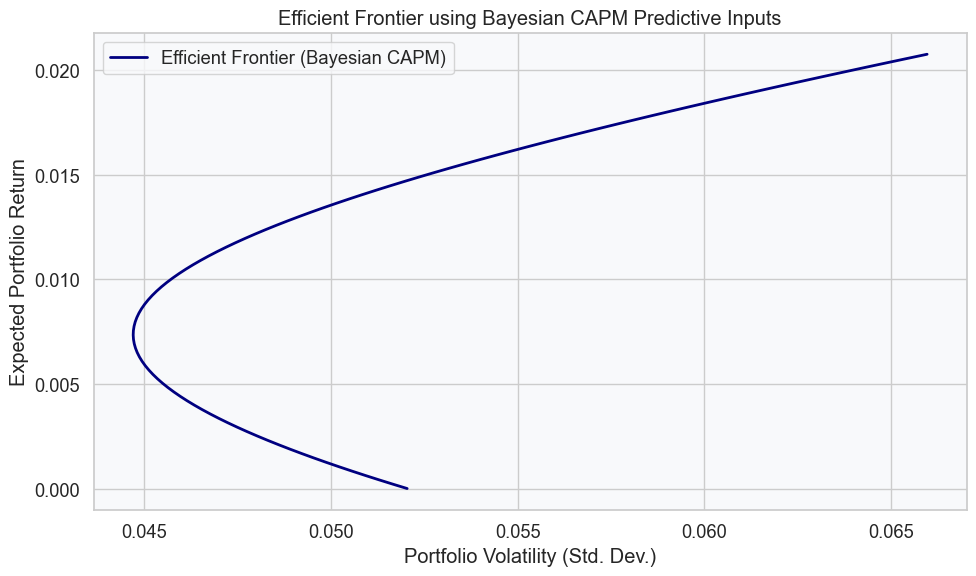

In [88]:
# --- 1. Get Bayesian CAPM predictive inputs ---
mu_capm, Sigma_capm = bayesian_capm_estimation(excess_returns, benchmark_excess_returns)

# --- 2. Compute the efficient frontier using your existing function ---
target_returns_capm, vols_capm = compute_efficient_frontier_from_moments(mu_capm, Sigma_capm)

# --- 3. Plot the efficient frontier ---
plt.figure(figsize=(10, 6))
plt.plot(vols_capm, target_returns_capm, label="Efficient Frontier (Bayesian CAPM)", linewidth=2, color='navy')
plt.xlabel("Portfolio Volatility (Std. Dev.)")
plt.ylabel("Expected Portfolio Return")
plt.title("Efficient Frontier using Bayesian CAPM Predictive Inputs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
def compute_gmv_vol(mu, Sigma):
    import numpy as np
    import cvxpy as cp
    N = len(mu)
    w = cp.Variable(N)
    risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1])
    prob.solve()
    if w.value is not None:
        min_vol = np.sqrt(risk.value)
        return float(min_vol)
    else:
        return np.nan  # Or raise, or handle as needed

In [90]:
# MVO with Bayesian CAPM estimates

def capm_mvo_posterior(est_asset_returns, est_benchmark_returns):
    mu_capm, Sigma_capm = bayesian_capm_estimation(
        est_asset_returns, est_benchmark_returns
        # Optionally: tweak prior hyperparameters here if desired
    )
    return mu_capm, Sigma_capm

In [91]:
# COnjugate with Bayesian CAPM prior

def bayes_conjugate_capm_prior(est_asset_returns, est_benchmark_returns):
    N = est_asset_returns.shape[1]
    v0 = N + 10  # more informative prior, default was N + 2
    tau = 45     # increase prior confidence in the CAPM-implied mean
    mu_capm, Sigma_capm = bayesian_capm_estimation(est_asset_returns, est_benchmark_returns)
    eta = mu_capm
    Omega = Sigma_capm * (v0 - N - 1)
    mu_bayes, Sigma_bayes = informative_bayes_predictive(
        est_asset_returns, eta=eta, tau=tau, nu=v0, Omega=Omega
    )
    return mu_bayes, Sigma_bayes

In [92]:
def run_custom_strategy(
    excess_returns,                # DataFrame: asset excess returns
    benchmark_returns,             # Series: benchmark excess returns
    estimation_window=60, 
    holding_period=2, 
    risk_limit=0.03, 
    constraint_fn=None,            # Constraint function, e.g. unconstrained
    posterior_fn=None,             # Function returning (mu, Sigma) given est_data, bench_window
    ridge=False, 
    lambda_ridge=0.1,
    adaptive_risk=False   # <--- new argument
):
    weights_over_time = []
    portfolio_returns = []
    portfolio_return_dates = []
    rebalance_dates = []
    T = len(excess_returns)
    asset_names_all = set()

    for start in range(0, T - estimation_window - holding_period + 1, holding_period):
        est_data = excess_returns.iloc[start:start+estimation_window].dropna(axis=1)
        bench_window = benchmark_returns.iloc[start:start+estimation_window]
        if est_data.shape[1] == 0:
            continue
        hold_data = excess_returns.iloc[start+estimation_window:start+estimation_window+holding_period]
        hold_data = hold_data[est_data.columns]
        hold_dates = hold_data.index

        # === Portfolio Moments: call user-supplied function ===
        mu, Sigma = posterior_fn(est_data, bench_window)

        # Apply adaptive risk only for Bayesian CAPM
        if adaptive_risk:
            gmv_vol = compute_gmv_vol(mu, Sigma)
            risk_limit_window = max(0.03, gmv_vol)
        else:
            risk_limit_window = risk_limit

        weights = solve_portfolio(
            mu, Sigma, risk_limit_window, constraint_fn, ridge=ridge, lambda_ridge=lambda_ridge
        )
        if weights is not None:
            port_rets = hold_data @ weights
            portfolio_returns.extend(port_rets)
            portfolio_return_dates.extend(hold_dates)
            weights_over_time.append(pd.Series(weights, index=est_data.columns))
            rebalance_dates.append(hold_dates[0])
            asset_names_all.update(est_data.columns)

    weights_df = pd.DataFrame(weights_over_time, index=rebalance_dates).reindex(columns=sorted(asset_names_all)).fillna(0)
    returns_series = pd.Series(portfolio_returns, name="Custom Portfolio excess_returns", index=portfolio_return_dates)
    return weights_df, returns_series


In [93]:
capm_strategies = {
    "Naive MVO (Bayesian CAPM)": (capm_mvo_posterior, {"ridge": False}),
    "Bayesian Conjugate (CAPM Prior)": (bayes_conjugate_capm_prior, {"ridge": False}),
    "Bayesian Conjugate (CAPM Prior) Ridge": (bayes_conjugate_capm_prior, {"ridge": True})
}





Running strategy: Naive MVO (Bayesian CAPM)


/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


                AAPL       AIG       BAC    BOND20     BRK.B         C  \
2013-01-31  0.020127 -0.003533 -0.006579  0.033944  0.063966 -0.007386   
2013-03-28  0.030974 -0.003453 -0.006666  0.032251  0.062158 -0.007308   
2013-05-31  0.034873 -0.003453 -0.006842  0.031947  0.061529 -0.007326   
2013-07-31  0.036627 -0.003064 -0.005577  0.030498  0.059569 -0.006204   
2013-09-30  0.034786 -0.003199 -0.006624  0.030745  0.059372 -0.006797   

                CSCO       CVX        GE     GOOGL  ...      INTC       JNJ  \
2013-01-31  0.026887  0.080715  0.000749  0.029343  ...  0.049868  0.083406   
2013-03-28  0.025454  0.079553 -0.000437  0.034433  ...  0.058126  0.079451   
2013-05-31  0.025256  0.079282 -0.002454  0.043913  ...  0.054951  0.079011   
2013-07-31  0.027788  0.082530  0.000246  0.046362  ...  0.057959  0.078064   
2013-09-30  0.025756  0.087628 -0.001434  0.046631  ...  0.055861  0.080307   

                  KO        MO      MSFT       PFE        PG         T  \
2013-0

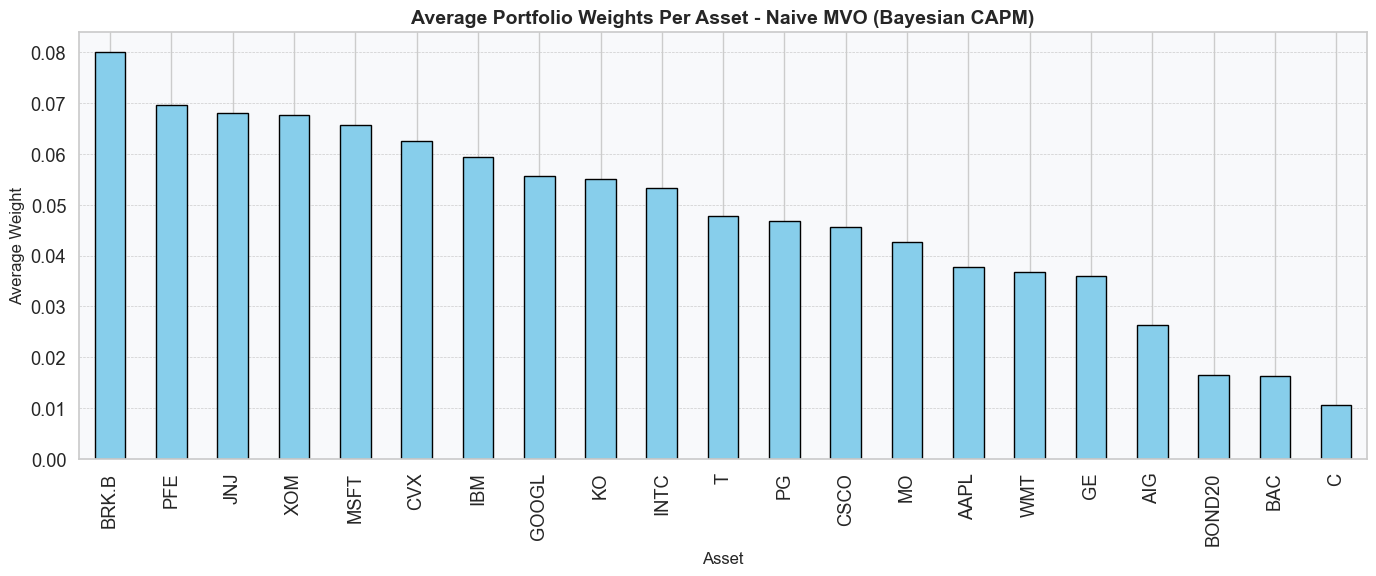




Running strategy: Bayesian Conjugate (CAPM Prior)
                AAPL       AIG       BAC    BOND20     BRK.B         C  \
2013-01-31  0.274224  0.009175  0.006860  0.184789  0.063540 -0.061388   
2013-03-28  0.307303  0.010033 -0.011495  0.148844  0.102697 -0.069469   
2013-05-31  0.257476  0.011023 -0.015864  0.156674  0.115901 -0.078583   
2013-07-31  0.242790  0.018585 -0.005996  0.101281  0.182879 -0.092018   
2013-09-30  0.287311  0.017719 -0.026504  0.102993  0.260306 -0.087554   

                CSCO       CVX        GE     GOOGL  ...      INTC       JNJ  \
2013-01-31 -0.090320  0.133056 -0.137835 -0.143784  ... -0.178018  0.035151   
2013-03-28 -0.143815  0.170857 -0.135963 -0.083769  ... -0.113804  0.060180   
2013-05-31 -0.144484  0.136525 -0.139821 -0.109206  ... -0.078525  0.027096   
2013-07-31 -0.061124 -0.016012 -0.154791 -0.043238  ... -0.078964  0.009538   
2013-09-30 -0.072379  0.089954 -0.158598 -0.018586  ... -0.128246 -0.004982   

                  KO       

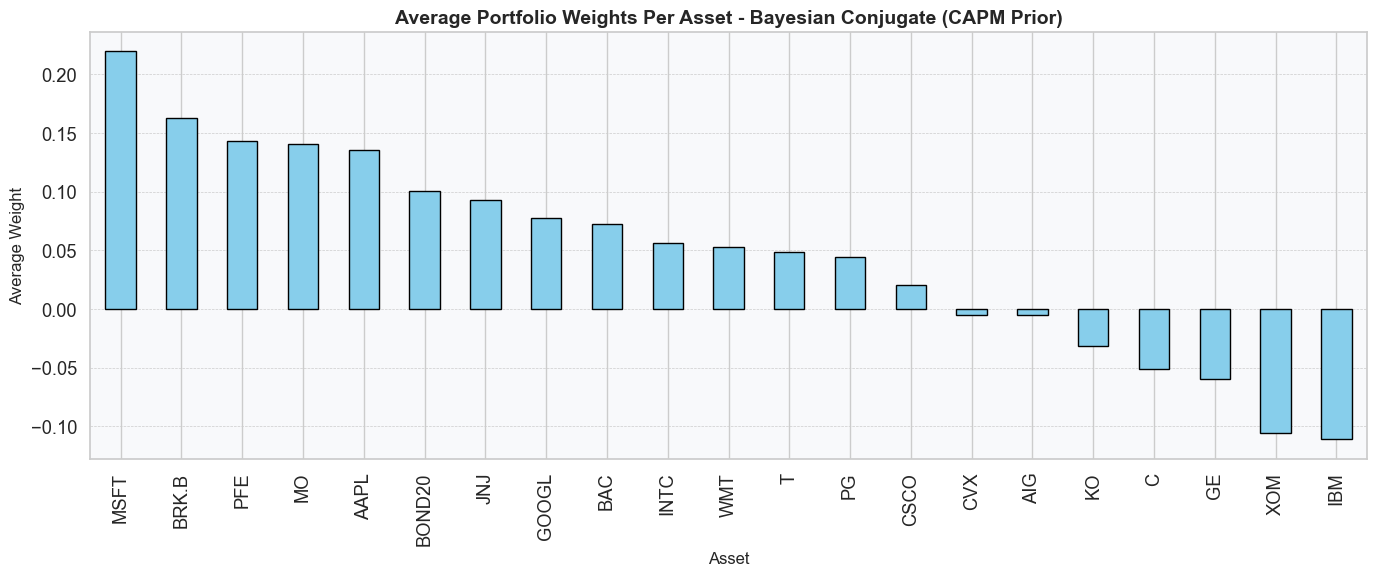




Running strategy: Bayesian Conjugate (CAPM Prior) Ridge
                AAPL       AIG       BAC    BOND20     BRK.B         C  \
2013-01-31  0.113680  0.012791  0.003948  0.093086  0.044906 -0.048517   
2013-03-28  0.122746  0.013458 -0.008867  0.078294  0.044145 -0.043448   
2013-05-31  0.101746  0.018280 -0.001649  0.077771  0.047692 -0.043435   
2013-07-31  0.087917  0.019157  0.009660  0.070561  0.057094 -0.036200   
2013-09-30  0.104557  0.023267 -0.003702  0.071232  0.064487 -0.043211   

                CSCO       CVX        GE     GOOGL  ...      INTC       JNJ  \
2013-01-31  0.013791  0.062667  0.008018  0.037672  ...  0.027529  0.058444   
2013-03-28  0.012068  0.061320  0.010741  0.062770  ...  0.039583  0.058948   
2013-05-31  0.011544  0.056996  0.009200  0.052413  ...  0.043197  0.060248   
2013-07-31  0.023127  0.044484  0.013217  0.057637  ...  0.039158  0.059610   
2013-09-30  0.019492  0.058840  0.010111  0.064413  ...  0.028875  0.055528   

                  KO 

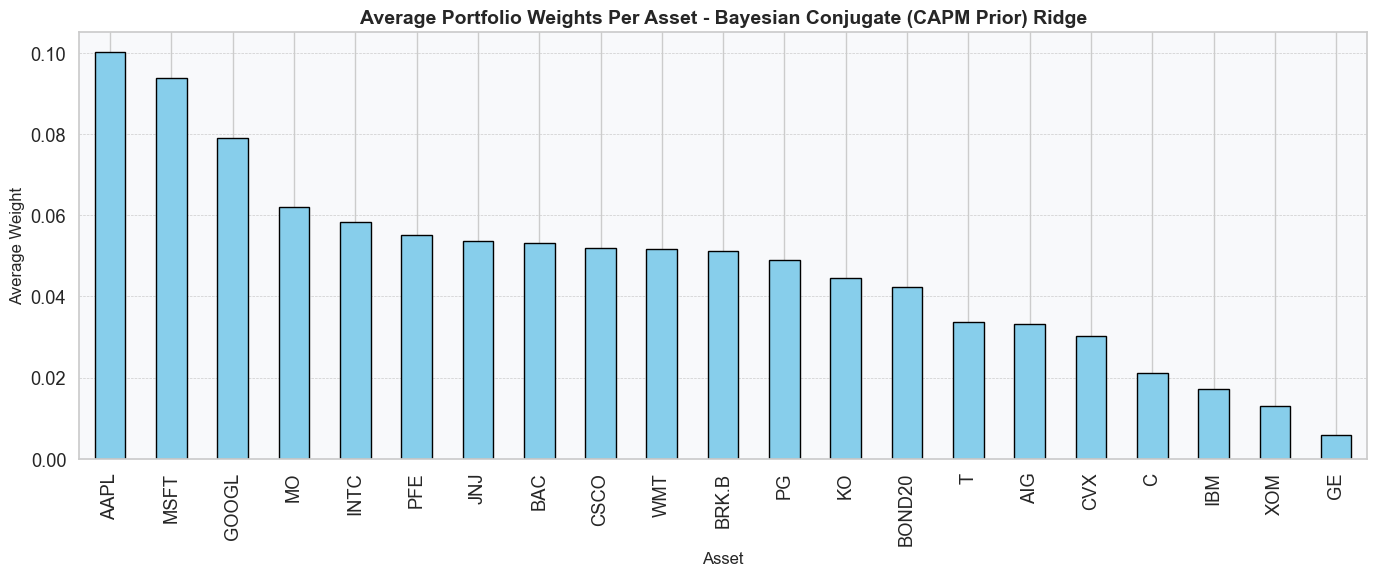

In [94]:
results_capm = {}
for name, (posterior_fn, kwargs) in capm_strategies.items():
    print(f"\n\n\nRunning strategy: {name}")
    ridge_flag = kwargs.pop("ridge", False)  # Extract ridge and remove from kwargs


    weights_df, returns_series = run_custom_strategy(
        excess_returns,
        benchmark_excess_returns,
        estimation_window=60,
        holding_period=2,
        risk_limit=0.03,
        constraint_fn=unconstrained,
        posterior_fn=posterior_fn,
        ridge=ridge_flag,   # Only passed once!
        adaptive_risk=True,
        **kwargs            # Pass any remaining kwargs
    )

    print(weights_df.head())


    rf_aligned = rf_final_aligned.reindex(returns_series.index, method='ffill')['rf_return']
    returns_total = returns_series + rf_aligned
    cum_total = (1 + returns_total).cumprod() * 100

    summary, diag, _, turnover = summarize_performance(weights_df, returns_series)
    results_capm[name] = (summary, diag, cum_total, weights_df)

    # Plot average weights (optional)
    avg_weight = diag["Average Weight"].sort_values(ascending=False)
    plt.figure(figsize=(14, 6))
    avg_weight.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Average Portfolio Weights Per Asset - {name}", fontsize=14, weight='bold')
    plt.xlabel("Asset", fontsize=12)
    plt.ylabel("Average Weight", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


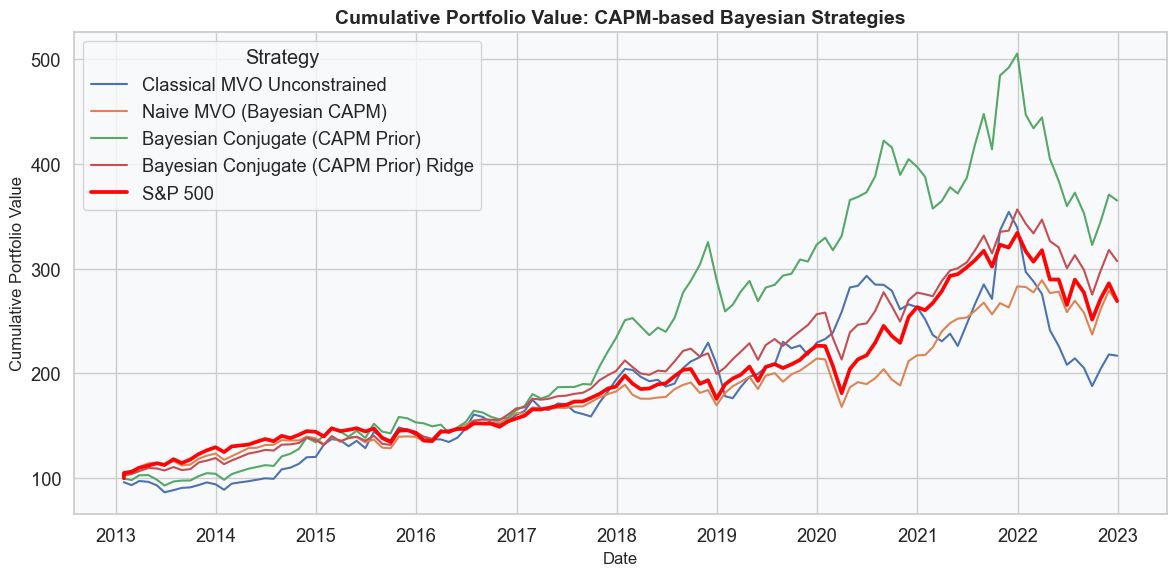

In [95]:
all_results_capm = {
    "Classical MVO Unconstrained": results_class["Unconstrained"],
    **results_capm
}

plt.figure(figsize=(12, 6))
for name, (_, _, cum_total, _) in all_results_capm.items():
    plt.plot(cum_total.index, cum_total.values, label=name)

plt.plot(
    aligned_bench.index, aligned_bench.values,
    linewidth=2.7, color='red', alpha=0.98,
    label="S&P 500", zorder=3
)

plt.title("Cumulative Portfolio Value: CAPM-based Bayesian Strategies", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Portfolio Value", fontsize=12)
plt.grid(True)
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()




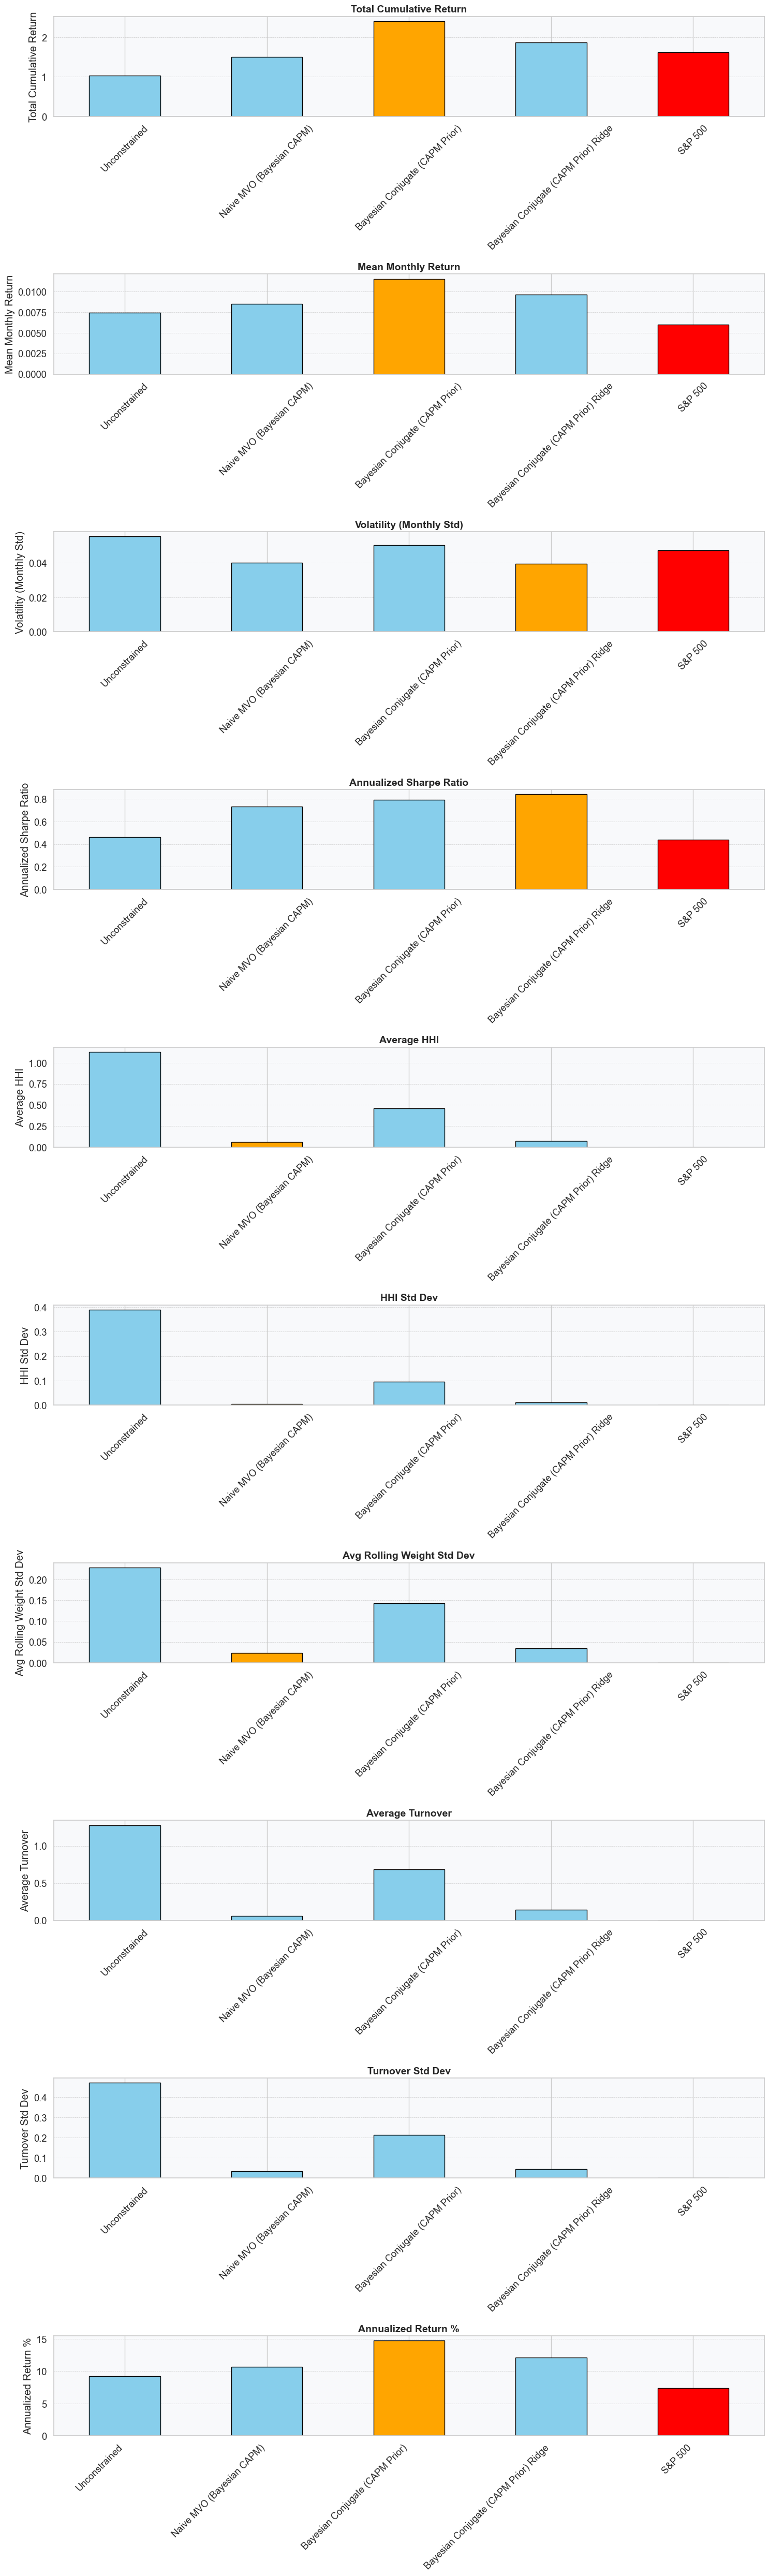

In [96]:
unconstrained_summary = {"Unconstrained": results_class["Unconstrained"][0].iloc[0]}
unconstrained_ridge_summary = {"Unconstrained Ridge": results_class["Unconstrained Ridge"][0].iloc[0]}
summary_bayes = {name: result[0].iloc[0] for name, result in results_bayes.items()}
summary_bayes_ridge = {name: result[0].iloc[0] for name, result in results_bayes_ridge.items()}
summary_capm = {name: result[0].iloc[0] for name, result in results_capm.items()}

summary_combined_capm = pd.DataFrame({
    **unconstrained_summary,
    **summary_capm,
    "S&P 500": benchmark_metrics.iloc[0]
}).T

# === List of metrics to plot ===
metrics_to_plot = [
    "Total Cumulative Return",
    "Mean Monthly Return",
    "Volatility (Monthly Std)",
    "Annualized Sharpe Ratio",
    "Average HHI",
    "HHI Std Dev",
    "Avg Rolling Weight Std Dev",
    "Average Turnover",
    "Turnover Std Dev",
    "Annualized Return %"
]

maximize_metrics = {
    "Total Cumulative Return",
    "Mean Monthly Return",
    "Annualized Sharpe Ratio",
    "Annualized Return %"
}

# === Plotting loop (same style as before) ===
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(15, 5 * len(metrics_to_plot)))

for i, metric in enumerate(metrics_to_plot):
    values = summary_combined_capm[metric]
    best_idx = values.idxmax() if metric in maximize_metrics else values.idxmin()
    colors = ['red' if idx == 'S&P 500' else 'orange' if idx == best_idx else 'skyblue' for idx in values.index]
    bars = values.plot(kind='bar', ax=axes[i], edgecolor='black', color=colors)
    axes[i].set_title(metric, fontsize=14, weight='bold')
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', linestyle='--', linewidth=0.5)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')

plt.setp(axes[i].get_xticklabels(), ha="right")
plt.tight_layout()
plt.show()


In [97]:
# === Extract classical strategy summaries ===
unconstrained_summary = {"Unconstrained": results_class["Unconstrained"][0].iloc[0]}
unconstrained_ridge_summary = {"Unconstrained Ridge": results_class["Unconstrained Ridge"][0].iloc[0]}

# === Extract Bayesian strategy summaries ===
summary_bayes = {name.replace("_ridge", ""): result[0].iloc[0] for name, result in results_bayes.items()}
summary_bayes_ridge = {name: result[0].iloc[0] for name, result in results_bayes_ridge.items()}

# === Combine grouped summaries ===
summary_unregularized = pd.DataFrame({
    **unconstrained_summary,
    **summary_bayes,
    **summary_capm,
    "S&P 500": benchmark_metrics.iloc[0]
}).T

summary_ridge = pd.DataFrame({
    **unconstrained_ridge_summary,
    **summary_bayes_ridge,
    "S&P 500": benchmark_metrics.iloc[0]
}).T

# === Display for verification ===
print("=== Unregularized ===")
display(summary_unregularized.round(4))

print("\n=== Ridge Regularised ===")
display(summary_ridge.round(4))

=== Unregularized ===


Total Cumulative Return  \
Unconstrained                                              1.0253   
Bayesian Diffuse                                           0.8192   
Bayesian Non-informative Conjugate Prior                   1.1365   
Naive MVO (Bayesian CAPM)                                  1.5023   
Bayesian Conjugate (CAPM Prior)                            2.4086   
Bayesian Conjugate (CAPM Prior) Ridge                      1.8676   
S&P 500                                                    1.6148   

                                          Mean Monthly Return  \
Unconstrained                                          0.0074   
Bayesian Diffuse                                       0.0059   
Bayesian Non-informative Conjugate Prior               0.0079   
Naive MVO (Bayesian CAPM)                              0.0085   
Bayesian Conjugate (CAPM Prior)                        0.0115   
Bayesian Conjugate (CAPM Prior) Ridge                  0.0096   
S&P 500                                                0.0060   

                                          Volatility (Monthly Std)  \
Unconstrained                                               0.0554   
Bayesian Diffuse                                            0.0439   
Bayesian Non-informative Conjugate Prior                    0.0562   
Naive MVO (Bayesian CAPM)                                   0.0401   
Bayesian Conjugate (CAPM Prior)                             0.0503   
Bayesian Conjugate (CAPM Prior) Ridge                       0.0396   
S&P 500                                                     0.0472   

                                          Annualized Sharpe Ratio  \
Unconstrained                                              0.4627   
Bayesian Diffuse                                           0.4690   
Bayesian Non-informative Conjugate Prior                   0.4863   
Naive MVO (Bayesian CAPM)                                  0.7318   
Bayesian Conjugate (CAPM Prior)                            0.7935   
Bayesian Conjugate (CAPM Prior) Ridge                      0.8403   
S&P 500                                                    0.4391   

                                          Annualized Return %  Average HHI  \
Unconstrained                                          9.2446       1.1266   
Bayesian Diffuse                                       7.3662       0.7591   
Bayesian Non-informative Conjugate Prior               9.8931       1.1419   
Naive MVO (Bayesian CAPM)                             10.6545       0.0590   
Bayesian Conjugate (CAPM Prior)                       14.7361       0.4627   
Bayesian Conjugate (CAPM Prior) Ridge                 12.1412       0.0722   
S&P 500                                                7.4249          NaN   

                                          HHI Std Dev  \
Unconstrained                                  0.3897   
Bayesian Diffuse                               0.2894   
Bayesian Non-informative Conjugate Prior       0.3527   
Naive MVO (Bayesian CAPM)                      0.0032   
Bayesian Conjugate (CAPM Prior)                0.0957   
Bayesian Conjugate (CAPM Prior) Ridge          0.0100   
S&P 500                                           NaN   

                                          Avg Rolling Weight Std Dev  \
Unconstrained                                                 0.2285   
Bayesian Diffuse                                              0.1849   
Bayesian Non-informative Conjugate Prior                      0.2309   
Naive MVO (Bayesian CAPM)                                     0.0236   
Bayesian Conjugate (CAPM Prior)                               0.1431   
Bayesian Conjugate (CAPM Prior) Ridge                         0.0343   
S&P 500                                                          NaN   

                                          Average Turnover  Turnover Std Dev  
Unconstrained                                       1.2776            0.4703  
Bayesian Diffuse                     


=== Ridge Regularised ===


Total Cumulative Return  \
Unconstrained Ridge                                              1.6101   
Bayesian Diffuse_ridge                                           1.2435   
Bayesian Non-informative Conjugate Prior_ridge                   1.6968   
S&P 500                                                          1.6148   

                                                Mean Monthly Return  \
Unconstrained Ridge                                          0.0087   
Bayesian Diffuse_ridge                                       0.0073   
Bayesian Non-informative Conjugate Prior_ridge               0.0090   
S&P 500                                                      0.0060   

                                                Volatility (Monthly Std)  \
Unconstrained Ridge                                               0.0361   
Bayesian Diffuse_ridge                                            0.0316   
Bayesian Non-informative Conjugate Prior_ridge                    0.0378   
S&P 500                                                           0.0472   

                                                Annualized Sharpe Ratio  \
Unconstrained Ridge                                              0.8318   
Bayesian Diffuse_ridge                                           0.7944   
Bayesian Non-informative Conjugate Prior_ridge                   0.8266   
S&P 500                                                          0.4391   

                                                Annualized Return %  \
Unconstrained Ridge                                         10.9216   
Bayesian Diffuse_ridge                                       9.0597   
Bayesian Non-informative Conjugate Prior_ridge              11.3643   
S&P 500                                                      7.4249   

                                                Average HHI  HHI Std Dev  \
Unconstrained Ridge                                  0.0748       0.0155   
Bayesian Diffuse_ridge                               0.0950       0.0350   
Bayesian Non-informative Conjugate Prior_ridge       0.0661       0.0095   
S&P 500                                                 NaN          NaN   

                                                Avg Rolling Weight Std Dev  \
Unconstrained Ridge                                                 0.0355   
Bayesian Diffuse_ridge                                              0.0461   
Bayesian Non-informative Conjugate Prior_ridge                      0.0294   
S&P 500                                                                NaN   

                                                Average Turnover  \
Unconstrained Ridge                                       0.1393   
Bayesian Diffuse_ridge                                    0.1462   
Bayesian Non-informative Conjugate Prior_ridge            0.1177   
S&P 500                                                   0.0000   

                                                Turnover Std Dev  
Unconstrained Ridge                                       0.0542  
Bayesian Diffuse_ridge                                    0.0837  
Bayesian Non-informative Conjugate Prior_ridge            0.0430  
S&P 500                                                   0.0000

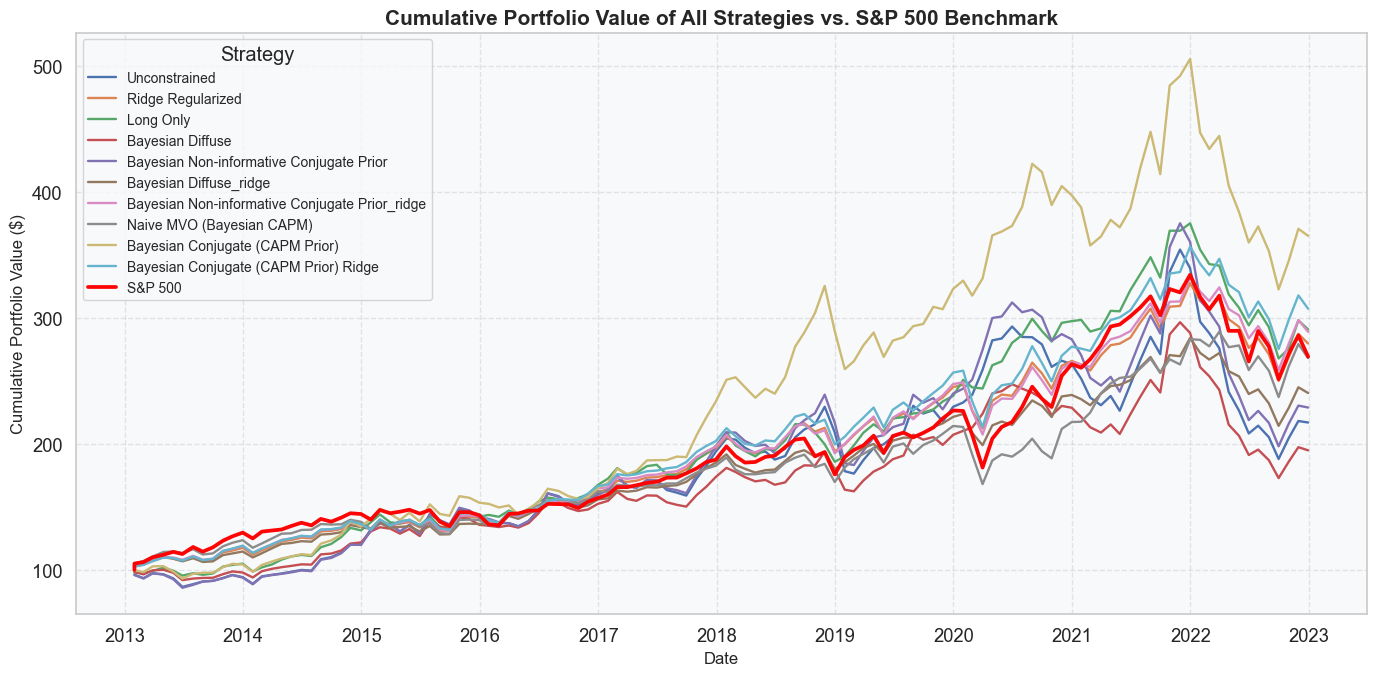

In [98]:
# === Combine all cumulative returns into a final summary plot ===
final_all_results = {
    "Unconstrained": results_class["Unconstrained"][2],
    "Ridge Regularized": results_class["Unconstrained Ridge"][2],
    "Long Only": results_class["Long Only"][2],
    **{name: val[2] for name, val in results_bayes.items()},
    **{name: val[2] for name, val in results_bayes_ridge.items()},
    **{name: val[2] for name, val in results_capm.items()}
}

# Plot all strategies
plt.figure(figsize=(14, 7))
for name, series in final_all_results.items():
    plt.plot(series.index, series.values, label=name, linewidth=1.7)

# Highlight the S&P 500 separately
plt.plot(
    aligned_bench.index, aligned_bench.values,
    linewidth=2.7, color='red', alpha=0.98,
    label="S&P 500", zorder=3
)

plt.title("Cumulative Portfolio Value of All Strategies vs. S&P 500 Benchmark", fontsize=15, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Portfolio Value ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Strategy", fontsize=10)
plt.tight_layout()
plt.show()


In [99]:
print('Mario')

Mario
